# Generative Models
***

**MIPT, Autumn 2022, MSc course**


## Assignment 1

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Alexander Panfilov*

***


The assignment is split into two parts: at first, you will implement classical GAN for the MNIST dataset, and after, you will enhance your results with DCGAN and the CIFAR dataset. 

Good luck!

## 1. GAN
*Source: <a href="https://arxiv.org/pdf/1406.2661.pdf" target="_blank">Goodfellow, Ian J., et al. "Generative Adversarial Networks." arXiv preprint arXiv:1406.2661 (2014)</a>.*

In 2014, Ian Goodfellow and his colleagues at the University of Montreal published a stunning paper introducing the world to GANs, or generative adversarial networks. The models play two distinct (literally, adversarial) roles. Given some real data set $\mathcal{X}$, $G$ is the generator, trying to create fake data that looks just like the genuine data, while $D$ is the discriminator, getting data from either the real set or $G$ and labeling the difference.

Goodfellow’s metaphor (and a fine one it is) was that $G$ was like a team of forgers trying to match real paintings with their output, while $D$ was the team of detectives trying to tell the difference. (Except in this case, the forgers $G$ never get to see the original data — only the judgments of $D$. They’re like blind forgers.)

<img src="https://production-media.paperswithcode.com/methods/gan.jpeg" style="display=block; margin:auto"/>
<p style="text-align: center">
    <b>Picture taken from the <a href="https://paperswithcode.com/method/gan" target="_blank">paperswithcode</a> website. There you can find a whole bunch of papers on GANs with implementation.</b>
</p>

In this part, we are going to implement classical GAN. You can find a rough plan on how to do it below; however, it is not mandatory to stick with it precisely but one might expect some questions related to the listed steps. Feel free to adapt provided code!

- Define the parameters
- Load the data (with transforms and normalization)
- Denormalize for visual inspection of samples
- Define the Discriminator network, the Generator network
- Study the activation function: Leaky ReLU
- Explain the output activation function: Tanh, Sigmoid
- Look at some sample outputs
- Define losses, optimizers and helper functions for training
     - For Discriminator
     - For Generator
- Train the model
- Save intermediate generated images to file
- Look at some outputs
- Save the models

### Imports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import save_image
from torch.utils.data import DataLoader


%matplotlib inline
plt.style.use("ggplot")

### Define parameters & data loading 

In [4]:
hidden_size = 256
batch_size = 100
LR = 0.0002
num_epochs = 300
sample_dir = "./images"
latent_size = 64  # input random input vector latent
image_size = 784  # 28*28 flatten
device = "cuda:0" if torch.cuda.is_available() else "cpu"

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
## Define the dataset
mnist_dataset = MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]),
)

Label:  5


(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([-1.        , -0.86771244, -0.7354248 , -0.60313725, -0.47084966,
        -0.3385621 , -0.20627451, -0.07398693,  0.05830066,  0.19058824,
         0.32287583,  0.4551634 ,  0.587451  ,  0.71973854,  0.85202616,
         0.9843137 ], dtype=float32),
 <a list of 100 BarContainer objects>)

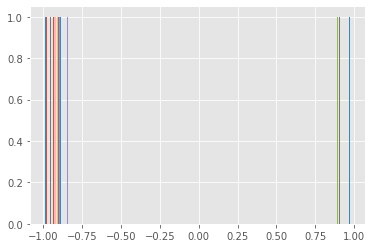

In [5]:
img, label = mnist_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [ ]:
# denormalization image from range (-1)-1 to range 0-1 to display it

In [6]:
def denorm(x):
    max_value = 1.
    return (x + max_value) / 2

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([0.        , 0.06614379, 0.13228758, 0.19843137, 0.26457515,
        0.33071896, 0.39686275, 0.46300653, 0.5291503 , 0.5952941 ,
        0.6614379 , 0.7275817 , 0.7937255 , 0.8598693 , 0.92601305,
        0.99215686], dtype=float32),
 <a list of 100 BarContainer objects>)

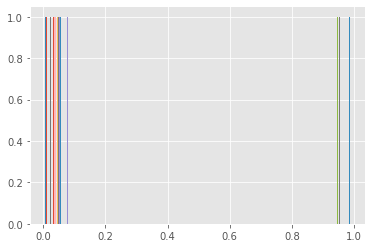

In [8]:
plt.hist(denorm(img)[:, 5:15, 5:15].flatten(), bins=15)

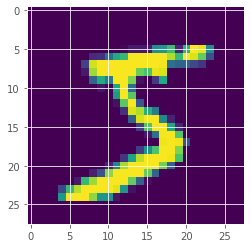

In [7]:
# show image sample with matplotlib

denormed_img = denorm(img)
plt.imshow(denormed_img.squeeze(0).numpy())

In [9]:
# define the dataloader

dataloader = DataLoader(
    mnist_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4 #
)

### GAN implementation

GAN consists of two deep networks, a generator ($G$) and a discriminator ($D$). The generator creates images before learning it. Since the discriminator is a binary classification model, we can use the binary cross-entropy loss function to quantify how well it can distinguish between real and generated images.

In [10]:
class Generator(nn.Module):
    def __init__(self, latent_size, image_size, hidden_size):
        super(Generator, self).__init__()
        ## set a linear layer with input size is latent_size and output size is hidden_size
        self.linear_1 = nn.Linear(latent_size, hidden_size)

        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.linear_2 = nn.Linear(hidden_size, hidden_size)

        # set a linear layer with input size is hidden_size and output size is image_size
        self.linear_3 = nn.Linear(hidden_size, image_size)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> tanh
        x = self.relu(self.linear_1(x))
        x = self.relu(self.linear_2(x))
        x = self.tanh(self.linear_3(x))
        
        return x


class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size):
        super(Discriminator, self).__init__()
        ## set a linear layer with input size is image_size and output size is hidden_size
        self.linear_1 = nn.Linear(image_size, hidden_size)

        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.linear_2 = nn.Linear(hidden_size, hidden_size)

        # set a linear layer with input size is hidden_size and output size is 1
        self.linear_3 = nn.Linear(hidden_size, 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> sigmoid
        x = self.relu(self.linear_1(x))
        x = self.relu(self.linear_2(x))
        x = self.sigmoid(self.linear_3(x))

        return x

### Create the Generator and Discriminator

In [11]:
# create new Generator model
# create new Discriminator model

G = Generator(latent_size, image_size, hidden_size).to(device)
D = Discriminator(image_size, hidden_size).to(device)

In [12]:
# show the output of model
y = G(torch.randn(2, latent_size).to(device))

In [13]:
y.shape

torch.Size([2, 784])

In [14]:
# define the criterion is nn.BCELoss()
## Define the optimizer for generator and discrimator

criterion = nn.BCELoss()
G_optimizer = torch.optim.AdamW(G.parameters(), lr=LR)
D_optimizer = torch.optim.AdamW(D.parameters(), lr=LR)

Discriminator Training

In [15]:
def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    G_optimizer.zero_grad()
    D_optimizer.zero_grad()

def train_discriminator(D_model, G_model, images):
  
    # Create the labels which are later used as input for the BCE loss
    real_labels = Variable(torch.ones(batch_size, 1).to(device))
    fake_labels = Variable(torch.zeros(batch_size, 1).to(device))
        
    
    outputs = D_model(images)
    # Loss for real images
    
    real_score = outputs

    # Loss for fake images
    z = Variable(torch.randn(batch_size, latent_size).to(device))
    fake_images = G_model(z)
    outputs = D_model(fake_images)

    fake_score = outputs

    # Sum losses
    real_loss = criterion(real_score, real_labels)
    fake_loss = criterion(fake_score, fake_labels)
    d_loss = real_loss + fake_loss

    # Reset gradients
    reset_grad()

    # Compute gradients
    d_loss.backward()

    # Adjust the parameters using backprop
    D_optimizer.step()
    
    return d_loss, real_score, fake_score

Generator Training

In [16]:
def train_generator(G_model, D_model):
    # Generate fake images and calculate loss
    # z = torch.randn(batch_size, latent_size).to(device)
    z = Variable(torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device))
    fake_images = G_model(z)
    labels = torch.ones(batch_size, 1).to(device)
    # calculate the generator loss
    
    g_loss = criterion(D_model(fake_images), labels)

    # Reset gradients
    reset_grad()

    # Backprop and optimize
    g_loss.backward()
    G_optimizer.step()

    return g_loss, fake_images

### Start the training proccess

In [17]:
# function to save the sample output of generator
def save_fake_images_mnist(G_model, index):
    # sample_vectors = torch.randn(batch_size, latent_size).to(device)
    sample_vectors = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(
        device
    )
    fake_images = G_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [18]:
# training

In [19]:
%%time
total_step = len(dataloader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
for epoch in tqdm(range(num_epochs)):
    for i, (images, _) in enumerate(dataloader):
        # Load a batch & transform to vectors
        images = Variable(images.reshape(batch_size, -1).to(device))

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(D, G, images)

        # Train the generator
        g_loss, fake_images = train_generator(G, D)

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_mnist(G, epoch + 1)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [0/300], Step [200/600], d_loss: 0.1871, g_loss: 2.3866, D(x): 0.95, D(G(z)): 0.13
Epoch [0/300], Step [400/600], d_loss: 0.2288, g_loss: 4.2147, D(x): 0.95, D(G(z)): 0.14


  0%|          | 1/300 [00:04<20:26,  4.10s/it]

Epoch [0/300], Step [600/600], d_loss: 0.3823, g_loss: 2.9627, D(x): 0.86, D(G(z)): 0.15
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.2771, g_loss: 3.8683, D(x): 0.88, D(G(z)): 0.11
Epoch [1/300], Step [400/600], d_loss: 0.0737, g_loss: 5.4984, D(x): 0.97, D(G(z)): 0.03


  1%|          | 2/300 [00:08<20:45,  4.18s/it]

Epoch [1/300], Step [600/600], d_loss: 1.3376, g_loss: 1.5893, D(x): 0.67, D(G(z)): 0.31
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.9910, g_loss: 2.8839, D(x): 0.66, D(G(z)): 0.13
Epoch [2/300], Step [400/600], d_loss: 0.2853, g_loss: 3.9360, D(x): 0.87, D(G(z)): 0.03


  1%|          | 3/300 [00:12<20:29,  4.14s/it]

Epoch [2/300], Step [600/600], d_loss: 0.1647, g_loss: 4.2286, D(x): 0.92, D(G(z)): 0.05
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 1.0883, g_loss: 1.3374, D(x): 0.57, D(G(z)): 0.24
Epoch [3/300], Step [400/600], d_loss: 1.0740, g_loss: 1.8024, D(x): 0.68, D(G(z)): 0.34


  1%|▏         | 4/300 [00:16<20:40,  4.19s/it]

Epoch [3/300], Step [600/600], d_loss: 1.1252, g_loss: 1.5570, D(x): 0.66, D(G(z)): 0.37
Saving fake_images-0004.png
Epoch [4/300], Step [200/600], d_loss: 0.7194, g_loss: 1.7811, D(x): 0.74, D(G(z)): 0.19
Epoch [4/300], Step [400/600], d_loss: 1.5861, g_loss: 1.2911, D(x): 0.59, D(G(z)): 0.45


  2%|▏         | 5/300 [00:20<20:15,  4.12s/it]

Epoch [4/300], Step [600/600], d_loss: 0.6721, g_loss: 2.2471, D(x): 0.75, D(G(z)): 0.17
Saving fake_images-0005.png
Epoch [5/300], Step [200/600], d_loss: 0.7423, g_loss: 2.0043, D(x): 0.75, D(G(z)): 0.23
Epoch [5/300], Step [400/600], d_loss: 1.3368, g_loss: 1.2656, D(x): 0.58, D(G(z)): 0.39


  2%|▏         | 6/300 [00:24<19:56,  4.07s/it]

Epoch [5/300], Step [600/600], d_loss: 0.2596, g_loss: 3.1855, D(x): 0.91, D(G(z)): 0.10
Saving fake_images-0006.png
Epoch [6/300], Step [200/600], d_loss: 0.9835, g_loss: 1.7480, D(x): 0.74, D(G(z)): 0.38
Epoch [6/300], Step [400/600], d_loss: 0.2681, g_loss: 3.1528, D(x): 0.96, D(G(z)): 0.18


  2%|▏         | 7/300 [00:28<19:52,  4.07s/it]

Epoch [6/300], Step [600/600], d_loss: 1.5863, g_loss: 1.1446, D(x): 0.56, D(G(z)): 0.48
Saving fake_images-0007.png
Epoch [7/300], Step [200/600], d_loss: 0.3893, g_loss: 2.3465, D(x): 0.84, D(G(z)): 0.14
Epoch [7/300], Step [400/600], d_loss: 0.9758, g_loss: 1.7522, D(x): 0.75, D(G(z)): 0.36


  3%|▎         | 8/300 [00:32<19:36,  4.03s/it]

Epoch [7/300], Step [600/600], d_loss: 1.9526, g_loss: 0.7474, D(x): 0.43, D(G(z)): 0.52
Saving fake_images-0008.png
Epoch [8/300], Step [200/600], d_loss: 2.7654, g_loss: 0.7780, D(x): 0.32, D(G(z)): 0.57
Epoch [8/300], Step [400/600], d_loss: 0.8502, g_loss: 1.5164, D(x): 0.74, D(G(z)): 0.37


  3%|▎         | 9/300 [00:36<19:31,  4.03s/it]

Epoch [8/300], Step [600/600], d_loss: 1.2596, g_loss: 1.4602, D(x): 0.65, D(G(z)): 0.48
Saving fake_images-0009.png
Epoch [9/300], Step [200/600], d_loss: 0.3820, g_loss: 2.5902, D(x): 0.85, D(G(z)): 0.12
Epoch [9/300], Step [400/600], d_loss: 1.4705, g_loss: 0.7838, D(x): 0.57, D(G(z)): 0.54


  3%|▎         | 10/300 [00:40<19:29,  4.03s/it]

Epoch [9/300], Step [600/600], d_loss: 1.3025, g_loss: 1.2197, D(x): 0.55, D(G(z)): 0.40
Saving fake_images-0010.png
Epoch [10/300], Step [200/600], d_loss: 1.8413, g_loss: 1.0202, D(x): 0.52, D(G(z)): 0.57
Epoch [10/300], Step [400/600], d_loss: 0.6777, g_loss: 1.9964, D(x): 0.71, D(G(z)): 0.22


  4%|▎         | 11/300 [00:44<19:18,  4.01s/it]

Epoch [10/300], Step [600/600], d_loss: 2.1448, g_loss: 0.9270, D(x): 0.34, D(G(z)): 0.47
Saving fake_images-0011.png
Epoch [11/300], Step [200/600], d_loss: 1.0176, g_loss: 1.2644, D(x): 0.67, D(G(z)): 0.37
Epoch [11/300], Step [400/600], d_loss: 1.0578, g_loss: 1.3211, D(x): 0.66, D(G(z)): 0.40


  4%|▍         | 12/300 [00:48<19:23,  4.04s/it]

Epoch [11/300], Step [600/600], d_loss: 0.8685, g_loss: 1.0750, D(x): 0.71, D(G(z)): 0.37
Saving fake_images-0012.png
Epoch [12/300], Step [200/600], d_loss: 0.8253, g_loss: 1.3588, D(x): 0.72, D(G(z)): 0.35
Epoch [12/300], Step [400/600], d_loss: 1.0553, g_loss: 1.2632, D(x): 0.63, D(G(z)): 0.39


  4%|▍         | 13/300 [00:52<19:21,  4.05s/it]

Epoch [12/300], Step [600/600], d_loss: 1.8786, g_loss: 0.7223, D(x): 0.44, D(G(z)): 0.58
Saving fake_images-0013.png
Epoch [13/300], Step [200/600], d_loss: 1.3304, g_loss: 0.8895, D(x): 0.61, D(G(z)): 0.52
Epoch [13/300], Step [400/600], d_loss: 1.0485, g_loss: 1.2969, D(x): 0.62, D(G(z)): 0.39


  5%|▍         | 14/300 [00:56<19:23,  4.07s/it]

Epoch [13/300], Step [600/600], d_loss: 0.6391, g_loss: 1.8801, D(x): 0.79, D(G(z)): 0.28
Saving fake_images-0014.png
Epoch [14/300], Step [200/600], d_loss: 0.7536, g_loss: 1.2321, D(x): 0.69, D(G(z)): 0.30
Epoch [14/300], Step [400/600], d_loss: 0.6677, g_loss: 1.2934, D(x): 0.72, D(G(z)): 0.28


  5%|▌         | 15/300 [01:01<19:16,  4.06s/it]

Epoch [14/300], Step [600/600], d_loss: 0.9578, g_loss: 1.1202, D(x): 0.61, D(G(z)): 0.33
Saving fake_images-0015.png
Epoch [15/300], Step [200/600], d_loss: 1.1741, g_loss: 1.1815, D(x): 0.60, D(G(z)): 0.39
Epoch [15/300], Step [400/600], d_loss: 0.2168, g_loss: 2.6740, D(x): 0.90, D(G(z)): 0.09


  5%|▌         | 16/300 [01:05<19:26,  4.11s/it]

Epoch [15/300], Step [600/600], d_loss: 0.6093, g_loss: 1.9839, D(x): 0.82, D(G(z)): 0.23
Saving fake_images-0016.png
Epoch [16/300], Step [200/600], d_loss: 0.3325, g_loss: 2.9206, D(x): 0.85, D(G(z)): 0.10
Epoch [16/300], Step [400/600], d_loss: 0.6280, g_loss: 1.8096, D(x): 0.80, D(G(z)): 0.18


  6%|▌         | 17/300 [01:09<19:06,  4.05s/it]

Epoch [16/300], Step [600/600], d_loss: 0.8776, g_loss: 2.1532, D(x): 0.78, D(G(z)): 0.31
Saving fake_images-0017.png
Epoch [17/300], Step [200/600], d_loss: 0.4687, g_loss: 2.2992, D(x): 0.83, D(G(z)): 0.16
Epoch [17/300], Step [400/600], d_loss: 1.1783, g_loss: 1.4572, D(x): 0.64, D(G(z)): 0.29


  6%|▌         | 18/300 [01:13<19:01,  4.05s/it]

Epoch [17/300], Step [600/600], d_loss: 0.3617, g_loss: 3.9079, D(x): 0.87, D(G(z)): 0.12
Saving fake_images-0018.png
Epoch [18/300], Step [200/600], d_loss: 0.9288, g_loss: 1.6674, D(x): 0.76, D(G(z)): 0.35
Epoch [18/300], Step [400/600], d_loss: 0.3732, g_loss: 3.0632, D(x): 0.91, D(G(z)): 0.19


  6%|▋         | 19/300 [01:17<18:55,  4.04s/it]

Epoch [18/300], Step [600/600], d_loss: 0.6480, g_loss: 2.3389, D(x): 0.78, D(G(z)): 0.22
Saving fake_images-0019.png
Epoch [19/300], Step [200/600], d_loss: 0.6514, g_loss: 2.9172, D(x): 0.78, D(G(z)): 0.11
Epoch [19/300], Step [400/600], d_loss: 0.3707, g_loss: 2.6223, D(x): 0.90, D(G(z)): 0.15


  7%|▋         | 20/300 [01:21<18:48,  4.03s/it]

Epoch [19/300], Step [600/600], d_loss: 0.8365, g_loss: 2.7661, D(x): 0.78, D(G(z)): 0.25
Saving fake_images-0020.png
Epoch [20/300], Step [200/600], d_loss: 0.9625, g_loss: 2.7879, D(x): 0.74, D(G(z)): 0.23
Epoch [20/300], Step [400/600], d_loss: 0.9467, g_loss: 1.9761, D(x): 0.74, D(G(z)): 0.32


  7%|▋         | 21/300 [01:25<18:54,  4.07s/it]

Epoch [20/300], Step [600/600], d_loss: 0.6752, g_loss: 2.2661, D(x): 0.78, D(G(z)): 0.23
Saving fake_images-0021.png
Epoch [21/300], Step [200/600], d_loss: 0.8764, g_loss: 1.3542, D(x): 0.79, D(G(z)): 0.38
Epoch [21/300], Step [400/600], d_loss: 0.5835, g_loss: 2.1797, D(x): 0.83, D(G(z)): 0.25


  7%|▋         | 22/300 [01:29<19:00,  4.10s/it]

Epoch [21/300], Step [600/600], d_loss: 0.7419, g_loss: 1.7792, D(x): 0.76, D(G(z)): 0.28
Saving fake_images-0022.png
Epoch [22/300], Step [200/600], d_loss: 0.8716, g_loss: 1.4816, D(x): 0.71, D(G(z)): 0.24
Epoch [22/300], Step [400/600], d_loss: 0.5199, g_loss: 2.3606, D(x): 0.86, D(G(z)): 0.21


  8%|▊         | 23/300 [01:33<18:46,  4.07s/it]

Epoch [22/300], Step [600/600], d_loss: 0.6618, g_loss: 1.9968, D(x): 0.85, D(G(z)): 0.28
Saving fake_images-0023.png
Epoch [23/300], Step [200/600], d_loss: 0.3662, g_loss: 2.3730, D(x): 0.89, D(G(z)): 0.18
Epoch [23/300], Step [400/600], d_loss: 0.3464, g_loss: 2.2254, D(x): 0.91, D(G(z)): 0.18


  8%|▊         | 24/300 [01:37<18:52,  4.10s/it]

Epoch [23/300], Step [600/600], d_loss: 0.5213, g_loss: 1.8962, D(x): 0.84, D(G(z)): 0.22
Saving fake_images-0024.png
Epoch [24/300], Step [200/600], d_loss: 0.5521, g_loss: 2.0630, D(x): 0.85, D(G(z)): 0.25
Epoch [24/300], Step [400/600], d_loss: 0.2374, g_loss: 2.8178, D(x): 0.92, D(G(z)): 0.11


  8%|▊         | 25/300 [01:41<18:38,  4.07s/it]

Epoch [24/300], Step [600/600], d_loss: 0.4908, g_loss: 3.1365, D(x): 0.78, D(G(z)): 0.08
Saving fake_images-0025.png
Epoch [25/300], Step [200/600], d_loss: 0.6454, g_loss: 2.3904, D(x): 0.79, D(G(z)): 0.18
Epoch [25/300], Step [400/600], d_loss: 0.4711, g_loss: 3.1550, D(x): 0.85, D(G(z)): 0.16


  9%|▊         | 26/300 [01:45<18:31,  4.06s/it]

Epoch [25/300], Step [600/600], d_loss: 0.9869, g_loss: 2.1488, D(x): 0.76, D(G(z)): 0.31
Saving fake_images-0026.png
Epoch [26/300], Step [200/600], d_loss: 0.3516, g_loss: 2.8154, D(x): 0.88, D(G(z)): 0.13
Epoch [26/300], Step [400/600], d_loss: 1.2175, g_loss: 2.4797, D(x): 0.65, D(G(z)): 0.24


  9%|▉         | 27/300 [01:49<18:31,  4.07s/it]

Epoch [26/300], Step [600/600], d_loss: 0.7255, g_loss: 1.6319, D(x): 0.79, D(G(z)): 0.28
Saving fake_images-0027.png
Epoch [27/300], Step [200/600], d_loss: 0.6550, g_loss: 2.0120, D(x): 0.78, D(G(z)): 0.20
Epoch [27/300], Step [400/600], d_loss: 0.6834, g_loss: 2.3811, D(x): 0.78, D(G(z)): 0.17


  9%|▉         | 28/300 [01:53<18:21,  4.05s/it]

Epoch [27/300], Step [600/600], d_loss: 0.6169, g_loss: 2.5914, D(x): 0.83, D(G(z)): 0.20
Saving fake_images-0028.png
Epoch [28/300], Step [200/600], d_loss: 0.4428, g_loss: 2.2045, D(x): 0.84, D(G(z)): 0.17
Epoch [28/300], Step [400/600], d_loss: 0.8380, g_loss: 2.1581, D(x): 0.74, D(G(z)): 0.18


 10%|▉         | 29/300 [01:58<18:27,  4.09s/it]

Epoch [28/300], Step [600/600], d_loss: 0.3362, g_loss: 2.8693, D(x): 0.88, D(G(z)): 0.11
Saving fake_images-0029.png
Epoch [29/300], Step [200/600], d_loss: 0.4045, g_loss: 2.7496, D(x): 0.84, D(G(z)): 0.12
Epoch [29/300], Step [400/600], d_loss: 0.4526, g_loss: 3.0759, D(x): 0.86, D(G(z)): 0.14


 10%|█         | 30/300 [02:02<18:27,  4.10s/it]

Epoch [29/300], Step [600/600], d_loss: 1.0927, g_loss: 1.9039, D(x): 0.71, D(G(z)): 0.31
Saving fake_images-0030.png
Epoch [30/300], Step [200/600], d_loss: 0.6023, g_loss: 2.1558, D(x): 0.83, D(G(z)): 0.23
Epoch [30/300], Step [400/600], d_loss: 0.8441, g_loss: 2.6704, D(x): 0.66, D(G(z)): 0.10


 10%|█         | 31/300 [02:06<18:16,  4.08s/it]

Epoch [30/300], Step [600/600], d_loss: 0.5215, g_loss: 2.7476, D(x): 0.79, D(G(z)): 0.11
Saving fake_images-0031.png
Epoch [31/300], Step [200/600], d_loss: 0.6120, g_loss: 2.9669, D(x): 0.79, D(G(z)): 0.14
Epoch [31/300], Step [400/600], d_loss: 0.3842, g_loss: 3.8672, D(x): 0.86, D(G(z)): 0.10


 11%|█         | 32/300 [02:10<18:12,  4.08s/it]

Epoch [31/300], Step [600/600], d_loss: 0.4246, g_loss: 3.2659, D(x): 0.88, D(G(z)): 0.12
Saving fake_images-0032.png
Epoch [32/300], Step [200/600], d_loss: 0.2774, g_loss: 3.6880, D(x): 0.91, D(G(z)): 0.13
Epoch [32/300], Step [400/600], d_loss: 0.3506, g_loss: 2.6418, D(x): 0.91, D(G(z)): 0.13


 11%|█         | 33/300 [02:14<18:16,  4.11s/it]

Epoch [32/300], Step [600/600], d_loss: 0.3608, g_loss: 3.1482, D(x): 0.89, D(G(z)): 0.10
Saving fake_images-0033.png
Epoch [33/300], Step [200/600], d_loss: 0.4918, g_loss: 3.4116, D(x): 0.91, D(G(z)): 0.20
Epoch [33/300], Step [400/600], d_loss: 0.4422, g_loss: 4.9043, D(x): 0.89, D(G(z)): 0.16


 11%|█▏        | 34/300 [02:18<18:05,  4.08s/it]

Epoch [33/300], Step [600/600], d_loss: 0.5011, g_loss: 3.0942, D(x): 0.89, D(G(z)): 0.22
Saving fake_images-0034.png
Epoch [34/300], Step [200/600], d_loss: 0.3919, g_loss: 2.7412, D(x): 0.89, D(G(z)): 0.15
Epoch [34/300], Step [400/600], d_loss: 0.4309, g_loss: 2.9270, D(x): 0.83, D(G(z)): 0.10


 12%|█▏        | 35/300 [02:22<18:21,  4.16s/it]

Epoch [34/300], Step [600/600], d_loss: 0.8269, g_loss: 3.0555, D(x): 0.67, D(G(z)): 0.07
Saving fake_images-0035.png
Epoch [35/300], Step [200/600], d_loss: 0.3439, g_loss: 3.5100, D(x): 0.85, D(G(z)): 0.09
Epoch [35/300], Step [400/600], d_loss: 0.4663, g_loss: 2.1351, D(x): 0.85, D(G(z)): 0.17


 12%|█▏        | 36/300 [02:26<17:56,  4.08s/it]

Epoch [35/300], Step [600/600], d_loss: 0.4589, g_loss: 3.4703, D(x): 0.80, D(G(z)): 0.08
Saving fake_images-0036.png
Epoch [36/300], Step [200/600], d_loss: 0.4730, g_loss: 3.0032, D(x): 0.82, D(G(z)): 0.11
Epoch [36/300], Step [400/600], d_loss: 0.5378, g_loss: 2.7711, D(x): 0.82, D(G(z)): 0.17


 12%|█▏        | 37/300 [02:30<17:59,  4.10s/it]

Epoch [36/300], Step [600/600], d_loss: 0.6907, g_loss: 2.2433, D(x): 0.79, D(G(z)): 0.21
Saving fake_images-0037.png
Epoch [37/300], Step [200/600], d_loss: 0.6536, g_loss: 2.0227, D(x): 0.83, D(G(z)): 0.21
Epoch [37/300], Step [400/600], d_loss: 0.4982, g_loss: 2.4918, D(x): 0.82, D(G(z)): 0.14


 13%|█▎        | 38/300 [02:34<17:41,  4.05s/it]

Epoch [37/300], Step [600/600], d_loss: 0.7290, g_loss: 2.9966, D(x): 0.80, D(G(z)): 0.16
Saving fake_images-0038.png
Epoch [38/300], Step [200/600], d_loss: 0.6349, g_loss: 2.2919, D(x): 0.79, D(G(z)): 0.18
Epoch [38/300], Step [400/600], d_loss: 0.5295, g_loss: 1.9481, D(x): 0.82, D(G(z)): 0.18


 13%|█▎        | 39/300 [02:38<17:41,  4.07s/it]

Epoch [38/300], Step [600/600], d_loss: 0.4961, g_loss: 2.7222, D(x): 0.81, D(G(z)): 0.13
Saving fake_images-0039.png
Epoch [39/300], Step [200/600], d_loss: 0.4666, g_loss: 3.4269, D(x): 0.85, D(G(z)): 0.18
Epoch [39/300], Step [400/600], d_loss: 0.4790, g_loss: 2.1099, D(x): 0.82, D(G(z)): 0.13


 13%|█▎        | 40/300 [02:42<17:34,  4.06s/it]

Epoch [39/300], Step [600/600], d_loss: 0.8314, g_loss: 1.6276, D(x): 0.70, D(G(z)): 0.18
Saving fake_images-0040.png
Epoch [40/300], Step [200/600], d_loss: 0.3888, g_loss: 3.1638, D(x): 0.85, D(G(z)): 0.13
Epoch [40/300], Step [400/600], d_loss: 0.5283, g_loss: 2.4379, D(x): 0.81, D(G(z)): 0.17


 14%|█▎        | 41/300 [02:46<17:24,  4.03s/it]

Epoch [40/300], Step [600/600], d_loss: 0.3322, g_loss: 3.0990, D(x): 0.85, D(G(z)): 0.08
Saving fake_images-0041.png
Epoch [41/300], Step [200/600], d_loss: 0.4861, g_loss: 3.1390, D(x): 0.85, D(G(z)): 0.16
Epoch [41/300], Step [400/600], d_loss: 0.3473, g_loss: 2.9257, D(x): 0.89, D(G(z)): 0.15


 14%|█▍        | 42/300 [02:50<17:20,  4.03s/it]

Epoch [41/300], Step [600/600], d_loss: 0.7125, g_loss: 3.5521, D(x): 0.84, D(G(z)): 0.24
Saving fake_images-0042.png
Epoch [42/300], Step [200/600], d_loss: 0.4917, g_loss: 3.0661, D(x): 0.92, D(G(z)): 0.24
Epoch [42/300], Step [400/600], d_loss: 0.5812, g_loss: 3.2259, D(x): 0.80, D(G(z)): 0.16


 14%|█▍        | 43/300 [02:55<17:22,  4.05s/it]

Epoch [42/300], Step [600/600], d_loss: 0.6219, g_loss: 3.0704, D(x): 0.81, D(G(z)): 0.21
Saving fake_images-0043.png
Epoch [43/300], Step [200/600], d_loss: 0.6709, g_loss: 2.3597, D(x): 0.86, D(G(z)): 0.27
Epoch [43/300], Step [400/600], d_loss: 0.8756, g_loss: 3.4539, D(x): 0.67, D(G(z)): 0.06


 15%|█▍        | 44/300 [02:59<17:20,  4.06s/it]

Epoch [43/300], Step [600/600], d_loss: 0.6096, g_loss: 1.8771, D(x): 0.84, D(G(z)): 0.23
Saving fake_images-0044.png
Epoch [44/300], Step [200/600], d_loss: 1.3003, g_loss: 1.8186, D(x): 0.67, D(G(z)): 0.22
Epoch [44/300], Step [400/600], d_loss: 0.6088, g_loss: 2.4693, D(x): 0.87, D(G(z)): 0.27


 15%|█▌        | 45/300 [03:03<17:19,  4.07s/it]

Epoch [44/300], Step [600/600], d_loss: 0.4779, g_loss: 3.2986, D(x): 0.86, D(G(z)): 0.15
Saving fake_images-0045.png
Epoch [45/300], Step [200/600], d_loss: 0.6012, g_loss: 2.4159, D(x): 0.81, D(G(z)): 0.17
Epoch [45/300], Step [400/600], d_loss: 0.5438, g_loss: 2.4833, D(x): 0.83, D(G(z)): 0.20


 15%|█▌        | 46/300 [03:07<17:31,  4.14s/it]

Epoch [45/300], Step [600/600], d_loss: 0.6670, g_loss: 2.2322, D(x): 0.88, D(G(z)): 0.31
Saving fake_images-0046.png
Epoch [46/300], Step [200/600], d_loss: 0.5765, g_loss: 2.6069, D(x): 0.87, D(G(z)): 0.23
Epoch [46/300], Step [400/600], d_loss: 0.4324, g_loss: 3.2212, D(x): 0.84, D(G(z)): 0.12


 16%|█▌        | 47/300 [03:11<17:22,  4.12s/it]

Epoch [46/300], Step [600/600], d_loss: 0.7856, g_loss: 2.6785, D(x): 0.76, D(G(z)): 0.20
Saving fake_images-0047.png
Epoch [47/300], Step [200/600], d_loss: 0.7135, g_loss: 3.1292, D(x): 0.77, D(G(z)): 0.21
Epoch [47/300], Step [400/600], d_loss: 0.6970, g_loss: 2.1612, D(x): 0.82, D(G(z)): 0.29


 16%|█▌        | 48/300 [03:15<17:09,  4.09s/it]

Epoch [47/300], Step [600/600], d_loss: 0.6770, g_loss: 2.4985, D(x): 0.76, D(G(z)): 0.18
Saving fake_images-0048.png
Epoch [48/300], Step [200/600], d_loss: 0.9129, g_loss: 2.2629, D(x): 0.69, D(G(z)): 0.17
Epoch [48/300], Step [400/600], d_loss: 0.7968, g_loss: 2.2816, D(x): 0.74, D(G(z)): 0.22


 16%|█▋        | 49/300 [03:19<17:03,  4.08s/it]

Epoch [48/300], Step [600/600], d_loss: 0.6634, g_loss: 2.4549, D(x): 0.82, D(G(z)): 0.24
Saving fake_images-0049.png
Epoch [49/300], Step [200/600], d_loss: 0.9691, g_loss: 2.1250, D(x): 0.74, D(G(z)): 0.24
Epoch [49/300], Step [400/600], d_loss: 0.4332, g_loss: 2.9416, D(x): 0.91, D(G(z)): 0.21


 17%|█▋        | 50/300 [03:23<17:03,  4.09s/it]

Epoch [49/300], Step [600/600], d_loss: 0.5000, g_loss: 2.3983, D(x): 0.82, D(G(z)): 0.16
Saving fake_images-0050.png
Epoch [50/300], Step [200/600], d_loss: 0.6280, g_loss: 2.3124, D(x): 0.85, D(G(z)): 0.24
Epoch [50/300], Step [400/600], d_loss: 0.8953, g_loss: 1.8476, D(x): 0.78, D(G(z)): 0.33


 17%|█▋        | 51/300 [03:27<16:53,  4.07s/it]

Epoch [50/300], Step [600/600], d_loss: 0.7499, g_loss: 2.0249, D(x): 0.82, D(G(z)): 0.27
Saving fake_images-0051.png
Epoch [51/300], Step [200/600], d_loss: 0.4661, g_loss: 2.5786, D(x): 0.82, D(G(z)): 0.14
Epoch [51/300], Step [400/600], d_loss: 0.8065, g_loss: 2.5851, D(x): 0.75, D(G(z)): 0.22


 17%|█▋        | 52/300 [03:31<16:52,  4.08s/it]

Epoch [51/300], Step [600/600], d_loss: 0.6373, g_loss: 2.1601, D(x): 0.75, D(G(z)): 0.13
Saving fake_images-0052.png
Epoch [52/300], Step [200/600], d_loss: 0.5713, g_loss: 2.4353, D(x): 0.80, D(G(z)): 0.19
Epoch [52/300], Step [400/600], d_loss: 0.4915, g_loss: 2.7338, D(x): 0.82, D(G(z)): 0.14


 18%|█▊        | 53/300 [03:35<16:48,  4.08s/it]

Epoch [52/300], Step [600/600], d_loss: 0.6659, g_loss: 2.3017, D(x): 0.82, D(G(z)): 0.24
Saving fake_images-0053.png
Epoch [53/300], Step [200/600], d_loss: 0.6483, g_loss: 2.8919, D(x): 0.77, D(G(z)): 0.10
Epoch [53/300], Step [400/600], d_loss: 0.5393, g_loss: 2.5052, D(x): 0.80, D(G(z)): 0.15


 18%|█▊        | 54/300 [03:39<16:35,  4.05s/it]

Epoch [53/300], Step [600/600], d_loss: 0.8565, g_loss: 1.7860, D(x): 0.87, D(G(z)): 0.38
Saving fake_images-0054.png
Epoch [54/300], Step [200/600], d_loss: 0.8191, g_loss: 2.7348, D(x): 0.70, D(G(z)): 0.16
Epoch [54/300], Step [400/600], d_loss: 0.6229, g_loss: 2.1193, D(x): 0.85, D(G(z)): 0.25


 18%|█▊        | 55/300 [03:43<16:26,  4.03s/it]

Epoch [54/300], Step [600/600], d_loss: 0.5019, g_loss: 2.9375, D(x): 0.88, D(G(z)): 0.21
Saving fake_images-0055.png
Epoch [55/300], Step [200/600], d_loss: 0.6450, g_loss: 2.0877, D(x): 0.79, D(G(z)): 0.24
Epoch [55/300], Step [400/600], d_loss: 0.6853, g_loss: 2.7668, D(x): 0.85, D(G(z)): 0.27


 19%|█▊        | 56/300 [03:47<16:19,  4.02s/it]

Epoch [55/300], Step [600/600], d_loss: 0.4961, g_loss: 2.4571, D(x): 0.83, D(G(z)): 0.15
Saving fake_images-0056.png
Epoch [56/300], Step [200/600], d_loss: 0.6461, g_loss: 2.4682, D(x): 0.83, D(G(z)): 0.27
Epoch [56/300], Step [400/600], d_loss: 0.7812, g_loss: 2.1883, D(x): 0.77, D(G(z)): 0.23


 19%|█▉        | 57/300 [03:51<16:11,  4.00s/it]

Epoch [56/300], Step [600/600], d_loss: 0.5978, g_loss: 1.9552, D(x): 0.81, D(G(z)): 0.20
Saving fake_images-0057.png
Epoch [57/300], Step [200/600], d_loss: 0.6378, g_loss: 2.3380, D(x): 0.79, D(G(z)): 0.21
Epoch [57/300], Step [400/600], d_loss: 0.5378, g_loss: 2.0635, D(x): 0.84, D(G(z)): 0.21


 19%|█▉        | 58/300 [03:55<16:02,  3.98s/it]

Epoch [57/300], Step [600/600], d_loss: 0.6651, g_loss: 2.2593, D(x): 0.78, D(G(z)): 0.21
Saving fake_images-0058.png
Epoch [58/300], Step [200/600], d_loss: 0.5828, g_loss: 1.8794, D(x): 0.87, D(G(z)): 0.29
Epoch [58/300], Step [400/600], d_loss: 0.8315, g_loss: 2.2216, D(x): 0.69, D(G(z)): 0.19


 20%|█▉        | 59/300 [03:59<16:07,  4.02s/it]

Epoch [58/300], Step [600/600], d_loss: 0.6016, g_loss: 2.2847, D(x): 0.81, D(G(z)): 0.21
Saving fake_images-0059.png
Epoch [59/300], Step [200/600], d_loss: 0.4759, g_loss: 2.0321, D(x): 0.85, D(G(z)): 0.19
Epoch [59/300], Step [400/600], d_loss: 0.7643, g_loss: 2.6606, D(x): 0.70, D(G(z)): 0.14


 20%|██        | 60/300 [04:03<16:01,  4.00s/it]

Epoch [59/300], Step [600/600], d_loss: 0.8608, g_loss: 1.7509, D(x): 0.75, D(G(z)): 0.27
Saving fake_images-0060.png
Epoch [60/300], Step [200/600], d_loss: 0.7382, g_loss: 2.0614, D(x): 0.74, D(G(z)): 0.19
Epoch [60/300], Step [400/600], d_loss: 0.8601, g_loss: 1.7876, D(x): 0.77, D(G(z)): 0.32


 20%|██        | 61/300 [04:07<15:59,  4.01s/it]

Epoch [60/300], Step [600/600], d_loss: 0.7597, g_loss: 2.1859, D(x): 0.72, D(G(z)): 0.20
Saving fake_images-0061.png
Epoch [61/300], Step [200/600], d_loss: 0.6878, g_loss: 2.2103, D(x): 0.76, D(G(z)): 0.18
Epoch [61/300], Step [400/600], d_loss: 0.6304, g_loss: 2.2291, D(x): 0.78, D(G(z)): 0.19


 21%|██        | 62/300 [04:11<15:53,  4.01s/it]

Epoch [61/300], Step [600/600], d_loss: 0.7923, g_loss: 2.0224, D(x): 0.80, D(G(z)): 0.28
Saving fake_images-0062.png
Epoch [62/300], Step [200/600], d_loss: 0.7811, g_loss: 1.5737, D(x): 0.80, D(G(z)): 0.30
Epoch [62/300], Step [400/600], d_loss: 1.3661, g_loss: 1.6258, D(x): 0.76, D(G(z)): 0.47


 21%|██        | 63/300 [04:16<15:59,  4.05s/it]

Epoch [62/300], Step [600/600], d_loss: 0.6625, g_loss: 1.7952, D(x): 0.81, D(G(z)): 0.26
Saving fake_images-0063.png
Epoch [63/300], Step [200/600], d_loss: 0.7477, g_loss: 1.8830, D(x): 0.78, D(G(z)): 0.25
Epoch [63/300], Step [400/600], d_loss: 0.7869, g_loss: 1.9504, D(x): 0.72, D(G(z)): 0.21


 21%|██▏       | 64/300 [04:20<15:55,  4.05s/it]

Epoch [63/300], Step [600/600], d_loss: 0.6698, g_loss: 2.2926, D(x): 0.76, D(G(z)): 0.19
Saving fake_images-0064.png
Epoch [64/300], Step [200/600], d_loss: 0.6001, g_loss: 2.0315, D(x): 0.78, D(G(z)): 0.19
Epoch [64/300], Step [400/600], d_loss: 0.5792, g_loss: 2.4299, D(x): 0.84, D(G(z)): 0.23


 22%|██▏       | 65/300 [04:24<15:56,  4.07s/it]

Epoch [64/300], Step [600/600], d_loss: 0.7357, g_loss: 1.6288, D(x): 0.82, D(G(z)): 0.29
Saving fake_images-0065.png
Epoch [65/300], Step [200/600], d_loss: 0.7529, g_loss: 2.2713, D(x): 0.78, D(G(z)): 0.22
Epoch [65/300], Step [400/600], d_loss: 0.8321, g_loss: 1.8233, D(x): 0.75, D(G(z)): 0.25


 22%|██▏       | 66/300 [04:28<15:50,  4.06s/it]

Epoch [65/300], Step [600/600], d_loss: 0.4922, g_loss: 2.2875, D(x): 0.81, D(G(z)): 0.16
Saving fake_images-0066.png
Epoch [66/300], Step [200/600], d_loss: 0.5809, g_loss: 2.1130, D(x): 0.80, D(G(z)): 0.20
Epoch [66/300], Step [400/600], d_loss: 0.6933, g_loss: 1.4814, D(x): 0.80, D(G(z)): 0.29


 22%|██▏       | 67/300 [04:32<15:45,  4.06s/it]

Epoch [66/300], Step [600/600], d_loss: 1.0141, g_loss: 1.6135, D(x): 0.76, D(G(z)): 0.37
Saving fake_images-0067.png
Epoch [67/300], Step [200/600], d_loss: 0.6948, g_loss: 1.8769, D(x): 0.83, D(G(z)): 0.30
Epoch [67/300], Step [400/600], d_loss: 0.6584, g_loss: 1.7195, D(x): 0.74, D(G(z)): 0.19


 23%|██▎       | 68/300 [04:36<15:43,  4.07s/it]

Epoch [67/300], Step [600/600], d_loss: 0.7505, g_loss: 2.4134, D(x): 0.76, D(G(z)): 0.25
Saving fake_images-0068.png
Epoch [68/300], Step [200/600], d_loss: 0.6991, g_loss: 2.0819, D(x): 0.73, D(G(z)): 0.19
Epoch [68/300], Step [400/600], d_loss: 0.8991, g_loss: 1.5558, D(x): 0.76, D(G(z)): 0.32


 23%|██▎       | 69/300 [04:40<15:30,  4.03s/it]

Epoch [68/300], Step [600/600], d_loss: 0.5564, g_loss: 2.1056, D(x): 0.76, D(G(z)): 0.14
Saving fake_images-0069.png
Epoch [69/300], Step [200/600], d_loss: 0.6226, g_loss: 1.8978, D(x): 0.81, D(G(z)): 0.24
Epoch [69/300], Step [400/600], d_loss: 0.5330, g_loss: 2.2751, D(x): 0.85, D(G(z)): 0.23


 23%|██▎       | 70/300 [04:44<15:17,  3.99s/it]

Epoch [69/300], Step [600/600], d_loss: 0.9014, g_loss: 1.9781, D(x): 0.70, D(G(z)): 0.23
Saving fake_images-0070.png
Epoch [70/300], Step [200/600], d_loss: 0.6325, g_loss: 2.2494, D(x): 0.84, D(G(z)): 0.27
Epoch [70/300], Step [400/600], d_loss: 0.6372, g_loss: 2.5080, D(x): 0.80, D(G(z)): 0.24


 24%|██▎       | 71/300 [04:48<15:26,  4.05s/it]

Epoch [70/300], Step [600/600], d_loss: 0.6909, g_loss: 1.8472, D(x): 0.78, D(G(z)): 0.23
Saving fake_images-0071.png
Epoch [71/300], Step [200/600], d_loss: 0.6667, g_loss: 2.9607, D(x): 0.72, D(G(z)): 0.15
Epoch [71/300], Step [400/600], d_loss: 0.7523, g_loss: 1.7390, D(x): 0.73, D(G(z)): 0.23


 24%|██▍       | 72/300 [04:52<15:27,  4.07s/it]

Epoch [71/300], Step [600/600], d_loss: 0.8888, g_loss: 2.0537, D(x): 0.75, D(G(z)): 0.30
Saving fake_images-0072.png
Epoch [72/300], Step [200/600], d_loss: 0.9435, g_loss: 1.8801, D(x): 0.71, D(G(z)): 0.30
Epoch [72/300], Step [400/600], d_loss: 0.5169, g_loss: 2.5494, D(x): 0.83, D(G(z)): 0.19


 24%|██▍       | 73/300 [04:56<15:24,  4.07s/it]

Epoch [72/300], Step [600/600], d_loss: 0.7120, g_loss: 1.5762, D(x): 0.81, D(G(z)): 0.30
Saving fake_images-0073.png
Epoch [73/300], Step [200/600], d_loss: 0.6782, g_loss: 1.6524, D(x): 0.79, D(G(z)): 0.26
Epoch [73/300], Step [400/600], d_loss: 0.8103, g_loss: 1.9160, D(x): 0.78, D(G(z)): 0.31


 25%|██▍       | 74/300 [05:00<15:21,  4.08s/it]

Epoch [73/300], Step [600/600], d_loss: 0.7863, g_loss: 2.1478, D(x): 0.75, D(G(z)): 0.24
Saving fake_images-0074.png
Epoch [74/300], Step [200/600], d_loss: 0.8399, g_loss: 1.7052, D(x): 0.72, D(G(z)): 0.28
Epoch [74/300], Step [400/600], d_loss: 0.9079, g_loss: 2.0317, D(x): 0.67, D(G(z)): 0.22


 25%|██▌       | 75/300 [05:05<15:33,  4.15s/it]

Epoch [74/300], Step [600/600], d_loss: 0.7836, g_loss: 1.9626, D(x): 0.72, D(G(z)): 0.21
Saving fake_images-0075.png
Epoch [75/300], Step [200/600], d_loss: 0.8113, g_loss: 1.8880, D(x): 0.76, D(G(z)): 0.28
Epoch [75/300], Step [400/600], d_loss: 0.8154, g_loss: 2.3345, D(x): 0.75, D(G(z)): 0.27


 25%|██▌       | 76/300 [05:09<15:17,  4.09s/it]

Epoch [75/300], Step [600/600], d_loss: 0.7291, g_loss: 1.6736, D(x): 0.72, D(G(z)): 0.20
Saving fake_images-0076.png
Epoch [76/300], Step [200/600], d_loss: 0.8528, g_loss: 1.8548, D(x): 0.67, D(G(z)): 0.20
Epoch [76/300], Step [400/600], d_loss: 0.7926, g_loss: 1.9033, D(x): 0.70, D(G(z)): 0.21


 26%|██▌       | 77/300 [05:12<15:04,  4.05s/it]

Epoch [76/300], Step [600/600], d_loss: 0.7265, g_loss: 1.8506, D(x): 0.78, D(G(z)): 0.27
Saving fake_images-0077.png
Epoch [77/300], Step [200/600], d_loss: 0.6412, g_loss: 1.8849, D(x): 0.77, D(G(z)): 0.17
Epoch [77/300], Step [400/600], d_loss: 0.6055, g_loss: 1.7440, D(x): 0.80, D(G(z)): 0.22


 26%|██▌       | 78/300 [05:17<14:59,  4.05s/it]

Epoch [77/300], Step [600/600], d_loss: 0.7684, g_loss: 1.4771, D(x): 0.81, D(G(z)): 0.32
Saving fake_images-0078.png
Epoch [78/300], Step [200/600], d_loss: 0.6962, g_loss: 2.3992, D(x): 0.73, D(G(z)): 0.18
Epoch [78/300], Step [400/600], d_loss: 1.0630, g_loss: 2.0953, D(x): 0.64, D(G(z)): 0.26


 26%|██▋       | 79/300 [05:20<14:47,  4.01s/it]

Epoch [78/300], Step [600/600], d_loss: 0.6953, g_loss: 2.2504, D(x): 0.78, D(G(z)): 0.24
Saving fake_images-0079.png
Epoch [79/300], Step [200/600], d_loss: 0.5384, g_loss: 2.5503, D(x): 0.82, D(G(z)): 0.19
Epoch [79/300], Step [400/600], d_loss: 0.5425, g_loss: 2.3262, D(x): 0.83, D(G(z)): 0.19


 27%|██▋       | 80/300 [05:24<14:41,  4.01s/it]

Epoch [79/300], Step [600/600], d_loss: 0.8826, g_loss: 1.7268, D(x): 0.71, D(G(z)): 0.30
Saving fake_images-0080.png
Epoch [80/300], Step [200/600], d_loss: 0.6071, g_loss: 1.7730, D(x): 0.85, D(G(z)): 0.27
Epoch [80/300], Step [400/600], d_loss: 0.6021, g_loss: 1.5952, D(x): 0.86, D(G(z)): 0.28


 27%|██▋       | 81/300 [05:28<14:35,  4.00s/it]

Epoch [80/300], Step [600/600], d_loss: 0.8817, g_loss: 1.6807, D(x): 0.65, D(G(z)): 0.22
Saving fake_images-0081.png
Epoch [81/300], Step [200/600], d_loss: 1.1532, g_loss: 1.4364, D(x): 0.68, D(G(z)): 0.37
Epoch [81/300], Step [400/600], d_loss: 0.7733, g_loss: 2.3289, D(x): 0.70, D(G(z)): 0.19


 27%|██▋       | 82/300 [05:32<14:34,  4.01s/it]

Epoch [81/300], Step [600/600], d_loss: 0.7091, g_loss: 1.8704, D(x): 0.77, D(G(z)): 0.25
Saving fake_images-0082.png
Epoch [82/300], Step [200/600], d_loss: 1.2043, g_loss: 1.6619, D(x): 0.71, D(G(z)): 0.38
Epoch [82/300], Step [400/600], d_loss: 0.8241, g_loss: 2.2721, D(x): 0.73, D(G(z)): 0.25


 28%|██▊       | 83/300 [05:37<14:37,  4.04s/it]

Epoch [82/300], Step [600/600], d_loss: 0.9090, g_loss: 1.6560, D(x): 0.75, D(G(z)): 0.30
Saving fake_images-0083.png
Epoch [83/300], Step [200/600], d_loss: 0.7510, g_loss: 1.6305, D(x): 0.79, D(G(z)): 0.29
Epoch [83/300], Step [400/600], d_loss: 0.7935, g_loss: 1.9300, D(x): 0.78, D(G(z)): 0.28


 28%|██▊       | 84/300 [05:41<14:26,  4.01s/it]

Epoch [83/300], Step [600/600], d_loss: 0.8857, g_loss: 2.1425, D(x): 0.66, D(G(z)): 0.22
Saving fake_images-0084.png
Epoch [84/300], Step [200/600], d_loss: 0.9426, g_loss: 1.5718, D(x): 0.74, D(G(z)): 0.35
Epoch [84/300], Step [400/600], d_loss: 0.8628, g_loss: 1.8896, D(x): 0.74, D(G(z)): 0.28


 28%|██▊       | 85/300 [05:45<14:23,  4.02s/it]

Epoch [84/300], Step [600/600], d_loss: 0.8735, g_loss: 1.7226, D(x): 0.78, D(G(z)): 0.33
Saving fake_images-0085.png
Epoch [85/300], Step [200/600], d_loss: 0.8276, g_loss: 1.8169, D(x): 0.74, D(G(z)): 0.27
Epoch [85/300], Step [400/600], d_loss: 1.2298, g_loss: 1.6063, D(x): 0.65, D(G(z)): 0.36


 29%|██▊       | 86/300 [05:49<14:22,  4.03s/it]

Epoch [85/300], Step [600/600], d_loss: 0.7135, g_loss: 1.7873, D(x): 0.82, D(G(z)): 0.29
Saving fake_images-0086.png
Epoch [86/300], Step [200/600], d_loss: 0.9670, g_loss: 1.0273, D(x): 0.78, D(G(z)): 0.38
Epoch [86/300], Step [400/600], d_loss: 0.7698, g_loss: 1.6395, D(x): 0.73, D(G(z)): 0.23


 29%|██▉       | 87/300 [05:53<14:25,  4.06s/it]

Epoch [86/300], Step [600/600], d_loss: 0.9017, g_loss: 1.4909, D(x): 0.72, D(G(z)): 0.30
Saving fake_images-0087.png
Epoch [87/300], Step [200/600], d_loss: 0.7077, g_loss: 1.6775, D(x): 0.76, D(G(z)): 0.27
Epoch [87/300], Step [400/600], d_loss: 0.8880, g_loss: 1.7323, D(x): 0.69, D(G(z)): 0.27


 29%|██▉       | 88/300 [05:57<14:15,  4.03s/it]

Epoch [87/300], Step [600/600], d_loss: 0.9207, g_loss: 2.0967, D(x): 0.69, D(G(z)): 0.27
Saving fake_images-0088.png
Epoch [88/300], Step [200/600], d_loss: 0.8808, g_loss: 1.5272, D(x): 0.71, D(G(z)): 0.29
Epoch [88/300], Step [400/600], d_loss: 0.7015, g_loss: 1.8950, D(x): 0.78, D(G(z)): 0.27


 30%|██▉       | 89/300 [06:01<14:12,  4.04s/it]

Epoch [88/300], Step [600/600], d_loss: 0.7531, g_loss: 2.1182, D(x): 0.75, D(G(z)): 0.23
Saving fake_images-0089.png
Epoch [89/300], Step [200/600], d_loss: 0.8373, g_loss: 1.8115, D(x): 0.71, D(G(z)): 0.26
Epoch [89/300], Step [400/600], d_loss: 0.8193, g_loss: 1.6115, D(x): 0.73, D(G(z)): 0.28


 30%|███       | 90/300 [06:05<14:07,  4.03s/it]

Epoch [89/300], Step [600/600], d_loss: 0.8434, g_loss: 1.7202, D(x): 0.71, D(G(z)): 0.27
Saving fake_images-0090.png
Epoch [90/300], Step [200/600], d_loss: 0.8833, g_loss: 1.4653, D(x): 0.75, D(G(z)): 0.34
Epoch [90/300], Step [400/600], d_loss: 0.8603, g_loss: 1.6678, D(x): 0.68, D(G(z)): 0.22


 30%|███       | 91/300 [06:09<14:06,  4.05s/it]

Epoch [90/300], Step [600/600], d_loss: 0.9310, g_loss: 1.6676, D(x): 0.66, D(G(z)): 0.27
Saving fake_images-0091.png
Epoch [91/300], Step [200/600], d_loss: 0.8010, g_loss: 1.6240, D(x): 0.73, D(G(z)): 0.29
Epoch [91/300], Step [400/600], d_loss: 0.8920, g_loss: 1.7077, D(x): 0.70, D(G(z)): 0.30


 31%|███       | 92/300 [06:13<14:08,  4.08s/it]

Epoch [91/300], Step [600/600], d_loss: 0.7118, g_loss: 2.1352, D(x): 0.80, D(G(z)): 0.29
Saving fake_images-0092.png
Epoch [92/300], Step [200/600], d_loss: 0.9166, g_loss: 2.0436, D(x): 0.74, D(G(z)): 0.32
Epoch [92/300], Step [400/600], d_loss: 0.9078, g_loss: 1.6412, D(x): 0.65, D(G(z)): 0.24


 31%|███       | 93/300 [06:17<14:00,  4.06s/it]

Epoch [92/300], Step [600/600], d_loss: 1.1158, g_loss: 1.6236, D(x): 0.63, D(G(z)): 0.33
Saving fake_images-0093.png
Epoch [93/300], Step [200/600], d_loss: 0.8842, g_loss: 1.5523, D(x): 0.70, D(G(z)): 0.31
Epoch [93/300], Step [400/600], d_loss: 0.9394, g_loss: 1.3954, D(x): 0.75, D(G(z)): 0.36


 31%|███▏      | 94/300 [06:21<14:00,  4.08s/it]

Epoch [93/300], Step [600/600], d_loss: 0.8646, g_loss: 1.7124, D(x): 0.72, D(G(z)): 0.30
Saving fake_images-0094.png
Epoch [94/300], Step [200/600], d_loss: 0.9517, g_loss: 1.5230, D(x): 0.68, D(G(z)): 0.32
Epoch [94/300], Step [400/600], d_loss: 0.8228, g_loss: 1.7662, D(x): 0.71, D(G(z)): 0.26


 32%|███▏      | 95/300 [06:25<13:58,  4.09s/it]

Epoch [94/300], Step [600/600], d_loss: 0.8933, g_loss: 1.6805, D(x): 0.68, D(G(z)): 0.27
Saving fake_images-0095.png
Epoch [95/300], Step [200/600], d_loss: 0.9379, g_loss: 1.2954, D(x): 0.67, D(G(z)): 0.28
Epoch [95/300], Step [400/600], d_loss: 0.8196, g_loss: 2.0071, D(x): 0.68, D(G(z)): 0.24


 32%|███▏      | 96/300 [06:29<13:59,  4.12s/it]

Epoch [95/300], Step [600/600], d_loss: 0.7679, g_loss: 1.9822, D(x): 0.78, D(G(z)): 0.29
Saving fake_images-0096.png
Epoch [96/300], Step [200/600], d_loss: 0.7799, g_loss: 1.5696, D(x): 0.78, D(G(z)): 0.31
Epoch [96/300], Step [400/600], d_loss: 0.7325, g_loss: 1.7230, D(x): 0.73, D(G(z)): 0.26


 32%|███▏      | 97/300 [06:34<13:56,  4.12s/it]

Epoch [96/300], Step [600/600], d_loss: 0.9802, g_loss: 1.7532, D(x): 0.70, D(G(z)): 0.31
Saving fake_images-0097.png
Epoch [97/300], Step [200/600], d_loss: 0.8722, g_loss: 2.0343, D(x): 0.67, D(G(z)): 0.24
Epoch [97/300], Step [400/600], d_loss: 1.1837, g_loss: 1.4612, D(x): 0.60, D(G(z)): 0.28


 33%|███▎      | 98/300 [06:38<13:54,  4.13s/it]

Epoch [97/300], Step [600/600], d_loss: 0.9751, g_loss: 1.6444, D(x): 0.66, D(G(z)): 0.31
Saving fake_images-0098.png
Epoch [98/300], Step [200/600], d_loss: 0.9750, g_loss: 1.3489, D(x): 0.69, D(G(z)): 0.32
Epoch [98/300], Step [400/600], d_loss: 1.0725, g_loss: 1.6644, D(x): 0.68, D(G(z)): 0.37


 33%|███▎      | 99/300 [06:42<13:47,  4.12s/it]

Epoch [98/300], Step [600/600], d_loss: 0.7884, g_loss: 1.9018, D(x): 0.70, D(G(z)): 0.23
Saving fake_images-0099.png
Epoch [99/300], Step [200/600], d_loss: 0.9813, g_loss: 1.6167, D(x): 0.67, D(G(z)): 0.30
Epoch [99/300], Step [400/600], d_loss: 0.8878, g_loss: 1.5644, D(x): 0.72, D(G(z)): 0.30


 33%|███▎      | 100/300 [06:46<13:36,  4.08s/it]

Epoch [99/300], Step [600/600], d_loss: 0.9446, g_loss: 1.4826, D(x): 0.63, D(G(z)): 0.26
Saving fake_images-0100.png
Epoch [100/300], Step [200/600], d_loss: 0.9613, g_loss: 1.4521, D(x): 0.74, D(G(z)): 0.33
Epoch [100/300], Step [400/600], d_loss: 0.9705, g_loss: 1.8000, D(x): 0.69, D(G(z)): 0.30


 34%|███▎      | 101/300 [06:50<13:27,  4.06s/it]

Epoch [100/300], Step [600/600], d_loss: 1.0900, g_loss: 1.5053, D(x): 0.65, D(G(z)): 0.34
Saving fake_images-0101.png
Epoch [101/300], Step [200/600], d_loss: 0.9819, g_loss: 1.8709, D(x): 0.71, D(G(z)): 0.32
Epoch [101/300], Step [400/600], d_loss: 1.1009, g_loss: 1.3270, D(x): 0.72, D(G(z)): 0.41


 34%|███▍      | 102/300 [06:54<13:17,  4.03s/it]

Epoch [101/300], Step [600/600], d_loss: 0.9092, g_loss: 1.4060, D(x): 0.70, D(G(z)): 0.30
Saving fake_images-0102.png
Epoch [102/300], Step [200/600], d_loss: 0.9597, g_loss: 1.3749, D(x): 0.67, D(G(z)): 0.31
Epoch [102/300], Step [400/600], d_loss: 0.9009, g_loss: 1.5542, D(x): 0.69, D(G(z)): 0.31


 34%|███▍      | 103/300 [06:58<13:10,  4.01s/it]

Epoch [102/300], Step [600/600], d_loss: 0.8801, g_loss: 1.5517, D(x): 0.67, D(G(z)): 0.26
Saving fake_images-0103.png
Epoch [103/300], Step [200/600], d_loss: 0.7443, g_loss: 1.8807, D(x): 0.74, D(G(z)): 0.26
Epoch [103/300], Step [400/600], d_loss: 0.9477, g_loss: 1.5118, D(x): 0.68, D(G(z)): 0.28


 35%|███▍      | 104/300 [07:02<13:09,  4.03s/it]

Epoch [103/300], Step [600/600], d_loss: 0.7216, g_loss: 1.8058, D(x): 0.78, D(G(z)): 0.29
Saving fake_images-0104.png
Epoch [104/300], Step [200/600], d_loss: 0.8109, g_loss: 1.9274, D(x): 0.76, D(G(z)): 0.30
Epoch [104/300], Step [400/600], d_loss: 0.9074, g_loss: 1.5113, D(x): 0.69, D(G(z)): 0.30


 35%|███▌      | 105/300 [07:06<13:10,  4.05s/it]

Epoch [104/300], Step [600/600], d_loss: 0.9465, g_loss: 1.5429, D(x): 0.66, D(G(z)): 0.27
Saving fake_images-0105.png
Epoch [105/300], Step [200/600], d_loss: 0.8486, g_loss: 1.6817, D(x): 0.70, D(G(z)): 0.26
Epoch [105/300], Step [400/600], d_loss: 0.9492, g_loss: 1.6395, D(x): 0.70, D(G(z)): 0.31


 35%|███▌      | 106/300 [07:10<13:06,  4.05s/it]

Epoch [105/300], Step [600/600], d_loss: 0.8981, g_loss: 1.6432, D(x): 0.68, D(G(z)): 0.28
Saving fake_images-0106.png
Epoch [106/300], Step [200/600], d_loss: 0.8504, g_loss: 1.8930, D(x): 0.68, D(G(z)): 0.25
Epoch [106/300], Step [400/600], d_loss: 0.7968, g_loss: 1.6750, D(x): 0.73, D(G(z)): 0.28


 36%|███▌      | 107/300 [07:14<13:06,  4.08s/it]

Epoch [106/300], Step [600/600], d_loss: 0.9672, g_loss: 1.4131, D(x): 0.64, D(G(z)): 0.29
Saving fake_images-0107.png
Epoch [107/300], Step [200/600], d_loss: 0.8562, g_loss: 1.3217, D(x): 0.69, D(G(z)): 0.29
Epoch [107/300], Step [400/600], d_loss: 1.0611, g_loss: 1.6658, D(x): 0.63, D(G(z)): 0.32


 36%|███▌      | 108/300 [07:18<12:59,  4.06s/it]

Epoch [107/300], Step [600/600], d_loss: 0.9286, g_loss: 1.7540, D(x): 0.68, D(G(z)): 0.30
Saving fake_images-0108.png
Epoch [108/300], Step [200/600], d_loss: 0.8334, g_loss: 1.6544, D(x): 0.73, D(G(z)): 0.28
Epoch [108/300], Step [400/600], d_loss: 0.8703, g_loss: 1.3454, D(x): 0.74, D(G(z)): 0.33


 36%|███▋      | 109/300 [07:22<12:56,  4.07s/it]

Epoch [108/300], Step [600/600], d_loss: 0.8836, g_loss: 1.4390, D(x): 0.69, D(G(z)): 0.31
Saving fake_images-0109.png
Epoch [109/300], Step [200/600], d_loss: 0.9306, g_loss: 1.5663, D(x): 0.66, D(G(z)): 0.29
Epoch [109/300], Step [400/600], d_loss: 0.9455, g_loss: 1.2264, D(x): 0.71, D(G(z)): 0.33


 37%|███▋      | 110/300 [07:26<12:53,  4.07s/it]

Epoch [109/300], Step [600/600], d_loss: 0.9604, g_loss: 1.4998, D(x): 0.73, D(G(z)): 0.34
Saving fake_images-0110.png
Epoch [110/300], Step [200/600], d_loss: 1.1320, g_loss: 1.5654, D(x): 0.70, D(G(z)): 0.41
Epoch [110/300], Step [400/600], d_loss: 1.0479, g_loss: 1.1463, D(x): 0.66, D(G(z)): 0.38


 37%|███▋      | 111/300 [07:30<12:43,  4.04s/it]

Epoch [110/300], Step [600/600], d_loss: 1.0556, g_loss: 1.3040, D(x): 0.68, D(G(z)): 0.35
Saving fake_images-0111.png
Epoch [111/300], Step [200/600], d_loss: 0.7449, g_loss: 1.6600, D(x): 0.73, D(G(z)): 0.24
Epoch [111/300], Step [400/600], d_loss: 0.8471, g_loss: 1.6640, D(x): 0.72, D(G(z)): 0.30


 37%|███▋      | 112/300 [07:34<12:40,  4.04s/it]

Epoch [111/300], Step [600/600], d_loss: 0.8964, g_loss: 1.7874, D(x): 0.68, D(G(z)): 0.28
Saving fake_images-0112.png
Epoch [112/300], Step [200/600], d_loss: 1.1123, g_loss: 1.4287, D(x): 0.67, D(G(z)): 0.38
Epoch [112/300], Step [400/600], d_loss: 1.0283, g_loss: 1.3074, D(x): 0.69, D(G(z)): 0.36


 38%|███▊      | 113/300 [07:38<12:42,  4.08s/it]

Epoch [112/300], Step [600/600], d_loss: 0.9965, g_loss: 1.6569, D(x): 0.64, D(G(z)): 0.30
Saving fake_images-0113.png
Epoch [113/300], Step [200/600], d_loss: 0.8266, g_loss: 2.0305, D(x): 0.71, D(G(z)): 0.27
Epoch [113/300], Step [400/600], d_loss: 0.8748, g_loss: 1.9682, D(x): 0.73, D(G(z)): 0.28


 38%|███▊      | 114/300 [07:42<12:32,  4.05s/it]

Epoch [113/300], Step [600/600], d_loss: 0.8677, g_loss: 1.4783, D(x): 0.68, D(G(z)): 0.29
Saving fake_images-0114.png
Epoch [114/300], Step [200/600], d_loss: 0.8967, g_loss: 1.6982, D(x): 0.77, D(G(z)): 0.37
Epoch [114/300], Step [400/600], d_loss: 1.0383, g_loss: 1.3122, D(x): 0.66, D(G(z)): 0.36


 38%|███▊      | 115/300 [07:47<12:29,  4.05s/it]

Epoch [114/300], Step [600/600], d_loss: 0.9912, g_loss: 1.3987, D(x): 0.69, D(G(z)): 0.36
Saving fake_images-0115.png
Epoch [115/300], Step [200/600], d_loss: 1.1346, g_loss: 1.4259, D(x): 0.68, D(G(z)): 0.40
Epoch [115/300], Step [400/600], d_loss: 0.9268, g_loss: 1.5436, D(x): 0.71, D(G(z)): 0.33


 39%|███▊      | 116/300 [07:51<12:26,  4.06s/it]

Epoch [115/300], Step [600/600], d_loss: 0.9922, g_loss: 1.7533, D(x): 0.72, D(G(z)): 0.34
Saving fake_images-0116.png
Epoch [116/300], Step [200/600], d_loss: 0.8115, g_loss: 1.6319, D(x): 0.76, D(G(z)): 0.32
Epoch [116/300], Step [400/600], d_loss: 0.9300, g_loss: 1.3294, D(x): 0.70, D(G(z)): 0.33


 39%|███▉      | 117/300 [07:55<12:16,  4.02s/it]

Epoch [116/300], Step [600/600], d_loss: 0.9877, g_loss: 1.3314, D(x): 0.71, D(G(z)): 0.35
Saving fake_images-0117.png
Epoch [117/300], Step [200/600], d_loss: 0.7658, g_loss: 1.8154, D(x): 0.77, D(G(z)): 0.32
Epoch [117/300], Step [400/600], d_loss: 0.9619, g_loss: 1.7739, D(x): 0.74, D(G(z)): 0.36


 39%|███▉      | 118/300 [07:59<12:15,  4.04s/it]

Epoch [117/300], Step [600/600], d_loss: 0.8154, g_loss: 1.6668, D(x): 0.72, D(G(z)): 0.28
Saving fake_images-0118.png
Epoch [118/300], Step [200/600], d_loss: 0.9034, g_loss: 1.8856, D(x): 0.66, D(G(z)): 0.23
Epoch [118/300], Step [400/600], d_loss: 0.9888, g_loss: 1.2303, D(x): 0.66, D(G(z)): 0.31


 40%|███▉      | 119/300 [08:03<12:08,  4.03s/it]

Epoch [118/300], Step [600/600], d_loss: 1.1879, g_loss: 1.1209, D(x): 0.72, D(G(z)): 0.45
Saving fake_images-0119.png
Epoch [119/300], Step [200/600], d_loss: 0.9168, g_loss: 1.4756, D(x): 0.67, D(G(z)): 0.29
Epoch [119/300], Step [400/600], d_loss: 0.8942, g_loss: 2.0336, D(x): 0.63, D(G(z)): 0.23


 40%|████      | 120/300 [08:07<12:00,  4.00s/it]

Epoch [119/300], Step [600/600], d_loss: 1.0451, g_loss: 1.1145, D(x): 0.64, D(G(z)): 0.35
Saving fake_images-0120.png
Epoch [120/300], Step [200/600], d_loss: 0.7571, g_loss: 1.6060, D(x): 0.74, D(G(z)): 0.28
Epoch [120/300], Step [400/600], d_loss: 1.4636, g_loss: 1.0603, D(x): 0.61, D(G(z)): 0.46


 40%|████      | 121/300 [08:11<11:54,  3.99s/it]

Epoch [120/300], Step [600/600], d_loss: 0.9080, g_loss: 1.6385, D(x): 0.67, D(G(z)): 0.26
Saving fake_images-0121.png
Epoch [121/300], Step [200/600], d_loss: 0.7892, g_loss: 1.4988, D(x): 0.75, D(G(z)): 0.31
Epoch [121/300], Step [400/600], d_loss: 1.3726, g_loss: 1.1136, D(x): 0.63, D(G(z)): 0.43


 41%|████      | 122/300 [08:15<11:53,  4.01s/it]

Epoch [121/300], Step [600/600], d_loss: 0.6091, g_loss: 1.8949, D(x): 0.78, D(G(z)): 0.24
Saving fake_images-0122.png
Epoch [122/300], Step [200/600], d_loss: 1.2253, g_loss: 1.4218, D(x): 0.68, D(G(z)): 0.44
Epoch [122/300], Step [400/600], d_loss: 0.9272, g_loss: 1.5495, D(x): 0.67, D(G(z)): 0.29


 41%|████      | 123/300 [08:19<11:45,  3.99s/it]

Epoch [122/300], Step [600/600], d_loss: 0.9291, g_loss: 1.4265, D(x): 0.69, D(G(z)): 0.32
Saving fake_images-0123.png
Epoch [123/300], Step [200/600], d_loss: 1.1673, g_loss: 1.5308, D(x): 0.68, D(G(z)): 0.41
Epoch [123/300], Step [400/600], d_loss: 0.9584, g_loss: 1.6666, D(x): 0.65, D(G(z)): 0.30


 41%|████▏     | 124/300 [08:22<11:41,  3.99s/it]

Epoch [123/300], Step [600/600], d_loss: 1.2480, g_loss: 1.1818, D(x): 0.51, D(G(z)): 0.28
Saving fake_images-0124.png
Epoch [124/300], Step [200/600], d_loss: 0.8550, g_loss: 1.6574, D(x): 0.72, D(G(z)): 0.31
Epoch [124/300], Step [400/600], d_loss: 0.9174, g_loss: 1.3080, D(x): 0.70, D(G(z)): 0.34


 42%|████▏     | 125/300 [08:27<11:43,  4.02s/it]

Epoch [124/300], Step [600/600], d_loss: 1.2327, g_loss: 1.4849, D(x): 0.57, D(G(z)): 0.28
Saving fake_images-0125.png
Epoch [125/300], Step [200/600], d_loss: 1.0518, g_loss: 1.1426, D(x): 0.69, D(G(z)): 0.40
Epoch [125/300], Step [400/600], d_loss: 0.9427, g_loss: 1.2941, D(x): 0.75, D(G(z)): 0.39


 42%|████▏     | 126/300 [08:31<11:42,  4.04s/it]

Epoch [125/300], Step [600/600], d_loss: 0.8084, g_loss: 1.7404, D(x): 0.72, D(G(z)): 0.30
Saving fake_images-0126.png
Epoch [126/300], Step [200/600], d_loss: 0.7572, g_loss: 1.5055, D(x): 0.78, D(G(z)): 0.31
Epoch [126/300], Step [400/600], d_loss: 0.8419, g_loss: 1.6118, D(x): 0.76, D(G(z)): 0.33


 42%|████▏     | 127/300 [08:35<11:38,  4.04s/it]

Epoch [126/300], Step [600/600], d_loss: 1.2033, g_loss: 1.1663, D(x): 0.58, D(G(z)): 0.34
Saving fake_images-0127.png
Epoch [127/300], Step [200/600], d_loss: 0.8412, g_loss: 1.3523, D(x): 0.72, D(G(z)): 0.30
Epoch [127/300], Step [400/600], d_loss: 1.3182, g_loss: 1.0768, D(x): 0.59, D(G(z)): 0.42


 43%|████▎     | 128/300 [08:39<11:34,  4.04s/it]

Epoch [127/300], Step [600/600], d_loss: 0.9063, g_loss: 1.5802, D(x): 0.62, D(G(z)): 0.25
Saving fake_images-0128.png
Epoch [128/300], Step [200/600], d_loss: 0.8625, g_loss: 1.7426, D(x): 0.73, D(G(z)): 0.30
Epoch [128/300], Step [400/600], d_loss: 1.3283, g_loss: 1.2046, D(x): 0.59, D(G(z)): 0.39


 43%|████▎     | 129/300 [08:43<11:28,  4.03s/it]

Epoch [128/300], Step [600/600], d_loss: 1.0181, g_loss: 1.2213, D(x): 0.67, D(G(z)): 0.37
Saving fake_images-0129.png
Epoch [129/300], Step [200/600], d_loss: 0.9014, g_loss: 1.6160, D(x): 0.73, D(G(z)): 0.33
Epoch [129/300], Step [400/600], d_loss: 1.0079, g_loss: 1.3901, D(x): 0.71, D(G(z)): 0.36


 43%|████▎     | 130/300 [08:47<11:23,  4.02s/it]

Epoch [129/300], Step [600/600], d_loss: 1.0378, g_loss: 1.6081, D(x): 0.64, D(G(z)): 0.29
Saving fake_images-0130.png
Epoch [130/300], Step [200/600], d_loss: 1.0592, g_loss: 1.3327, D(x): 0.69, D(G(z)): 0.38
Epoch [130/300], Step [400/600], d_loss: 1.1077, g_loss: 1.4113, D(x): 0.65, D(G(z)): 0.36


 44%|████▎     | 131/300 [08:51<11:27,  4.07s/it]

Epoch [130/300], Step [600/600], d_loss: 1.2026, g_loss: 1.2669, D(x): 0.63, D(G(z)): 0.40
Saving fake_images-0131.png
Epoch [131/300], Step [200/600], d_loss: 1.0290, g_loss: 1.2765, D(x): 0.64, D(G(z)): 0.34
Epoch [131/300], Step [400/600], d_loss: 0.8960, g_loss: 1.3601, D(x): 0.75, D(G(z)): 0.36


 44%|████▍     | 132/300 [08:55<11:27,  4.09s/it]

Epoch [131/300], Step [600/600], d_loss: 0.8852, g_loss: 1.3563, D(x): 0.69, D(G(z)): 0.31
Saving fake_images-0132.png
Epoch [132/300], Step [200/600], d_loss: 0.9865, g_loss: 1.4893, D(x): 0.71, D(G(z)): 0.36
Epoch [132/300], Step [400/600], d_loss: 0.9194, g_loss: 1.3652, D(x): 0.66, D(G(z)): 0.31


 44%|████▍     | 133/300 [08:59<11:21,  4.08s/it]

Epoch [132/300], Step [600/600], d_loss: 1.0634, g_loss: 1.6807, D(x): 0.61, D(G(z)): 0.29
Saving fake_images-0133.png
Epoch [133/300], Step [200/600], d_loss: 0.9818, g_loss: 1.2185, D(x): 0.67, D(G(z)): 0.34
Epoch [133/300], Step [400/600], d_loss: 0.9904, g_loss: 1.1377, D(x): 0.65, D(G(z)): 0.30


 45%|████▍     | 134/300 [09:03<11:22,  4.11s/it]

Epoch [133/300], Step [600/600], d_loss: 0.8339, g_loss: 1.3017, D(x): 0.75, D(G(z)): 0.34
Saving fake_images-0134.png
Epoch [134/300], Step [200/600], d_loss: 0.9948, g_loss: 1.2870, D(x): 0.67, D(G(z)): 0.36
Epoch [134/300], Step [400/600], d_loss: 1.0221, g_loss: 1.4170, D(x): 0.64, D(G(z)): 0.34


 45%|████▌     | 135/300 [09:07<11:12,  4.08s/it]

Epoch [134/300], Step [600/600], d_loss: 0.8320, g_loss: 1.3810, D(x): 0.68, D(G(z)): 0.29
Saving fake_images-0135.png
Epoch [135/300], Step [200/600], d_loss: 0.9568, g_loss: 1.5131, D(x): 0.74, D(G(z)): 0.39
Epoch [135/300], Step [400/600], d_loss: 1.0325, g_loss: 1.3852, D(x): 0.67, D(G(z)): 0.34


 45%|████▌     | 136/300 [09:12<11:17,  4.13s/it]

Epoch [135/300], Step [600/600], d_loss: 0.9606, g_loss: 1.5463, D(x): 0.65, D(G(z)): 0.30
Saving fake_images-0136.png
Epoch [136/300], Step [200/600], d_loss: 0.8246, g_loss: 1.5909, D(x): 0.72, D(G(z)): 0.30
Epoch [136/300], Step [400/600], d_loss: 0.9718, g_loss: 1.2454, D(x): 0.67, D(G(z)): 0.33


 46%|████▌     | 137/300 [09:16<11:18,  4.16s/it]

Epoch [136/300], Step [600/600], d_loss: 0.9071, g_loss: 1.8890, D(x): 0.63, D(G(z)): 0.25
Saving fake_images-0137.png
Epoch [137/300], Step [200/600], d_loss: 0.7979, g_loss: 1.4863, D(x): 0.74, D(G(z)): 0.31
Epoch [137/300], Step [400/600], d_loss: 0.7611, g_loss: 1.9295, D(x): 0.76, D(G(z)): 0.30


 46%|████▌     | 138/300 [09:20<11:09,  4.13s/it]

Epoch [137/300], Step [600/600], d_loss: 1.0187, g_loss: 1.2343, D(x): 0.72, D(G(z)): 0.40
Saving fake_images-0138.png
Epoch [138/300], Step [200/600], d_loss: 1.2731, g_loss: 1.1270, D(x): 0.59, D(G(z)): 0.39
Epoch [138/300], Step [400/600], d_loss: 0.7861, g_loss: 1.5043, D(x): 0.72, D(G(z)): 0.29


 46%|████▋     | 139/300 [09:24<11:02,  4.11s/it]

Epoch [138/300], Step [600/600], d_loss: 1.3500, g_loss: 1.0944, D(x): 0.62, D(G(z)): 0.43
Saving fake_images-0139.png
Epoch [139/300], Step [200/600], d_loss: 1.1233, g_loss: 1.3196, D(x): 0.68, D(G(z)): 0.42
Epoch [139/300], Step [400/600], d_loss: 1.0537, g_loss: 1.2554, D(x): 0.67, D(G(z)): 0.36


 47%|████▋     | 140/300 [09:28<11:06,  4.17s/it]

Epoch [139/300], Step [600/600], d_loss: 0.9078, g_loss: 1.6250, D(x): 0.69, D(G(z)): 0.32
Saving fake_images-0140.png
Epoch [140/300], Step [200/600], d_loss: 1.0155, g_loss: 1.1756, D(x): 0.71, D(G(z)): 0.39
Epoch [140/300], Step [400/600], d_loss: 1.2216, g_loss: 1.1255, D(x): 0.65, D(G(z)): 0.42


 47%|████▋     | 141/300 [09:32<11:03,  4.18s/it]

Epoch [140/300], Step [600/600], d_loss: 1.0100, g_loss: 1.4127, D(x): 0.67, D(G(z)): 0.35
Saving fake_images-0141.png
Epoch [141/300], Step [200/600], d_loss: 1.0657, g_loss: 1.2656, D(x): 0.63, D(G(z)): 0.35
Epoch [141/300], Step [400/600], d_loss: 0.9134, g_loss: 1.2639, D(x): 0.71, D(G(z)): 0.34


 47%|████▋     | 142/300 [09:36<10:52,  4.13s/it]

Epoch [141/300], Step [600/600], d_loss: 1.1015, g_loss: 1.4607, D(x): 0.64, D(G(z)): 0.35
Saving fake_images-0142.png
Epoch [142/300], Step [200/600], d_loss: 0.9642, g_loss: 1.4072, D(x): 0.65, D(G(z)): 0.30
Epoch [142/300], Step [400/600], d_loss: 0.8770, g_loss: 1.2878, D(x): 0.68, D(G(z)): 0.31


 48%|████▊     | 143/300 [09:41<10:46,  4.12s/it]

Epoch [142/300], Step [600/600], d_loss: 1.0469, g_loss: 1.2352, D(x): 0.74, D(G(z)): 0.43
Saving fake_images-0143.png
Epoch [143/300], Step [200/600], d_loss: 1.0478, g_loss: 1.3447, D(x): 0.68, D(G(z)): 0.37
Epoch [143/300], Step [400/600], d_loss: 1.0502, g_loss: 1.2273, D(x): 0.63, D(G(z)): 0.32


 48%|████▊     | 144/300 [09:45<10:42,  4.12s/it]

Epoch [143/300], Step [600/600], d_loss: 1.1031, g_loss: 1.1194, D(x): 0.69, D(G(z)): 0.43
Saving fake_images-0144.png
Epoch [144/300], Step [200/600], d_loss: 1.0223, g_loss: 1.5605, D(x): 0.63, D(G(z)): 0.29
Epoch [144/300], Step [400/600], d_loss: 0.7853, g_loss: 1.3685, D(x): 0.77, D(G(z)): 0.34


 48%|████▊     | 145/300 [09:49<10:30,  4.07s/it]

Epoch [144/300], Step [600/600], d_loss: 1.0789, g_loss: 1.2915, D(x): 0.61, D(G(z)): 0.33
Saving fake_images-0145.png
Epoch [145/300], Step [200/600], d_loss: 1.1649, g_loss: 1.3581, D(x): 0.59, D(G(z)): 0.35
Epoch [145/300], Step [400/600], d_loss: 1.0198, g_loss: 1.2749, D(x): 0.62, D(G(z)): 0.32


 49%|████▊     | 146/300 [09:53<10:36,  4.13s/it]

Epoch [145/300], Step [600/600], d_loss: 0.9333, g_loss: 1.3323, D(x): 0.73, D(G(z)): 0.37
Saving fake_images-0146.png
Epoch [146/300], Step [200/600], d_loss: 0.9071, g_loss: 1.6521, D(x): 0.66, D(G(z)): 0.27
Epoch [146/300], Step [400/600], d_loss: 1.0081, g_loss: 1.3692, D(x): 0.62, D(G(z)): 0.30


 49%|████▉     | 147/300 [09:57<10:32,  4.13s/it]

Epoch [146/300], Step [600/600], d_loss: 0.9288, g_loss: 1.4715, D(x): 0.69, D(G(z)): 0.33
Saving fake_images-0147.png
Epoch [147/300], Step [200/600], d_loss: 0.9388, g_loss: 1.7516, D(x): 0.62, D(G(z)): 0.27
Epoch [147/300], Step [400/600], d_loss: 0.8334, g_loss: 1.4107, D(x): 0.70, D(G(z)): 0.28


 49%|████▉     | 148/300 [10:01<10:26,  4.12s/it]

Epoch [147/300], Step [600/600], d_loss: 1.0242, g_loss: 1.1152, D(x): 0.63, D(G(z)): 0.33
Saving fake_images-0148.png
Epoch [148/300], Step [200/600], d_loss: 0.9405, g_loss: 1.5236, D(x): 0.66, D(G(z)): 0.29
Epoch [148/300], Step [400/600], d_loss: 0.9585, g_loss: 1.6019, D(x): 0.64, D(G(z)): 0.29


 50%|████▉     | 149/300 [10:05<10:22,  4.12s/it]

Epoch [148/300], Step [600/600], d_loss: 1.1479, g_loss: 1.2366, D(x): 0.62, D(G(z)): 0.37
Saving fake_images-0149.png
Epoch [149/300], Step [200/600], d_loss: 1.1152, g_loss: 1.1479, D(x): 0.68, D(G(z)): 0.40
Epoch [149/300], Step [400/600], d_loss: 1.1570, g_loss: 1.0693, D(x): 0.67, D(G(z)): 0.39


 50%|█████     | 150/300 [10:09<10:16,  4.11s/it]

Epoch [149/300], Step [600/600], d_loss: 1.3165, g_loss: 1.4963, D(x): 0.61, D(G(z)): 0.45
Saving fake_images-0150.png
Epoch [150/300], Step [200/600], d_loss: 0.9179, g_loss: 1.7534, D(x): 0.68, D(G(z)): 0.31
Epoch [150/300], Step [400/600], d_loss: 1.0116, g_loss: 1.2505, D(x): 0.66, D(G(z)): 0.35


 50%|█████     | 151/300 [10:13<10:12,  4.11s/it]

Epoch [150/300], Step [600/600], d_loss: 0.9986, g_loss: 1.3132, D(x): 0.66, D(G(z)): 0.32
Saving fake_images-0151.png
Epoch [151/300], Step [200/600], d_loss: 1.0827, g_loss: 1.3374, D(x): 0.62, D(G(z)): 0.32
Epoch [151/300], Step [400/600], d_loss: 0.8467, g_loss: 1.4099, D(x): 0.68, D(G(z)): 0.29


 51%|█████     | 152/300 [10:18<10:13,  4.15s/it]

Epoch [151/300], Step [600/600], d_loss: 0.9920, g_loss: 1.2562, D(x): 0.70, D(G(z)): 0.38
Saving fake_images-0152.png
Epoch [152/300], Step [200/600], d_loss: 0.8988, g_loss: 1.3999, D(x): 0.68, D(G(z)): 0.32
Epoch [152/300], Step [400/600], d_loss: 1.0037, g_loss: 1.3602, D(x): 0.60, D(G(z)): 0.27


 51%|█████     | 153/300 [10:22<10:07,  4.13s/it]

Epoch [152/300], Step [600/600], d_loss: 0.8874, g_loss: 1.2956, D(x): 0.67, D(G(z)): 0.31
Saving fake_images-0153.png
Epoch [153/300], Step [200/600], d_loss: 1.0032, g_loss: 1.2165, D(x): 0.68, D(G(z)): 0.35
Epoch [153/300], Step [400/600], d_loss: 0.8754, g_loss: 1.4735, D(x): 0.72, D(G(z)): 0.33


 51%|█████▏    | 154/300 [10:26<10:03,  4.13s/it]

Epoch [153/300], Step [600/600], d_loss: 1.0953, g_loss: 1.1661, D(x): 0.70, D(G(z)): 0.41
Saving fake_images-0154.png
Epoch [154/300], Step [200/600], d_loss: 1.2643, g_loss: 1.1488, D(x): 0.60, D(G(z)): 0.40
Epoch [154/300], Step [400/600], d_loss: 1.3349, g_loss: 1.1796, D(x): 0.59, D(G(z)): 0.42


 52%|█████▏    | 155/300 [10:30<09:52,  4.08s/it]

Epoch [154/300], Step [600/600], d_loss: 0.9999, g_loss: 1.4667, D(x): 0.68, D(G(z)): 0.35
Saving fake_images-0155.png
Epoch [155/300], Step [200/600], d_loss: 1.0314, g_loss: 1.3052, D(x): 0.66, D(G(z)): 0.34
Epoch [155/300], Step [400/600], d_loss: 1.0029, g_loss: 1.3876, D(x): 0.65, D(G(z)): 0.33


 52%|█████▏    | 156/300 [10:34<09:48,  4.09s/it]

Epoch [155/300], Step [600/600], d_loss: 1.1210, g_loss: 1.2325, D(x): 0.64, D(G(z)): 0.38
Saving fake_images-0156.png
Epoch [156/300], Step [200/600], d_loss: 0.8906, g_loss: 1.2102, D(x): 0.68, D(G(z)): 0.31
Epoch [156/300], Step [400/600], d_loss: 0.9549, g_loss: 1.4246, D(x): 0.72, D(G(z)): 0.36


 52%|█████▏    | 157/300 [10:38<09:44,  4.08s/it]

Epoch [156/300], Step [600/600], d_loss: 1.0623, g_loss: 1.1745, D(x): 0.69, D(G(z)): 0.38
Saving fake_images-0157.png
Epoch [157/300], Step [200/600], d_loss: 1.0846, g_loss: 1.0897, D(x): 0.67, D(G(z)): 0.39
Epoch [157/300], Step [400/600], d_loss: 0.9025, g_loss: 1.5331, D(x): 0.69, D(G(z)): 0.30


 53%|█████▎    | 158/300 [10:42<09:39,  4.08s/it]

Epoch [157/300], Step [600/600], d_loss: 0.9390, g_loss: 1.4108, D(x): 0.69, D(G(z)): 0.31
Saving fake_images-0158.png
Epoch [158/300], Step [200/600], d_loss: 0.9340, g_loss: 1.3710, D(x): 0.71, D(G(z)): 0.36
Epoch [158/300], Step [400/600], d_loss: 1.0443, g_loss: 1.1597, D(x): 0.65, D(G(z)): 0.34


 53%|█████▎    | 159/300 [10:46<09:33,  4.07s/it]

Epoch [158/300], Step [600/600], d_loss: 1.2198, g_loss: 1.2271, D(x): 0.57, D(G(z)): 0.36
Saving fake_images-0159.png
Epoch [159/300], Step [200/600], d_loss: 0.9318, g_loss: 1.3374, D(x): 0.67, D(G(z)): 0.31
Epoch [159/300], Step [400/600], d_loss: 0.9109, g_loss: 1.3647, D(x): 0.73, D(G(z)): 0.36


 53%|█████▎    | 160/300 [10:50<09:30,  4.07s/it]

Epoch [159/300], Step [600/600], d_loss: 1.3958, g_loss: 1.1324, D(x): 0.53, D(G(z)): 0.39
Saving fake_images-0160.png
Epoch [160/300], Step [200/600], d_loss: 1.1142, g_loss: 1.2860, D(x): 0.62, D(G(z)): 0.36
Epoch [160/300], Step [400/600], d_loss: 0.8961, g_loss: 1.4559, D(x): 0.69, D(G(z)): 0.32


 54%|█████▎    | 161/300 [10:54<09:25,  4.07s/it]

Epoch [160/300], Step [600/600], d_loss: 1.1396, g_loss: 1.2095, D(x): 0.69, D(G(z)): 0.44
Saving fake_images-0161.png
Epoch [161/300], Step [200/600], d_loss: 1.0081, g_loss: 1.5501, D(x): 0.63, D(G(z)): 0.31
Epoch [161/300], Step [400/600], d_loss: 1.2706, g_loss: 1.2577, D(x): 0.55, D(G(z)): 0.35


 54%|█████▍    | 162/300 [10:58<09:23,  4.09s/it]

Epoch [161/300], Step [600/600], d_loss: 1.0883, g_loss: 1.1367, D(x): 0.65, D(G(z)): 0.39
Saving fake_images-0162.png
Epoch [162/300], Step [200/600], d_loss: 0.9470, g_loss: 1.5388, D(x): 0.68, D(G(z)): 0.32
Epoch [162/300], Step [400/600], d_loss: 1.1875, g_loss: 1.2748, D(x): 0.59, D(G(z)): 0.36


 54%|█████▍    | 163/300 [11:02<09:18,  4.08s/it]

Epoch [162/300], Step [600/600], d_loss: 1.1881, g_loss: 1.0699, D(x): 0.69, D(G(z)): 0.45
Saving fake_images-0163.png
Epoch [163/300], Step [200/600], d_loss: 1.0199, g_loss: 1.1688, D(x): 0.72, D(G(z)): 0.41
Epoch [163/300], Step [400/600], d_loss: 0.8870, g_loss: 1.4473, D(x): 0.67, D(G(z)): 0.29


 55%|█████▍    | 164/300 [11:07<09:17,  4.10s/it]

Epoch [163/300], Step [600/600], d_loss: 0.9471, g_loss: 1.4589, D(x): 0.70, D(G(z)): 0.33
Saving fake_images-0164.png
Epoch [164/300], Step [200/600], d_loss: 0.9072, g_loss: 1.3578, D(x): 0.70, D(G(z)): 0.35
Epoch [164/300], Step [400/600], d_loss: 0.9546, g_loss: 1.2383, D(x): 0.70, D(G(z)): 0.35


 55%|█████▌    | 165/300 [11:11<09:15,  4.11s/it]

Epoch [164/300], Step [600/600], d_loss: 1.1115, g_loss: 1.2427, D(x): 0.68, D(G(z)): 0.38
Saving fake_images-0165.png
Epoch [165/300], Step [200/600], d_loss: 1.1113, g_loss: 1.2878, D(x): 0.64, D(G(z)): 0.36
Epoch [165/300], Step [400/600], d_loss: 0.9301, g_loss: 1.1798, D(x): 0.66, D(G(z)): 0.29


 55%|█████▌    | 166/300 [11:15<09:07,  4.09s/it]

Epoch [165/300], Step [600/600], d_loss: 1.0710, g_loss: 1.3178, D(x): 0.62, D(G(z)): 0.35
Saving fake_images-0166.png
Epoch [166/300], Step [200/600], d_loss: 1.0935, g_loss: 1.2797, D(x): 0.67, D(G(z)): 0.39
Epoch [166/300], Step [400/600], d_loss: 1.0814, g_loss: 1.3944, D(x): 0.60, D(G(z)): 0.33


 56%|█████▌    | 167/300 [11:19<08:57,  4.04s/it]

Epoch [166/300], Step [600/600], d_loss: 1.0743, g_loss: 1.2342, D(x): 0.62, D(G(z)): 0.31
Saving fake_images-0167.png
Epoch [167/300], Step [200/600], d_loss: 1.1110, g_loss: 1.3147, D(x): 0.63, D(G(z)): 0.38
Epoch [167/300], Step [400/600], d_loss: 1.2017, g_loss: 1.1301, D(x): 0.60, D(G(z)): 0.38


 56%|█████▌    | 168/300 [11:23<08:46,  3.99s/it]

Epoch [167/300], Step [600/600], d_loss: 1.0365, g_loss: 1.4560, D(x): 0.64, D(G(z)): 0.34
Saving fake_images-0168.png
Epoch [168/300], Step [200/600], d_loss: 0.8621, g_loss: 1.3867, D(x): 0.66, D(G(z)): 0.29
Epoch [168/300], Step [400/600], d_loss: 0.9901, g_loss: 1.3901, D(x): 0.64, D(G(z)): 0.34


 56%|█████▋    | 169/300 [11:27<08:51,  4.06s/it]

Epoch [168/300], Step [600/600], d_loss: 0.9293, g_loss: 1.4989, D(x): 0.67, D(G(z)): 0.34
Saving fake_images-0169.png
Epoch [169/300], Step [200/600], d_loss: 1.0977, g_loss: 1.3329, D(x): 0.62, D(G(z)): 0.35
Epoch [169/300], Step [400/600], d_loss: 0.9713, g_loss: 1.1293, D(x): 0.66, D(G(z)): 0.33


 57%|█████▋    | 170/300 [11:31<08:47,  4.06s/it]

Epoch [169/300], Step [600/600], d_loss: 0.8826, g_loss: 1.2421, D(x): 0.71, D(G(z)): 0.33
Saving fake_images-0170.png
Epoch [170/300], Step [200/600], d_loss: 1.2450, g_loss: 1.2166, D(x): 0.64, D(G(z)): 0.44
Epoch [170/300], Step [400/600], d_loss: 1.1102, g_loss: 0.9107, D(x): 0.66, D(G(z)): 0.41


 57%|█████▋    | 171/300 [11:35<08:41,  4.04s/it]

Epoch [170/300], Step [600/600], d_loss: 0.9600, g_loss: 1.3410, D(x): 0.65, D(G(z)): 0.31
Saving fake_images-0171.png
Epoch [171/300], Step [200/600], d_loss: 0.8989, g_loss: 1.4855, D(x): 0.66, D(G(z)): 0.28
Epoch [171/300], Step [400/600], d_loss: 1.3928, g_loss: 1.0364, D(x): 0.59, D(G(z)): 0.44


 57%|█████▋    | 172/300 [11:39<08:39,  4.06s/it]

Epoch [171/300], Step [600/600], d_loss: 0.8636, g_loss: 1.4109, D(x): 0.68, D(G(z)): 0.30
Saving fake_images-0172.png
Epoch [172/300], Step [200/600], d_loss: 1.0584, g_loss: 1.1239, D(x): 0.68, D(G(z)): 0.40
Epoch [172/300], Step [400/600], d_loss: 1.0055, g_loss: 1.3568, D(x): 0.65, D(G(z)): 0.36


 58%|█████▊    | 173/300 [11:43<08:34,  4.05s/it]

Epoch [172/300], Step [600/600], d_loss: 1.1572, g_loss: 1.1883, D(x): 0.60, D(G(z)): 0.37
Saving fake_images-0173.png
Epoch [173/300], Step [200/600], d_loss: 1.2340, g_loss: 1.5018, D(x): 0.62, D(G(z)): 0.39
Epoch [173/300], Step [400/600], d_loss: 0.9746, g_loss: 1.5145, D(x): 0.65, D(G(z)): 0.32


 58%|█████▊    | 174/300 [11:47<08:29,  4.04s/it]

Epoch [173/300], Step [600/600], d_loss: 1.0952, g_loss: 1.2802, D(x): 0.63, D(G(z)): 0.37
Saving fake_images-0174.png
Epoch [174/300], Step [200/600], d_loss: 0.8692, g_loss: 1.4308, D(x): 0.70, D(G(z)): 0.32
Epoch [174/300], Step [400/600], d_loss: 1.0260, g_loss: 1.2968, D(x): 0.67, D(G(z)): 0.38


 58%|█████▊    | 175/300 [11:51<08:26,  4.05s/it]

Epoch [174/300], Step [600/600], d_loss: 0.8918, g_loss: 1.4490, D(x): 0.72, D(G(z)): 0.35
Saving fake_images-0175.png
Epoch [175/300], Step [200/600], d_loss: 1.1843, g_loss: 1.1833, D(x): 0.65, D(G(z)): 0.44
Epoch [175/300], Step [400/600], d_loss: 1.0389, g_loss: 1.2619, D(x): 0.66, D(G(z)): 0.36


 59%|█████▊    | 176/300 [11:55<08:21,  4.05s/it]

Epoch [175/300], Step [600/600], d_loss: 1.0103, g_loss: 1.2292, D(x): 0.67, D(G(z)): 0.35
Saving fake_images-0176.png
Epoch [176/300], Step [200/600], d_loss: 1.2821, g_loss: 1.1308, D(x): 0.52, D(G(z)): 0.32
Epoch [176/300], Step [400/600], d_loss: 1.0495, g_loss: 1.1876, D(x): 0.59, D(G(z)): 0.31


 59%|█████▉    | 177/300 [11:59<08:19,  4.06s/it]

Epoch [176/300], Step [600/600], d_loss: 1.1093, g_loss: 1.1307, D(x): 0.62, D(G(z)): 0.36
Saving fake_images-0177.png
Epoch [177/300], Step [200/600], d_loss: 1.0854, g_loss: 1.3093, D(x): 0.63, D(G(z)): 0.37
Epoch [177/300], Step [400/600], d_loss: 0.9961, g_loss: 1.3148, D(x): 0.64, D(G(z)): 0.31


 59%|█████▉    | 178/300 [12:03<08:18,  4.09s/it]

Epoch [177/300], Step [600/600], d_loss: 0.9954, g_loss: 1.1102, D(x): 0.65, D(G(z)): 0.34
Saving fake_images-0178.png
Epoch [178/300], Step [200/600], d_loss: 1.0450, g_loss: 1.3612, D(x): 0.67, D(G(z)): 0.34
Epoch [178/300], Step [400/600], d_loss: 0.8888, g_loss: 1.3083, D(x): 0.67, D(G(z)): 0.30


 60%|█████▉    | 179/300 [12:07<08:14,  4.08s/it]

Epoch [178/300], Step [600/600], d_loss: 1.1293, g_loss: 1.3068, D(x): 0.63, D(G(z)): 0.39
Saving fake_images-0179.png
Epoch [179/300], Step [200/600], d_loss: 0.7968, g_loss: 1.4095, D(x): 0.68, D(G(z)): 0.26
Epoch [179/300], Step [400/600], d_loss: 1.1473, g_loss: 1.4034, D(x): 0.63, D(G(z)): 0.38


 60%|██████    | 180/300 [12:12<08:10,  4.09s/it]

Epoch [179/300], Step [600/600], d_loss: 1.1896, g_loss: 1.0821, D(x): 0.57, D(G(z)): 0.35
Saving fake_images-0180.png
Epoch [180/300], Step [200/600], d_loss: 1.1294, g_loss: 0.9855, D(x): 0.67, D(G(z)): 0.42
Epoch [180/300], Step [400/600], d_loss: 1.0809, g_loss: 1.2351, D(x): 0.68, D(G(z)): 0.39


 60%|██████    | 181/300 [12:16<08:04,  4.07s/it]

Epoch [180/300], Step [600/600], d_loss: 0.9508, g_loss: 1.4333, D(x): 0.66, D(G(z)): 0.34
Saving fake_images-0181.png
Epoch [181/300], Step [200/600], d_loss: 1.0102, g_loss: 1.3485, D(x): 0.68, D(G(z)): 0.37
Epoch [181/300], Step [400/600], d_loss: 1.1261, g_loss: 1.2018, D(x): 0.68, D(G(z)): 0.40


 61%|██████    | 182/300 [12:20<07:59,  4.07s/it]

Epoch [181/300], Step [600/600], d_loss: 1.0061, g_loss: 1.1571, D(x): 0.67, D(G(z)): 0.36
Saving fake_images-0182.png
Epoch [182/300], Step [200/600], d_loss: 1.2029, g_loss: 1.0654, D(x): 0.57, D(G(z)): 0.38
Epoch [182/300], Step [400/600], d_loss: 1.1009, g_loss: 1.4397, D(x): 0.63, D(G(z)): 0.35


 61%|██████    | 183/300 [12:24<07:53,  4.04s/it]

Epoch [182/300], Step [600/600], d_loss: 1.0660, g_loss: 1.3112, D(x): 0.64, D(G(z)): 0.36
Saving fake_images-0183.png
Epoch [183/300], Step [200/600], d_loss: 1.1537, g_loss: 1.1452, D(x): 0.58, D(G(z)): 0.35
Epoch [183/300], Step [400/600], d_loss: 0.9709, g_loss: 1.1543, D(x): 0.66, D(G(z)): 0.35


 61%|██████▏   | 184/300 [12:28<07:48,  4.04s/it]

Epoch [183/300], Step [600/600], d_loss: 0.8000, g_loss: 1.3767, D(x): 0.69, D(G(z)): 0.26
Saving fake_images-0184.png
Epoch [184/300], Step [200/600], d_loss: 1.0679, g_loss: 1.0348, D(x): 0.69, D(G(z)): 0.41
Epoch [184/300], Step [400/600], d_loss: 1.1049, g_loss: 1.1575, D(x): 0.64, D(G(z)): 0.38


 62%|██████▏   | 185/300 [12:32<07:42,  4.02s/it]

Epoch [184/300], Step [600/600], d_loss: 1.1397, g_loss: 1.2697, D(x): 0.60, D(G(z)): 0.36
Saving fake_images-0185.png
Epoch [185/300], Step [200/600], d_loss: 1.0594, g_loss: 1.2775, D(x): 0.64, D(G(z)): 0.36
Epoch [185/300], Step [400/600], d_loss: 0.9125, g_loss: 1.3202, D(x): 0.64, D(G(z)): 0.30


 62%|██████▏   | 186/300 [12:36<07:41,  4.05s/it]

Epoch [185/300], Step [600/600], d_loss: 0.9416, g_loss: 1.2688, D(x): 0.66, D(G(z)): 0.31
Saving fake_images-0186.png
Epoch [186/300], Step [200/600], d_loss: 1.0463, g_loss: 1.1889, D(x): 0.69, D(G(z)): 0.38
Epoch [186/300], Step [400/600], d_loss: 1.0160, g_loss: 1.4474, D(x): 0.64, D(G(z)): 0.32


 62%|██████▏   | 187/300 [12:40<07:38,  4.06s/it]

Epoch [186/300], Step [600/600], d_loss: 0.8729, g_loss: 1.2355, D(x): 0.73, D(G(z)): 0.34
Saving fake_images-0187.png
Epoch [187/300], Step [200/600], d_loss: 0.8909, g_loss: 1.3260, D(x): 0.67, D(G(z)): 0.31
Epoch [187/300], Step [400/600], d_loss: 1.1222, g_loss: 1.1945, D(x): 0.67, D(G(z)): 0.42


 63%|██████▎   | 188/300 [12:44<07:31,  4.03s/it]

Epoch [187/300], Step [600/600], d_loss: 0.9275, g_loss: 1.4724, D(x): 0.69, D(G(z)): 0.35
Saving fake_images-0188.png
Epoch [188/300], Step [200/600], d_loss: 1.2145, g_loss: 1.1041, D(x): 0.59, D(G(z)): 0.38
Epoch [188/300], Step [400/600], d_loss: 1.2372, g_loss: 1.1170, D(x): 0.61, D(G(z)): 0.40


 63%|██████▎   | 189/300 [12:48<07:24,  4.01s/it]

Epoch [188/300], Step [600/600], d_loss: 0.9289, g_loss: 1.3244, D(x): 0.69, D(G(z)): 0.35
Saving fake_images-0189.png
Epoch [189/300], Step [200/600], d_loss: 1.0389, g_loss: 1.3133, D(x): 0.62, D(G(z)): 0.31
Epoch [189/300], Step [400/600], d_loss: 1.2404, g_loss: 1.1997, D(x): 0.65, D(G(z)): 0.45


 63%|██████▎   | 190/300 [12:52<07:26,  4.06s/it]

Epoch [189/300], Step [600/600], d_loss: 1.0879, g_loss: 1.2277, D(x): 0.62, D(G(z)): 0.37
Saving fake_images-0190.png
Epoch [190/300], Step [200/600], d_loss: 1.1336, g_loss: 1.3270, D(x): 0.61, D(G(z)): 0.36
Epoch [190/300], Step [400/600], d_loss: 1.0693, g_loss: 1.0962, D(x): 0.65, D(G(z)): 0.39


 64%|██████▎   | 191/300 [12:56<07:22,  4.06s/it]

Epoch [190/300], Step [600/600], d_loss: 1.1062, g_loss: 1.5204, D(x): 0.59, D(G(z)): 0.33
Saving fake_images-0191.png
Epoch [191/300], Step [200/600], d_loss: 0.9759, g_loss: 1.1723, D(x): 0.66, D(G(z)): 0.34
Epoch [191/300], Step [400/600], d_loss: 0.8950, g_loss: 1.3553, D(x): 0.74, D(G(z)): 0.35


 64%|██████▍   | 192/300 [13:00<07:14,  4.02s/it]

Epoch [191/300], Step [600/600], d_loss: 1.2883, g_loss: 1.3348, D(x): 0.59, D(G(z)): 0.40
Saving fake_images-0192.png
Epoch [192/300], Step [200/600], d_loss: 0.9655, g_loss: 1.4237, D(x): 0.68, D(G(z)): 0.34
Epoch [192/300], Step [400/600], d_loss: 1.1084, g_loss: 1.2213, D(x): 0.65, D(G(z)): 0.37


 64%|██████▍   | 193/300 [13:04<07:09,  4.01s/it]

Epoch [192/300], Step [600/600], d_loss: 0.8589, g_loss: 1.4882, D(x): 0.71, D(G(z)): 0.33
Saving fake_images-0193.png
Epoch [193/300], Step [200/600], d_loss: 0.9710, g_loss: 1.0902, D(x): 0.62, D(G(z)): 0.31
Epoch [193/300], Step [400/600], d_loss: 0.9094, g_loss: 1.4150, D(x): 0.66, D(G(z)): 0.29


 65%|██████▍   | 194/300 [13:08<07:05,  4.01s/it]

Epoch [193/300], Step [600/600], d_loss: 1.0407, g_loss: 1.2650, D(x): 0.64, D(G(z)): 0.35
Saving fake_images-0194.png
Epoch [194/300], Step [200/600], d_loss: 1.1625, g_loss: 1.3359, D(x): 0.61, D(G(z)): 0.38
Epoch [194/300], Step [400/600], d_loss: 0.8451, g_loss: 1.4062, D(x): 0.70, D(G(z)): 0.32


 65%|██████▌   | 195/300 [13:12<06:59,  4.00s/it]

Epoch [194/300], Step [600/600], d_loss: 0.9981, g_loss: 1.3835, D(x): 0.62, D(G(z)): 0.32
Saving fake_images-0195.png
Epoch [195/300], Step [200/600], d_loss: 0.9951, g_loss: 1.5080, D(x): 0.61, D(G(z)): 0.30
Epoch [195/300], Step [400/600], d_loss: 1.2712, g_loss: 1.1151, D(x): 0.58, D(G(z)): 0.41


 65%|██████▌   | 196/300 [13:16<06:57,  4.01s/it]

Epoch [195/300], Step [600/600], d_loss: 1.0184, g_loss: 1.1199, D(x): 0.67, D(G(z)): 0.37
Saving fake_images-0196.png
Epoch [196/300], Step [200/600], d_loss: 1.2158, g_loss: 1.1938, D(x): 0.53, D(G(z)): 0.30
Epoch [196/300], Step [400/600], d_loss: 1.1500, g_loss: 1.3146, D(x): 0.64, D(G(z)): 0.39


 66%|██████▌   | 197/300 [13:20<06:53,  4.02s/it]

Epoch [196/300], Step [600/600], d_loss: 1.1797, g_loss: 0.9916, D(x): 0.63, D(G(z)): 0.41
Saving fake_images-0197.png
Epoch [197/300], Step [200/600], d_loss: 0.8520, g_loss: 1.6663, D(x): 0.68, D(G(z)): 0.26
Epoch [197/300], Step [400/600], d_loss: 0.9976, g_loss: 1.3997, D(x): 0.66, D(G(z)): 0.35


 66%|██████▌   | 198/300 [13:24<06:50,  4.03s/it]

Epoch [197/300], Step [600/600], d_loss: 1.2022, g_loss: 1.3219, D(x): 0.57, D(G(z)): 0.36
Saving fake_images-0198.png
Epoch [198/300], Step [200/600], d_loss: 1.1213, g_loss: 1.1206, D(x): 0.66, D(G(z)): 0.40
Epoch [198/300], Step [400/600], d_loss: 1.0705, g_loss: 1.6267, D(x): 0.67, D(G(z)): 0.39


 66%|██████▋   | 199/300 [13:28<06:49,  4.05s/it]

Epoch [198/300], Step [600/600], d_loss: 1.1959, g_loss: 1.0111, D(x): 0.68, D(G(z)): 0.46
Saving fake_images-0199.png
Epoch [199/300], Step [200/600], d_loss: 1.1410, g_loss: 1.4561, D(x): 0.59, D(G(z)): 0.33
Epoch [199/300], Step [400/600], d_loss: 1.1042, g_loss: 1.0906, D(x): 0.64, D(G(z)): 0.39


 67%|██████▋   | 200/300 [13:32<06:42,  4.02s/it]

Epoch [199/300], Step [600/600], d_loss: 1.2534, g_loss: 1.0545, D(x): 0.59, D(G(z)): 0.41
Saving fake_images-0200.png
Epoch [200/300], Step [200/600], d_loss: 1.2634, g_loss: 0.9702, D(x): 0.63, D(G(z)): 0.44
Epoch [200/300], Step [400/600], d_loss: 1.3627, g_loss: 1.1254, D(x): 0.58, D(G(z)): 0.41


 67%|██████▋   | 201/300 [13:36<06:38,  4.02s/it]

Epoch [200/300], Step [600/600], d_loss: 0.9024, g_loss: 1.5156, D(x): 0.74, D(G(z)): 0.38
Saving fake_images-0201.png
Epoch [201/300], Step [200/600], d_loss: 1.1035, g_loss: 1.1858, D(x): 0.66, D(G(z)): 0.41
Epoch [201/300], Step [400/600], d_loss: 1.1325, g_loss: 1.1292, D(x): 0.71, D(G(z)): 0.45


 67%|██████▋   | 202/300 [13:40<06:34,  4.03s/it]

Epoch [201/300], Step [600/600], d_loss: 1.0311, g_loss: 1.2686, D(x): 0.60, D(G(z)): 0.32
Saving fake_images-0202.png
Epoch [202/300], Step [200/600], d_loss: 1.3120, g_loss: 0.9677, D(x): 0.61, D(G(z)): 0.45
Epoch [202/300], Step [400/600], d_loss: 1.0011, g_loss: 1.1002, D(x): 0.68, D(G(z)): 0.36


 68%|██████▊   | 203/300 [13:44<06:32,  4.04s/it]

Epoch [202/300], Step [600/600], d_loss: 1.1516, g_loss: 1.2149, D(x): 0.61, D(G(z)): 0.38
Saving fake_images-0203.png
Epoch [203/300], Step [200/600], d_loss: 1.0508, g_loss: 1.1717, D(x): 0.61, D(G(z)): 0.33
Epoch [203/300], Step [400/600], d_loss: 0.9790, g_loss: 1.2102, D(x): 0.63, D(G(z)): 0.32


 68%|██████▊   | 204/300 [13:49<06:35,  4.12s/it]

Epoch [203/300], Step [600/600], d_loss: 1.1371, g_loss: 1.2281, D(x): 0.65, D(G(z)): 0.42
Saving fake_images-0204.png
Epoch [204/300], Step [200/600], d_loss: 1.0357, g_loss: 1.2444, D(x): 0.66, D(G(z)): 0.38
Epoch [204/300], Step [400/600], d_loss: 1.0915, g_loss: 1.6325, D(x): 0.62, D(G(z)): 0.33


 68%|██████▊   | 205/300 [13:53<06:35,  4.16s/it]

Epoch [204/300], Step [600/600], d_loss: 0.9326, g_loss: 1.1885, D(x): 0.67, D(G(z)): 0.32
Saving fake_images-0205.png
Epoch [205/300], Step [200/600], d_loss: 1.0477, g_loss: 1.1168, D(x): 0.64, D(G(z)): 0.35
Epoch [205/300], Step [400/600], d_loss: 1.1788, g_loss: 0.9028, D(x): 0.69, D(G(z)): 0.46


 69%|██████▊   | 206/300 [13:57<06:27,  4.12s/it]

Epoch [205/300], Step [600/600], d_loss: 1.0565, g_loss: 1.1321, D(x): 0.64, D(G(z)): 0.36
Saving fake_images-0206.png
Epoch [206/300], Step [200/600], d_loss: 0.9635, g_loss: 1.4123, D(x): 0.71, D(G(z)): 0.37
Epoch [206/300], Step [400/600], d_loss: 0.8472, g_loss: 1.6843, D(x): 0.67, D(G(z)): 0.28


 69%|██████▉   | 207/300 [14:01<06:21,  4.10s/it]

Epoch [206/300], Step [600/600], d_loss: 1.1231, g_loss: 1.4668, D(x): 0.61, D(G(z)): 0.34
Saving fake_images-0207.png
Epoch [207/300], Step [200/600], d_loss: 0.9768, g_loss: 1.5243, D(x): 0.62, D(G(z)): 0.30
Epoch [207/300], Step [400/600], d_loss: 1.2223, g_loss: 1.5163, D(x): 0.60, D(G(z)): 0.39


 69%|██████▉   | 208/300 [14:05<06:11,  4.04s/it]

Epoch [207/300], Step [600/600], d_loss: 0.9232, g_loss: 1.3082, D(x): 0.66, D(G(z)): 0.32
Saving fake_images-0208.png
Epoch [208/300], Step [200/600], d_loss: 0.9426, g_loss: 1.6420, D(x): 0.62, D(G(z)): 0.27
Epoch [208/300], Step [400/600], d_loss: 1.5544, g_loss: 1.0866, D(x): 0.49, D(G(z)): 0.42


 70%|██████▉   | 209/300 [14:09<06:09,  4.06s/it]

Epoch [208/300], Step [600/600], d_loss: 1.1994, g_loss: 1.2503, D(x): 0.58, D(G(z)): 0.38
Saving fake_images-0209.png
Epoch [209/300], Step [200/600], d_loss: 1.0306, g_loss: 1.3358, D(x): 0.64, D(G(z)): 0.35
Epoch [209/300], Step [400/600], d_loss: 1.2095, g_loss: 1.2574, D(x): 0.59, D(G(z)): 0.39


 70%|███████   | 210/300 [14:13<06:06,  4.07s/it]

Epoch [209/300], Step [600/600], d_loss: 1.0383, g_loss: 1.4366, D(x): 0.62, D(G(z)): 0.32
Saving fake_images-0210.png
Epoch [210/300], Step [200/600], d_loss: 1.1886, g_loss: 1.0893, D(x): 0.62, D(G(z)): 0.41
Epoch [210/300], Step [400/600], d_loss: 0.7857, g_loss: 1.8749, D(x): 0.69, D(G(z)): 0.26


 70%|███████   | 211/300 [14:17<05:58,  4.03s/it]

Epoch [210/300], Step [600/600], d_loss: 1.0742, g_loss: 0.9754, D(x): 0.63, D(G(z)): 0.38
Saving fake_images-0211.png
Epoch [211/300], Step [200/600], d_loss: 1.1135, g_loss: 1.0023, D(x): 0.60, D(G(z)): 0.38
Epoch [211/300], Step [400/600], d_loss: 1.2093, g_loss: 1.2486, D(x): 0.58, D(G(z)): 0.35


 71%|███████   | 212/300 [14:21<05:56,  4.05s/it]

Epoch [211/300], Step [600/600], d_loss: 1.1108, g_loss: 0.9303, D(x): 0.69, D(G(z)): 0.43
Saving fake_images-0212.png
Epoch [212/300], Step [200/600], d_loss: 1.3506, g_loss: 1.2109, D(x): 0.55, D(G(z)): 0.39
Epoch [212/300], Step [400/600], d_loss: 1.1033, g_loss: 1.1515, D(x): 0.64, D(G(z)): 0.38


 71%|███████   | 213/300 [14:25<05:53,  4.06s/it]

Epoch [212/300], Step [600/600], d_loss: 0.9769, g_loss: 1.5704, D(x): 0.66, D(G(z)): 0.34
Saving fake_images-0213.png
Epoch [213/300], Step [200/600], d_loss: 1.0397, g_loss: 1.5291, D(x): 0.65, D(G(z)): 0.35
Epoch [213/300], Step [400/600], d_loss: 1.0054, g_loss: 1.5839, D(x): 0.67, D(G(z)): 0.34


 71%|███████▏  | 214/300 [14:29<05:51,  4.09s/it]

Epoch [213/300], Step [600/600], d_loss: 1.0974, g_loss: 1.0048, D(x): 0.67, D(G(z)): 0.40
Saving fake_images-0214.png
Epoch [214/300], Step [200/600], d_loss: 1.2502, g_loss: 1.0108, D(x): 0.62, D(G(z)): 0.45
Epoch [214/300], Step [400/600], d_loss: 1.0128, g_loss: 1.3609, D(x): 0.65, D(G(z)): 0.32


 72%|███████▏  | 215/300 [14:33<05:47,  4.09s/it]

Epoch [214/300], Step [600/600], d_loss: 1.0892, g_loss: 0.9669, D(x): 0.69, D(G(z)): 0.41
Saving fake_images-0215.png
Epoch [215/300], Step [200/600], d_loss: 0.9634, g_loss: 1.3009, D(x): 0.70, D(G(z)): 0.39
Epoch [215/300], Step [400/600], d_loss: 1.0786, g_loss: 1.2386, D(x): 0.63, D(G(z)): 0.35


 72%|███████▏  | 216/300 [14:37<05:39,  4.04s/it]

Epoch [215/300], Step [600/600], d_loss: 1.1964, g_loss: 1.1073, D(x): 0.58, D(G(z)): 0.38
Saving fake_images-0216.png
Epoch [216/300], Step [200/600], d_loss: 1.0747, g_loss: 1.0919, D(x): 0.68, D(G(z)): 0.39
Epoch [216/300], Step [400/600], d_loss: 1.0886, g_loss: 1.1246, D(x): 0.62, D(G(z)): 0.38


 72%|███████▏  | 217/300 [14:41<05:35,  4.04s/it]

Epoch [216/300], Step [600/600], d_loss: 1.0082, g_loss: 1.2331, D(x): 0.70, D(G(z)): 0.40
Saving fake_images-0217.png
Epoch [217/300], Step [200/600], d_loss: 1.3411, g_loss: 1.2406, D(x): 0.56, D(G(z)): 0.41
Epoch [217/300], Step [400/600], d_loss: 1.0229, g_loss: 1.0675, D(x): 0.67, D(G(z)): 0.38


 73%|███████▎  | 218/300 [14:45<05:30,  4.04s/it]

Epoch [217/300], Step [600/600], d_loss: 1.2472, g_loss: 1.3014, D(x): 0.59, D(G(z)): 0.42
Saving fake_images-0218.png
Epoch [218/300], Step [200/600], d_loss: 1.2255, g_loss: 1.1725, D(x): 0.65, D(G(z)): 0.44
Epoch [218/300], Step [400/600], d_loss: 0.9078, g_loss: 1.4152, D(x): 0.66, D(G(z)): 0.31


 73%|███████▎  | 219/300 [14:49<05:26,  4.03s/it]

Epoch [218/300], Step [600/600], d_loss: 1.0292, g_loss: 1.6312, D(x): 0.66, D(G(z)): 0.34
Saving fake_images-0219.png
Epoch [219/300], Step [200/600], d_loss: 1.1798, g_loss: 1.1137, D(x): 0.61, D(G(z)): 0.39
Epoch [219/300], Step [400/600], d_loss: 1.1389, g_loss: 1.1470, D(x): 0.61, D(G(z)): 0.38


 73%|███████▎  | 220/300 [14:54<05:26,  4.08s/it]

Epoch [219/300], Step [600/600], d_loss: 1.0666, g_loss: 1.1624, D(x): 0.58, D(G(z)): 0.31
Saving fake_images-0220.png
Epoch [220/300], Step [200/600], d_loss: 0.7284, g_loss: 1.4543, D(x): 0.74, D(G(z)): 0.28
Epoch [220/300], Step [400/600], d_loss: 0.9436, g_loss: 1.5398, D(x): 0.67, D(G(z)): 0.30


 74%|███████▎  | 221/300 [14:58<05:22,  4.08s/it]

Epoch [220/300], Step [600/600], d_loss: 1.1012, g_loss: 1.0687, D(x): 0.64, D(G(z)): 0.36
Saving fake_images-0221.png
Epoch [221/300], Step [200/600], d_loss: 0.8214, g_loss: 1.5417, D(x): 0.64, D(G(z)): 0.24
Epoch [221/300], Step [400/600], d_loss: 1.0946, g_loss: 1.3912, D(x): 0.65, D(G(z)): 0.39


 74%|███████▍  | 222/300 [15:02<05:21,  4.12s/it]

Epoch [221/300], Step [600/600], d_loss: 1.2286, g_loss: 1.0684, D(x): 0.58, D(G(z)): 0.40
Saving fake_images-0222.png
Epoch [222/300], Step [200/600], d_loss: 0.9903, g_loss: 1.3295, D(x): 0.64, D(G(z)): 0.36
Epoch [222/300], Step [400/600], d_loss: 0.9976, g_loss: 1.3247, D(x): 0.76, D(G(z)): 0.43


 74%|███████▍  | 223/300 [15:06<05:21,  4.18s/it]

Epoch [222/300], Step [600/600], d_loss: 1.3992, g_loss: 1.0487, D(x): 0.63, D(G(z)): 0.48
Saving fake_images-0223.png
Epoch [223/300], Step [200/600], d_loss: 1.0358, g_loss: 1.3068, D(x): 0.67, D(G(z)): 0.39
Epoch [223/300], Step [400/600], d_loss: 1.0137, g_loss: 1.2258, D(x): 0.67, D(G(z)): 0.34


 75%|███████▍  | 224/300 [15:10<05:15,  4.15s/it]

Epoch [223/300], Step [600/600], d_loss: 1.0891, g_loss: 1.2324, D(x): 0.65, D(G(z)): 0.39
Saving fake_images-0224.png
Epoch [224/300], Step [200/600], d_loss: 1.0860, g_loss: 1.0227, D(x): 0.69, D(G(z)): 0.40
Epoch [224/300], Step [400/600], d_loss: 1.1528, g_loss: 1.3088, D(x): 0.58, D(G(z)): 0.34


 75%|███████▌  | 225/300 [15:14<05:10,  4.15s/it]

Epoch [224/300], Step [600/600], d_loss: 1.3138, g_loss: 0.9820, D(x): 0.62, D(G(z)): 0.48
Saving fake_images-0225.png
Epoch [225/300], Step [200/600], d_loss: 0.9182, g_loss: 1.2464, D(x): 0.65, D(G(z)): 0.30
Epoch [225/300], Step [400/600], d_loss: 1.3798, g_loss: 1.1129, D(x): 0.60, D(G(z)): 0.47


 75%|███████▌  | 226/300 [15:19<05:07,  4.15s/it]

Epoch [225/300], Step [600/600], d_loss: 1.1951, g_loss: 1.2499, D(x): 0.61, D(G(z)): 0.41
Saving fake_images-0226.png
Epoch [226/300], Step [200/600], d_loss: 1.1404, g_loss: 1.5116, D(x): 0.63, D(G(z)): 0.36
Epoch [226/300], Step [400/600], d_loss: 1.1860, g_loss: 1.1610, D(x): 0.60, D(G(z)): 0.41


 76%|███████▌  | 227/300 [15:22<04:58,  4.09s/it]

Epoch [226/300], Step [600/600], d_loss: 1.0271, g_loss: 1.3117, D(x): 0.67, D(G(z)): 0.38
Saving fake_images-0227.png
Epoch [227/300], Step [200/600], d_loss: 1.0934, g_loss: 1.6560, D(x): 0.62, D(G(z)): 0.30
Epoch [227/300], Step [400/600], d_loss: 1.1201, g_loss: 1.2630, D(x): 0.63, D(G(z)): 0.38


 76%|███████▌  | 228/300 [15:27<04:59,  4.15s/it]

Epoch [227/300], Step [600/600], d_loss: 0.9367, g_loss: 1.2261, D(x): 0.70, D(G(z)): 0.36
Saving fake_images-0228.png
Epoch [228/300], Step [200/600], d_loss: 1.0072, g_loss: 1.1591, D(x): 0.68, D(G(z)): 0.37
Epoch [228/300], Step [400/600], d_loss: 0.9571, g_loss: 1.3671, D(x): 0.62, D(G(z)): 0.28


 76%|███████▋  | 229/300 [15:31<04:55,  4.16s/it]

Epoch [228/300], Step [600/600], d_loss: 1.1441, g_loss: 1.1321, D(x): 0.59, D(G(z)): 0.35
Saving fake_images-0229.png
Epoch [229/300], Step [200/600], d_loss: 1.1762, g_loss: 1.2602, D(x): 0.63, D(G(z)): 0.40
Epoch [229/300], Step [400/600], d_loss: 0.9685, g_loss: 1.1810, D(x): 0.62, D(G(z)): 0.30


 77%|███████▋  | 230/300 [15:35<04:47,  4.11s/it]

Epoch [229/300], Step [600/600], d_loss: 0.9424, g_loss: 1.4456, D(x): 0.72, D(G(z)): 0.37
Saving fake_images-0230.png
Epoch [230/300], Step [200/600], d_loss: 1.1080, g_loss: 1.1516, D(x): 0.65, D(G(z)): 0.40
Epoch [230/300], Step [400/600], d_loss: 1.0277, g_loss: 1.3338, D(x): 0.65, D(G(z)): 0.35


 77%|███████▋  | 231/300 [15:39<04:41,  4.08s/it]

Epoch [230/300], Step [600/600], d_loss: 1.0381, g_loss: 1.2140, D(x): 0.66, D(G(z)): 0.38
Saving fake_images-0231.png
Epoch [231/300], Step [200/600], d_loss: 1.1292, g_loss: 1.2350, D(x): 0.63, D(G(z)): 0.37
Epoch [231/300], Step [400/600], d_loss: 1.0921, g_loss: 1.1124, D(x): 0.63, D(G(z)): 0.38


 77%|███████▋  | 232/300 [15:43<04:38,  4.10s/it]

Epoch [231/300], Step [600/600], d_loss: 1.1245, g_loss: 1.0957, D(x): 0.65, D(G(z)): 0.38
Saving fake_images-0232.png
Epoch [232/300], Step [200/600], d_loss: 0.9372, g_loss: 1.5827, D(x): 0.69, D(G(z)): 0.33
Epoch [232/300], Step [400/600], d_loss: 1.1169, g_loss: 1.3450, D(x): 0.57, D(G(z)): 0.32


 78%|███████▊  | 233/300 [15:47<04:33,  4.08s/it]

Epoch [232/300], Step [600/600], d_loss: 1.0179, g_loss: 1.2483, D(x): 0.67, D(G(z)): 0.37
Saving fake_images-0233.png
Epoch [233/300], Step [200/600], d_loss: 1.1750, g_loss: 1.2558, D(x): 0.60, D(G(z)): 0.39
Epoch [233/300], Step [400/600], d_loss: 1.1520, g_loss: 1.1018, D(x): 0.62, D(G(z)): 0.40


 78%|███████▊  | 234/300 [15:51<04:32,  4.12s/it]

Epoch [233/300], Step [600/600], d_loss: 0.9396, g_loss: 1.2815, D(x): 0.69, D(G(z)): 0.33
Saving fake_images-0234.png
Epoch [234/300], Step [200/600], d_loss: 1.1978, g_loss: 0.9470, D(x): 0.60, D(G(z)): 0.40
Epoch [234/300], Step [400/600], d_loss: 0.9267, g_loss: 1.1088, D(x): 0.66, D(G(z)): 0.33


 78%|███████▊  | 235/300 [15:56<04:29,  4.15s/it]

Epoch [234/300], Step [600/600], d_loss: 1.0717, g_loss: 1.2352, D(x): 0.65, D(G(z)): 0.37
Saving fake_images-0235.png
Epoch [235/300], Step [200/600], d_loss: 1.2840, g_loss: 1.0718, D(x): 0.58, D(G(z)): 0.41
Epoch [235/300], Step [400/600], d_loss: 1.2347, g_loss: 1.1252, D(x): 0.66, D(G(z)): 0.46


 79%|███████▊  | 236/300 [16:00<04:24,  4.13s/it]

Epoch [235/300], Step [600/600], d_loss: 1.0899, g_loss: 1.1158, D(x): 0.60, D(G(z)): 0.36
Saving fake_images-0236.png
Epoch [236/300], Step [200/600], d_loss: 1.3314, g_loss: 1.3407, D(x): 0.56, D(G(z)): 0.37
Epoch [236/300], Step [400/600], d_loss: 0.9892, g_loss: 1.3504, D(x): 0.65, D(G(z)): 0.35


 79%|███████▉  | 237/300 [16:04<04:17,  4.09s/it]

Epoch [236/300], Step [600/600], d_loss: 1.1310, g_loss: 1.2690, D(x): 0.61, D(G(z)): 0.37
Saving fake_images-0237.png
Epoch [237/300], Step [200/600], d_loss: 1.0604, g_loss: 1.6799, D(x): 0.61, D(G(z)): 0.31
Epoch [237/300], Step [400/600], d_loss: 1.1597, g_loss: 1.1751, D(x): 0.61, D(G(z)): 0.38


 79%|███████▉  | 238/300 [16:08<04:13,  4.09s/it]

Epoch [237/300], Step [600/600], d_loss: 1.0819, g_loss: 1.2615, D(x): 0.57, D(G(z)): 0.33
Saving fake_images-0238.png
Epoch [238/300], Step [200/600], d_loss: 1.1339, g_loss: 1.2676, D(x): 0.55, D(G(z)): 0.32
Epoch [238/300], Step [400/600], d_loss: 1.4636, g_loss: 0.9820, D(x): 0.56, D(G(z)): 0.47


 80%|███████▉  | 239/300 [16:12<04:13,  4.16s/it]

Epoch [238/300], Step [600/600], d_loss: 0.8917, g_loss: 1.5077, D(x): 0.63, D(G(z)): 0.26
Saving fake_images-0239.png
Epoch [239/300], Step [200/600], d_loss: 1.1563, g_loss: 1.2199, D(x): 0.61, D(G(z)): 0.39
Epoch [239/300], Step [400/600], d_loss: 1.1746, g_loss: 1.1513, D(x): 0.61, D(G(z)): 0.41


 80%|████████  | 240/300 [16:16<04:07,  4.13s/it]

Epoch [239/300], Step [600/600], d_loss: 1.0973, g_loss: 1.1624, D(x): 0.62, D(G(z)): 0.37
Saving fake_images-0240.png
Epoch [240/300], Step [200/600], d_loss: 1.1642, g_loss: 0.9274, D(x): 0.64, D(G(z)): 0.41
Epoch [240/300], Step [400/600], d_loss: 1.1753, g_loss: 1.1105, D(x): 0.60, D(G(z)): 0.37


 80%|████████  | 241/300 [16:20<04:03,  4.13s/it]

Epoch [240/300], Step [600/600], d_loss: 1.4669, g_loss: 1.1646, D(x): 0.53, D(G(z)): 0.44
Saving fake_images-0241.png
Epoch [241/300], Step [200/600], d_loss: 0.9141, g_loss: 1.4208, D(x): 0.71, D(G(z)): 0.35
Epoch [241/300], Step [400/600], d_loss: 1.0341, g_loss: 1.3804, D(x): 0.63, D(G(z)): 0.34


 81%|████████  | 242/300 [16:24<03:56,  4.07s/it]

Epoch [241/300], Step [600/600], d_loss: 1.1438, g_loss: 1.2746, D(x): 0.59, D(G(z)): 0.34
Saving fake_images-0242.png
Epoch [242/300], Step [200/600], d_loss: 1.4320, g_loss: 0.8715, D(x): 0.61, D(G(z)): 0.52
Epoch [242/300], Step [400/600], d_loss: 0.9734, g_loss: 1.0442, D(x): 0.66, D(G(z)): 0.36


 81%|████████  | 243/300 [16:28<03:52,  4.07s/it]

Epoch [242/300], Step [600/600], d_loss: 1.0086, g_loss: 1.4476, D(x): 0.59, D(G(z)): 0.30
Saving fake_images-0243.png
Epoch [243/300], Step [200/600], d_loss: 1.3156, g_loss: 1.1891, D(x): 0.61, D(G(z)): 0.45
Epoch [243/300], Step [400/600], d_loss: 1.0605, g_loss: 1.3144, D(x): 0.66, D(G(z)): 0.39


 81%|████████▏ | 244/300 [16:32<03:48,  4.08s/it]

Epoch [243/300], Step [600/600], d_loss: 1.0535, g_loss: 1.2087, D(x): 0.64, D(G(z)): 0.38
Saving fake_images-0244.png
Epoch [244/300], Step [200/600], d_loss: 1.0697, g_loss: 1.2833, D(x): 0.62, D(G(z)): 0.36
Epoch [244/300], Step [400/600], d_loss: 1.0493, g_loss: 1.5575, D(x): 0.65, D(G(z)): 0.35


 82%|████████▏ | 245/300 [16:37<03:46,  4.11s/it]

Epoch [244/300], Step [600/600], d_loss: 0.8499, g_loss: 1.5652, D(x): 0.67, D(G(z)): 0.28
Saving fake_images-0245.png
Epoch [245/300], Step [200/600], d_loss: 1.1464, g_loss: 1.3664, D(x): 0.67, D(G(z)): 0.42
Epoch [245/300], Step [400/600], d_loss: 1.3198, g_loss: 0.8469, D(x): 0.60, D(G(z)): 0.40


 82%|████████▏ | 246/300 [16:41<03:41,  4.10s/it]

Epoch [245/300], Step [600/600], d_loss: 1.3110, g_loss: 1.0365, D(x): 0.57, D(G(z)): 0.42
Saving fake_images-0246.png
Epoch [246/300], Step [200/600], d_loss: 1.1281, g_loss: 1.2751, D(x): 0.64, D(G(z)): 0.40
Epoch [246/300], Step [400/600], d_loss: 1.0633, g_loss: 1.1310, D(x): 0.63, D(G(z)): 0.36


 82%|████████▏ | 247/300 [16:45<03:38,  4.11s/it]

Epoch [246/300], Step [600/600], d_loss: 1.2363, g_loss: 1.1674, D(x): 0.60, D(G(z)): 0.42
Saving fake_images-0247.png
Epoch [247/300], Step [200/600], d_loss: 0.7489, g_loss: 1.6442, D(x): 0.73, D(G(z)): 0.29
Epoch [247/300], Step [400/600], d_loss: 1.0618, g_loss: 1.1346, D(x): 0.69, D(G(z)): 0.42


 83%|████████▎ | 248/300 [16:49<03:33,  4.11s/it]

Epoch [247/300], Step [600/600], d_loss: 0.9927, g_loss: 1.2566, D(x): 0.66, D(G(z)): 0.35
Saving fake_images-0248.png
Epoch [248/300], Step [200/600], d_loss: 1.2191, g_loss: 1.2796, D(x): 0.55, D(G(z)): 0.37
Epoch [248/300], Step [400/600], d_loss: 1.0961, g_loss: 1.0444, D(x): 0.65, D(G(z)): 0.40


 83%|████████▎ | 249/300 [16:53<03:29,  4.11s/it]

Epoch [248/300], Step [600/600], d_loss: 0.9348, g_loss: 1.3890, D(x): 0.67, D(G(z)): 0.33
Saving fake_images-0249.png
Epoch [249/300], Step [200/600], d_loss: 1.0211, g_loss: 1.4888, D(x): 0.66, D(G(z)): 0.36
Epoch [249/300], Step [400/600], d_loss: 0.9311, g_loss: 1.4955, D(x): 0.66, D(G(z)): 0.32


 83%|████████▎ | 250/300 [16:57<03:23,  4.07s/it]

Epoch [249/300], Step [600/600], d_loss: 1.1277, g_loss: 1.2380, D(x): 0.57, D(G(z)): 0.32
Saving fake_images-0250.png
Epoch [250/300], Step [200/600], d_loss: 1.1607, g_loss: 1.2206, D(x): 0.60, D(G(z)): 0.38
Epoch [250/300], Step [400/600], d_loss: 0.9469, g_loss: 1.4205, D(x): 0.66, D(G(z)): 0.32


 84%|████████▎ | 251/300 [17:01<03:18,  4.06s/it]

Epoch [250/300], Step [600/600], d_loss: 1.0960, g_loss: 1.2401, D(x): 0.63, D(G(z)): 0.37
Saving fake_images-0251.png
Epoch [251/300], Step [200/600], d_loss: 1.0106, g_loss: 1.2663, D(x): 0.66, D(G(z)): 0.39
Epoch [251/300], Step [400/600], d_loss: 1.0084, g_loss: 1.2844, D(x): 0.66, D(G(z)): 0.36


 84%|████████▍ | 252/300 [17:05<03:15,  4.08s/it]

Epoch [251/300], Step [600/600], d_loss: 1.0356, g_loss: 1.3600, D(x): 0.65, D(G(z)): 0.37
Saving fake_images-0252.png
Epoch [252/300], Step [200/600], d_loss: 0.9009, g_loss: 1.1338, D(x): 0.71, D(G(z)): 0.36
Epoch [252/300], Step [400/600], d_loss: 0.9200, g_loss: 1.0482, D(x): 0.65, D(G(z)): 0.32


 84%|████████▍ | 253/300 [17:09<03:12,  4.09s/it]

Epoch [252/300], Step [600/600], d_loss: 1.2858, g_loss: 0.9735, D(x): 0.62, D(G(z)): 0.44
Saving fake_images-0253.png
Epoch [253/300], Step [200/600], d_loss: 1.3281, g_loss: 1.1733, D(x): 0.55, D(G(z)): 0.38
Epoch [253/300], Step [400/600], d_loss: 1.0887, g_loss: 1.2153, D(x): 0.62, D(G(z)): 0.35


 85%|████████▍ | 254/300 [17:13<03:08,  4.09s/it]

Epoch [253/300], Step [600/600], d_loss: 1.1251, g_loss: 1.1997, D(x): 0.63, D(G(z)): 0.38
Saving fake_images-0254.png
Epoch [254/300], Step [200/600], d_loss: 1.1871, g_loss: 1.0883, D(x): 0.59, D(G(z)): 0.38
Epoch [254/300], Step [400/600], d_loss: 1.0910, g_loss: 1.1321, D(x): 0.65, D(G(z)): 0.40


 85%|████████▌ | 255/300 [17:17<03:03,  4.07s/it]

Epoch [254/300], Step [600/600], d_loss: 0.9997, g_loss: 1.2878, D(x): 0.64, D(G(z)): 0.35
Saving fake_images-0255.png
Epoch [255/300], Step [200/600], d_loss: 1.0992, g_loss: 1.0739, D(x): 0.60, D(G(z)): 0.36
Epoch [255/300], Step [400/600], d_loss: 1.2430, g_loss: 1.1930, D(x): 0.60, D(G(z)): 0.43


 85%|████████▌ | 256/300 [17:21<02:58,  4.06s/it]

Epoch [255/300], Step [600/600], d_loss: 1.2594, g_loss: 0.9772, D(x): 0.62, D(G(z)): 0.43
Saving fake_images-0256.png
Epoch [256/300], Step [200/600], d_loss: 1.1729, g_loss: 0.9008, D(x): 0.58, D(G(z)): 0.38
Epoch [256/300], Step [400/600], d_loss: 1.0456, g_loss: 1.1780, D(x): 0.64, D(G(z)): 0.36


 86%|████████▌ | 257/300 [17:25<02:53,  4.04s/it]

Epoch [256/300], Step [600/600], d_loss: 1.2590, g_loss: 1.1960, D(x): 0.58, D(G(z)): 0.41
Saving fake_images-0257.png
Epoch [257/300], Step [200/600], d_loss: 1.1356, g_loss: 1.0159, D(x): 0.64, D(G(z)): 0.43
Epoch [257/300], Step [400/600], d_loss: 1.2058, g_loss: 1.1707, D(x): 0.62, D(G(z)): 0.40


 86%|████████▌ | 258/300 [17:29<02:49,  4.04s/it]

Epoch [257/300], Step [600/600], d_loss: 0.8377, g_loss: 1.3550, D(x): 0.72, D(G(z)): 0.33
Saving fake_images-0258.png
Epoch [258/300], Step [200/600], d_loss: 1.0082, g_loss: 1.2250, D(x): 0.64, D(G(z)): 0.33
Epoch [258/300], Step [400/600], d_loss: 1.2892, g_loss: 1.1304, D(x): 0.58, D(G(z)): 0.42


 86%|████████▋ | 259/300 [17:34<02:46,  4.07s/it]

Epoch [258/300], Step [600/600], d_loss: 1.1964, g_loss: 1.0376, D(x): 0.58, D(G(z)): 0.38
Saving fake_images-0259.png
Epoch [259/300], Step [200/600], d_loss: 1.0131, g_loss: 1.1395, D(x): 0.70, D(G(z)): 0.40
Epoch [259/300], Step [400/600], d_loss: 1.2828, g_loss: 0.9582, D(x): 0.65, D(G(z)): 0.47


 87%|████████▋ | 260/300 [17:38<02:42,  4.06s/it]

Epoch [259/300], Step [600/600], d_loss: 1.0024, g_loss: 1.1601, D(x): 0.65, D(G(z)): 0.36
Saving fake_images-0260.png
Epoch [260/300], Step [200/600], d_loss: 0.9685, g_loss: 1.2970, D(x): 0.71, D(G(z)): 0.40
Epoch [260/300], Step [400/600], d_loss: 0.8946, g_loss: 1.4414, D(x): 0.67, D(G(z)): 0.29


 87%|████████▋ | 261/300 [17:42<02:38,  4.07s/it]

Epoch [260/300], Step [600/600], d_loss: 1.1452, g_loss: 1.3411, D(x): 0.58, D(G(z)): 0.35
Saving fake_images-0261.png
Epoch [261/300], Step [200/600], d_loss: 1.1945, g_loss: 1.2683, D(x): 0.61, D(G(z)): 0.39
Epoch [261/300], Step [400/600], d_loss: 1.2221, g_loss: 1.0245, D(x): 0.61, D(G(z)): 0.43


 87%|████████▋ | 262/300 [17:46<02:34,  4.07s/it]

Epoch [261/300], Step [600/600], d_loss: 1.0318, g_loss: 1.2838, D(x): 0.63, D(G(z)): 0.34
Saving fake_images-0262.png
Epoch [262/300], Step [200/600], d_loss: 1.1206, g_loss: 1.1689, D(x): 0.58, D(G(z)): 0.33
Epoch [262/300], Step [400/600], d_loss: 0.9848, g_loss: 1.5006, D(x): 0.62, D(G(z)): 0.32


 88%|████████▊ | 263/300 [17:50<02:29,  4.05s/it]

Epoch [262/300], Step [600/600], d_loss: 0.9407, g_loss: 1.3857, D(x): 0.70, D(G(z)): 0.36
Saving fake_images-0263.png
Epoch [263/300], Step [200/600], d_loss: 0.8302, g_loss: 1.5044, D(x): 0.75, D(G(z)): 0.35
Epoch [263/300], Step [400/600], d_loss: 1.1685, g_loss: 0.9463, D(x): 0.60, D(G(z)): 0.39


 88%|████████▊ | 264/300 [17:54<02:26,  4.06s/it]

Epoch [263/300], Step [600/600], d_loss: 1.2459, g_loss: 0.8972, D(x): 0.63, D(G(z)): 0.43
Saving fake_images-0264.png
Epoch [264/300], Step [200/600], d_loss: 1.1759, g_loss: 1.0034, D(x): 0.58, D(G(z)): 0.39
Epoch [264/300], Step [400/600], d_loss: 1.0178, g_loss: 1.2073, D(x): 0.62, D(G(z)): 0.31


 88%|████████▊ | 265/300 [17:58<02:21,  4.05s/it]

Epoch [264/300], Step [600/600], d_loss: 0.9433, g_loss: 1.3646, D(x): 0.64, D(G(z)): 0.31
Saving fake_images-0265.png
Epoch [265/300], Step [200/600], d_loss: 1.2888, g_loss: 0.9037, D(x): 0.57, D(G(z)): 0.44
Epoch [265/300], Step [400/600], d_loss: 1.0696, g_loss: 1.4501, D(x): 0.63, D(G(z)): 0.36


 89%|████████▊ | 266/300 [18:02<02:17,  4.04s/it]

Epoch [265/300], Step [600/600], d_loss: 1.0273, g_loss: 1.1879, D(x): 0.66, D(G(z)): 0.35
Saving fake_images-0266.png
Epoch [266/300], Step [200/600], d_loss: 1.0361, g_loss: 1.2343, D(x): 0.60, D(G(z)): 0.33
Epoch [266/300], Step [400/600], d_loss: 1.1467, g_loss: 0.9899, D(x): 0.64, D(G(z)): 0.43


 89%|████████▉ | 267/300 [18:06<02:13,  4.04s/it]

Epoch [266/300], Step [600/600], d_loss: 1.0392, g_loss: 1.0570, D(x): 0.66, D(G(z)): 0.38
Saving fake_images-0267.png
Epoch [267/300], Step [200/600], d_loss: 1.1447, g_loss: 0.9873, D(x): 0.64, D(G(z)): 0.41
Epoch [267/300], Step [400/600], d_loss: 1.1903, g_loss: 1.2209, D(x): 0.62, D(G(z)): 0.40


 89%|████████▉ | 268/300 [18:10<02:09,  4.04s/it]

Epoch [267/300], Step [600/600], d_loss: 1.2478, g_loss: 1.2445, D(x): 0.57, D(G(z)): 0.40
Saving fake_images-0268.png
Epoch [268/300], Step [200/600], d_loss: 1.0767, g_loss: 1.1631, D(x): 0.71, D(G(z)): 0.42
Epoch [268/300], Step [400/600], d_loss: 1.2965, g_loss: 1.0867, D(x): 0.58, D(G(z)): 0.42


 90%|████████▉ | 269/300 [18:14<02:04,  4.03s/it]

Epoch [268/300], Step [600/600], d_loss: 1.1279, g_loss: 1.4816, D(x): 0.61, D(G(z)): 0.37
Saving fake_images-0269.png
Epoch [269/300], Step [200/600], d_loss: 1.0691, g_loss: 1.4613, D(x): 0.63, D(G(z)): 0.36
Epoch [269/300], Step [400/600], d_loss: 0.9993, g_loss: 1.1936, D(x): 0.65, D(G(z)): 0.36


 90%|█████████ | 270/300 [18:18<02:00,  4.00s/it]

Epoch [269/300], Step [600/600], d_loss: 0.8625, g_loss: 1.2708, D(x): 0.65, D(G(z)): 0.25
Saving fake_images-0270.png
Epoch [270/300], Step [200/600], d_loss: 0.9285, g_loss: 1.3848, D(x): 0.67, D(G(z)): 0.33
Epoch [270/300], Step [400/600], d_loss: 1.2161, g_loss: 1.2800, D(x): 0.54, D(G(z)): 0.32


 90%|█████████ | 271/300 [18:22<01:56,  4.01s/it]

Epoch [270/300], Step [600/600], d_loss: 1.3828, g_loss: 0.8866, D(x): 0.52, D(G(z)): 0.41
Saving fake_images-0271.png
Epoch [271/300], Step [200/600], d_loss: 1.1423, g_loss: 1.2327, D(x): 0.59, D(G(z)): 0.36
Epoch [271/300], Step [400/600], d_loss: 1.0564, g_loss: 1.1150, D(x): 0.62, D(G(z)): 0.36


 91%|█████████ | 272/300 [18:26<01:53,  4.05s/it]

Epoch [271/300], Step [600/600], d_loss: 1.0522, g_loss: 1.2885, D(x): 0.63, D(G(z)): 0.36
Saving fake_images-0272.png
Epoch [272/300], Step [200/600], d_loss: 1.4462, g_loss: 0.8489, D(x): 0.56, D(G(z)): 0.50
Epoch [272/300], Step [400/600], d_loss: 1.0136, g_loss: 1.4946, D(x): 0.68, D(G(z)): 0.37


 91%|█████████ | 273/300 [18:30<01:49,  4.04s/it]

Epoch [272/300], Step [600/600], d_loss: 1.0735, g_loss: 1.0245, D(x): 0.67, D(G(z)): 0.42
Saving fake_images-0273.png
Epoch [273/300], Step [200/600], d_loss: 1.5886, g_loss: 1.0223, D(x): 0.56, D(G(z)): 0.50
Epoch [273/300], Step [400/600], d_loss: 1.0739, g_loss: 1.2025, D(x): 0.60, D(G(z)): 0.33


 91%|█████████▏| 274/300 [18:34<01:45,  4.04s/it]

Epoch [273/300], Step [600/600], d_loss: 1.2748, g_loss: 0.8612, D(x): 0.62, D(G(z)): 0.45
Saving fake_images-0274.png
Epoch [274/300], Step [200/600], d_loss: 1.0188, g_loss: 1.2496, D(x): 0.68, D(G(z)): 0.40
Epoch [274/300], Step [400/600], d_loss: 1.2910, g_loss: 0.9505, D(x): 0.56, D(G(z)): 0.39


 92%|█████████▏| 275/300 [18:38<01:41,  4.06s/it]

Epoch [274/300], Step [600/600], d_loss: 1.4386, g_loss: 0.9934, D(x): 0.55, D(G(z)): 0.44
Saving fake_images-0275.png
Epoch [275/300], Step [200/600], d_loss: 1.2690, g_loss: 1.0209, D(x): 0.59, D(G(z)): 0.43
Epoch [275/300], Step [400/600], d_loss: 1.0808, g_loss: 1.1609, D(x): 0.62, D(G(z)): 0.36


 92%|█████████▏| 276/300 [18:42<01:37,  4.05s/it]

Epoch [275/300], Step [600/600], d_loss: 0.9129, g_loss: 1.3412, D(x): 0.65, D(G(z)): 0.30
Saving fake_images-0276.png
Epoch [276/300], Step [200/600], d_loss: 1.2979, g_loss: 0.9472, D(x): 0.63, D(G(z)): 0.44
Epoch [276/300], Step [400/600], d_loss: 1.2274, g_loss: 1.0064, D(x): 0.62, D(G(z)): 0.43


 92%|█████████▏| 277/300 [18:47<01:34,  4.10s/it]

Epoch [276/300], Step [600/600], d_loss: 0.9837, g_loss: 1.5444, D(x): 0.69, D(G(z)): 0.36
Saving fake_images-0277.png
Epoch [277/300], Step [200/600], d_loss: 1.1544, g_loss: 1.1344, D(x): 0.69, D(G(z)): 0.45
Epoch [277/300], Step [400/600], d_loss: 0.8189, g_loss: 1.3506, D(x): 0.74, D(G(z)): 0.34


 93%|█████████▎| 278/300 [18:51<01:30,  4.11s/it]

Epoch [277/300], Step [600/600], d_loss: 0.9226, g_loss: 1.4061, D(x): 0.66, D(G(z)): 0.33
Saving fake_images-0278.png
Epoch [278/300], Step [200/600], d_loss: 0.9244, g_loss: 1.2594, D(x): 0.70, D(G(z)): 0.36
Epoch [278/300], Step [400/600], d_loss: 1.2037, g_loss: 1.0093, D(x): 0.60, D(G(z)): 0.38


 93%|█████████▎| 279/300 [18:55<01:25,  4.09s/it]

Epoch [278/300], Step [600/600], d_loss: 1.2131, g_loss: 1.0554, D(x): 0.62, D(G(z)): 0.44
Saving fake_images-0279.png
Epoch [279/300], Step [200/600], d_loss: 1.3147, g_loss: 1.0472, D(x): 0.54, D(G(z)): 0.41
Epoch [279/300], Step [400/600], d_loss: 1.1572, g_loss: 0.9832, D(x): 0.63, D(G(z)): 0.40


 93%|█████████▎| 280/300 [18:59<01:22,  4.11s/it]

Epoch [279/300], Step [600/600], d_loss: 0.8773, g_loss: 1.6497, D(x): 0.65, D(G(z)): 0.28
Saving fake_images-0280.png
Epoch [280/300], Step [200/600], d_loss: 1.0673, g_loss: 1.3430, D(x): 0.63, D(G(z)): 0.36
Epoch [280/300], Step [400/600], d_loss: 0.9880, g_loss: 1.2915, D(x): 0.65, D(G(z)): 0.35


 94%|█████████▎| 281/300 [19:03<01:17,  4.08s/it]

Epoch [280/300], Step [600/600], d_loss: 1.1813, g_loss: 1.2411, D(x): 0.56, D(G(z)): 0.32
Saving fake_images-0281.png
Epoch [281/300], Step [200/600], d_loss: 1.3307, g_loss: 1.0184, D(x): 0.54, D(G(z)): 0.41
Epoch [281/300], Step [400/600], d_loss: 1.0696, g_loss: 1.2452, D(x): 0.63, D(G(z)): 0.35


 94%|█████████▍| 282/300 [19:07<01:14,  4.14s/it]

Epoch [281/300], Step [600/600], d_loss: 0.9879, g_loss: 1.7365, D(x): 0.63, D(G(z)): 0.31
Saving fake_images-0282.png
Epoch [282/300], Step [200/600], d_loss: 1.0806, g_loss: 1.1934, D(x): 0.64, D(G(z)): 0.39
Epoch [282/300], Step [400/600], d_loss: 0.9661, g_loss: 1.2278, D(x): 0.62, D(G(z)): 0.30


 94%|█████████▍| 283/300 [19:11<01:10,  4.16s/it]

Epoch [282/300], Step [600/600], d_loss: 1.0090, g_loss: 1.2714, D(x): 0.65, D(G(z)): 0.35
Saving fake_images-0283.png
Epoch [283/300], Step [200/600], d_loss: 1.0913, g_loss: 1.1494, D(x): 0.63, D(G(z)): 0.39
Epoch [283/300], Step [400/600], d_loss: 1.3710, g_loss: 0.9381, D(x): 0.59, D(G(z)): 0.48


 95%|█████████▍| 284/300 [19:15<01:06,  4.15s/it]

Epoch [283/300], Step [600/600], d_loss: 1.3936, g_loss: 1.1014, D(x): 0.52, D(G(z)): 0.41
Saving fake_images-0284.png
Epoch [284/300], Step [200/600], d_loss: 0.9846, g_loss: 1.0149, D(x): 0.75, D(G(z)): 0.42
Epoch [284/300], Step [400/600], d_loss: 1.1176, g_loss: 1.5698, D(x): 0.66, D(G(z)): 0.38


 95%|█████████▌| 285/300 [19:20<01:01,  4.12s/it]

Epoch [284/300], Step [600/600], d_loss: 1.1267, g_loss: 1.1884, D(x): 0.61, D(G(z)): 0.39
Saving fake_images-0285.png
Epoch [285/300], Step [200/600], d_loss: 1.0876, g_loss: 1.1842, D(x): 0.63, D(G(z)): 0.38
Epoch [285/300], Step [400/600], d_loss: 1.0811, g_loss: 1.4293, D(x): 0.63, D(G(z)): 0.36


 95%|█████████▌| 286/300 [19:23<00:57,  4.08s/it]

Epoch [285/300], Step [600/600], d_loss: 1.0903, g_loss: 1.0982, D(x): 0.65, D(G(z)): 0.40
Saving fake_images-0286.png
Epoch [286/300], Step [200/600], d_loss: 1.2646, g_loss: 1.1067, D(x): 0.60, D(G(z)): 0.42
Epoch [286/300], Step [400/600], d_loss: 0.8755, g_loss: 1.2688, D(x): 0.68, D(G(z)): 0.32


 96%|█████████▌| 287/300 [19:28<00:53,  4.08s/it]

Epoch [286/300], Step [600/600], d_loss: 0.9201, g_loss: 1.1437, D(x): 0.66, D(G(z)): 0.33
Saving fake_images-0287.png
Epoch [287/300], Step [200/600], d_loss: 1.1687, g_loss: 1.1178, D(x): 0.61, D(G(z)): 0.39
Epoch [287/300], Step [400/600], d_loss: 1.1259, g_loss: 1.2038, D(x): 0.64, D(G(z)): 0.39


 96%|█████████▌| 288/300 [19:32<00:48,  4.04s/it]

Epoch [287/300], Step [600/600], d_loss: 1.0547, g_loss: 1.2640, D(x): 0.62, D(G(z)): 0.35
Saving fake_images-0288.png
Epoch [288/300], Step [200/600], d_loss: 1.0184, g_loss: 1.3970, D(x): 0.63, D(G(z)): 0.30
Epoch [288/300], Step [400/600], d_loss: 1.1332, g_loss: 1.1493, D(x): 0.64, D(G(z)): 0.39


 96%|█████████▋| 289/300 [19:36<00:44,  4.03s/it]

Epoch [288/300], Step [600/600], d_loss: 1.2413, g_loss: 1.0197, D(x): 0.60, D(G(z)): 0.42
Saving fake_images-0289.png
Epoch [289/300], Step [200/600], d_loss: 0.7605, g_loss: 1.4531, D(x): 0.74, D(G(z)): 0.30
Epoch [289/300], Step [400/600], d_loss: 0.9301, g_loss: 1.0234, D(x): 0.75, D(G(z)): 0.41


 97%|█████████▋| 290/300 [19:40<00:40,  4.02s/it]

Epoch [289/300], Step [600/600], d_loss: 1.0212, g_loss: 1.0676, D(x): 0.67, D(G(z)): 0.37
Saving fake_images-0290.png
Epoch [290/300], Step [200/600], d_loss: 1.2969, g_loss: 1.1500, D(x): 0.57, D(G(z)): 0.40
Epoch [290/300], Step [400/600], d_loss: 1.2760, g_loss: 1.1390, D(x): 0.63, D(G(z)): 0.46


 97%|█████████▋| 291/300 [19:44<00:36,  4.03s/it]

Epoch [290/300], Step [600/600], d_loss: 1.0567, g_loss: 1.2558, D(x): 0.61, D(G(z)): 0.35
Saving fake_images-0291.png
Epoch [291/300], Step [200/600], d_loss: 1.1733, g_loss: 1.2548, D(x): 0.60, D(G(z)): 0.38
Epoch [291/300], Step [400/600], d_loss: 0.9720, g_loss: 1.2067, D(x): 0.63, D(G(z)): 0.32


 97%|█████████▋| 292/300 [19:48<00:32,  4.04s/it]

Epoch [291/300], Step [600/600], d_loss: 0.8861, g_loss: 1.5679, D(x): 0.69, D(G(z)): 0.33
Saving fake_images-0292.png
Epoch [292/300], Step [200/600], d_loss: 1.0340, g_loss: 1.2459, D(x): 0.62, D(G(z)): 0.35
Epoch [292/300], Step [400/600], d_loss: 1.2575, g_loss: 1.0565, D(x): 0.58, D(G(z)): 0.39


 98%|█████████▊| 293/300 [19:52<00:28,  4.05s/it]

Epoch [292/300], Step [600/600], d_loss: 1.1319, g_loss: 1.0514, D(x): 0.60, D(G(z)): 0.38
Saving fake_images-0293.png
Epoch [293/300], Step [200/600], d_loss: 1.1435, g_loss: 0.9535, D(x): 0.63, D(G(z)): 0.42
Epoch [293/300], Step [400/600], d_loss: 1.0345, g_loss: 1.1346, D(x): 0.64, D(G(z)): 0.36


 98%|█████████▊| 294/300 [19:56<00:24,  4.09s/it]

Epoch [293/300], Step [600/600], d_loss: 1.1636, g_loss: 0.9707, D(x): 0.65, D(G(z)): 0.43
Saving fake_images-0294.png
Epoch [294/300], Step [200/600], d_loss: 0.9263, g_loss: 1.2632, D(x): 0.68, D(G(z)): 0.34
Epoch [294/300], Step [400/600], d_loss: 0.9019, g_loss: 1.3412, D(x): 0.64, D(G(z)): 0.31


 98%|█████████▊| 295/300 [20:00<00:20,  4.10s/it]

Epoch [294/300], Step [600/600], d_loss: 1.0766, g_loss: 1.1666, D(x): 0.62, D(G(z)): 0.36
Saving fake_images-0295.png
Epoch [295/300], Step [200/600], d_loss: 1.4350, g_loss: 1.3079, D(x): 0.52, D(G(z)): 0.39
Epoch [295/300], Step [400/600], d_loss: 0.9660, g_loss: 1.2732, D(x): 0.59, D(G(z)): 0.27


 99%|█████████▊| 296/300 [20:04<00:16,  4.16s/it]

Epoch [295/300], Step [600/600], d_loss: 0.8941, g_loss: 1.2458, D(x): 0.69, D(G(z)): 0.34
Saving fake_images-0296.png
Epoch [296/300], Step [200/600], d_loss: 1.0377, g_loss: 1.3409, D(x): 0.65, D(G(z)): 0.38
Epoch [296/300], Step [400/600], d_loss: 1.1467, g_loss: 1.1853, D(x): 0.57, D(G(z)): 0.36


 99%|█████████▉| 297/300 [20:08<00:12,  4.11s/it]

Epoch [296/300], Step [600/600], d_loss: 1.2408, g_loss: 1.0703, D(x): 0.61, D(G(z)): 0.43
Saving fake_images-0297.png
Epoch [297/300], Step [200/600], d_loss: 1.2702, g_loss: 1.2172, D(x): 0.57, D(G(z)): 0.37
Epoch [297/300], Step [400/600], d_loss: 0.9023, g_loss: 1.1961, D(x): 0.67, D(G(z)): 0.33


 99%|█████████▉| 298/300 [20:13<00:08,  4.13s/it]

Epoch [297/300], Step [600/600], d_loss: 0.8761, g_loss: 1.2917, D(x): 0.65, D(G(z)): 0.28
Saving fake_images-0298.png
Epoch [298/300], Step [200/600], d_loss: 0.9759, g_loss: 1.2462, D(x): 0.65, D(G(z)): 0.34
Epoch [298/300], Step [400/600], d_loss: 1.1373, g_loss: 1.3843, D(x): 0.64, D(G(z)): 0.39


100%|█████████▉| 299/300 [20:17<00:04,  4.14s/it]

Epoch [298/300], Step [600/600], d_loss: 1.2231, g_loss: 1.1806, D(x): 0.60, D(G(z)): 0.41
Saving fake_images-0299.png
Epoch [299/300], Step [200/600], d_loss: 1.0400, g_loss: 1.3080, D(x): 0.60, D(G(z)): 0.30
Epoch [299/300], Step [400/600], d_loss: 1.1568, g_loss: 1.1589, D(x): 0.58, D(G(z)): 0.38


100%|██████████| 300/300 [20:21<00:00,  4.07s/it]

Epoch [299/300], Step [600/600], d_loss: 0.9449, g_loss: 1.4717, D(x): 0.63, D(G(z)): 0.31
Saving fake_images-0300.png
CPU times: user 15min 50s, sys: 2min, total: 17min 50s
Wall time: 20min 21s


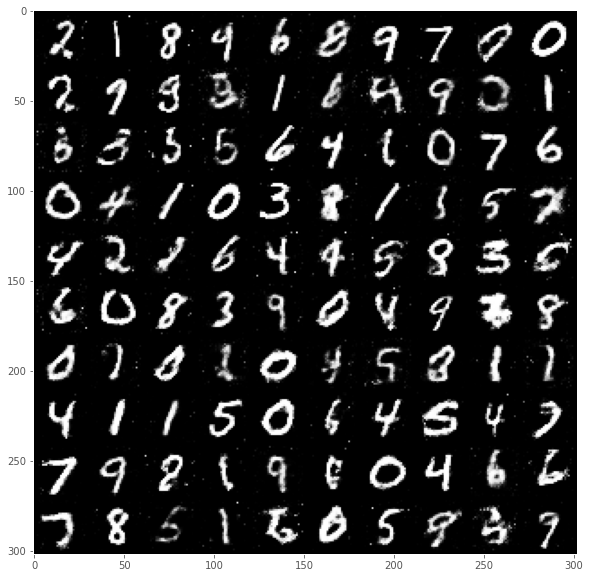

In [25]:
# show output after epochs training
plt.figure(figsize=(12, 12))
plt.grid(False)
plt.imshow(np.asarray(Image.open(os.path.join(sample_dir, "fake_images-0300.png"))))

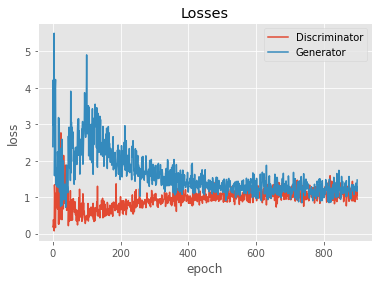

In [20]:
# show the discrimator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

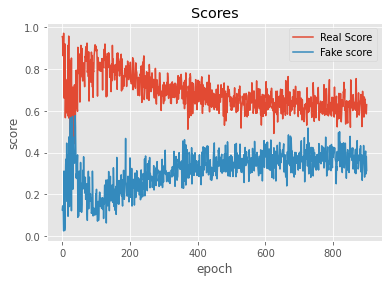

In [21]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");

## 2. DCGAN

*Source: <a href="https://arxiv.org/pdf/1511.06434v2.pdf" target="_blank">Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015)</a>.*

The goal of this part is to enhance your results achieved in the part one with DCGAN. Feel free to reuse your code, improve architecture or training scheme, etc.

In [74]:
class CFG:
    batch_size = 128
    num_epochs = 300
    workers = 4
    seed = 2021
    image_size = 64
    download = True
    dataroot = "data"
    nc = 3  ## number of chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    sample_dir = "./images/"


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

Files already downloaded and verified


Label:  6


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-0.8745098 , -0.8112418 , -0.74797386, -0.68470585, -0.6214379 ,
        -0.5581699 , -0.49490196, -0.43163398, -0.36836597, -0.305098  ,
        -0.24183004, -0.17856206, -0.11529408, -0.0520261 ,  0.01124188,
         0.07450986], dtype=float32),
 <a list of 300 BarContainer objects>)

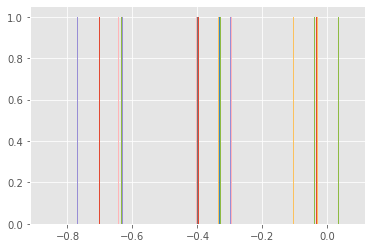

In [27]:
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [28]:
img.shape

torch.Size([3, 64, 64])

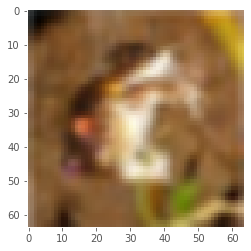

In [30]:
# unnormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
    max_value = 1.
    
    return (x + max_value) / 2
    
# show  image sample with matplotlib

plt.grid(False)
plt.imshow(denorm(img).transpose(0, -1).numpy())

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.06274509, 0.09437908, 0.12601307, 0.15764706, 0.18928105,
        0.22091503, 0.25254902, 0.28418303, 0.315817  , 0.347451  ,
        0.37908497, 0.41071898, 0.44235295, 0.47398695, 0.50562096,
        0.5372549 ], dtype=float32),
 <a list of 300 BarContainer objects>)

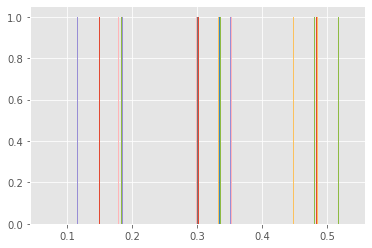

In [31]:
plt.hist(denorm(img)[:, 5:15, 5:15].flatten(), bins=15)

In [103]:
# create the dataloader
dataloader = DataLoader(
    cifar_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=4,
    drop_last=True
)

### DCGAN implementation

In [104]:
class DCGenerator(nn.Module):
    def __init__(self, nc, nz, ngf):
        # ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu
        # ConvTranspose2d - BatchNorm - Relu - ConvTranspose2d - Tanh
        super(DCGenerator, self).__init__()
        ##
        
        self.block_1 = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
        )
        
        self.block_2 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
        )
        
        self.block_3 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
        )
        
        self.block_4 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
        )
        
        self.block_5 = nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False)
        

    def forward(self, x):
        ##
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        return F.tanh(x)


class DCDiscriminator(nn.Module):
    def __init__(self, nc, ndf):
        # conv2d - leaky - conv2d - batchnorm - leaky - conv2d - batchnorm - leaky - conv - batchnorm - leaky - conv2d
        super(DCDiscriminator, self).__init__()
        ##
        self.block_1 = nn.Sequential(
            nn.Conv2d(nc, ndf, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.block_2 = nn.Sequential(
            nn.Conv2d(ndf, ndf * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.block_3 = nn.Sequential(
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.block_4 = nn.Sequential(
            nn.Conv2d(ndf * 4, ndf * 8, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.block_5 = nn.Conv2d(ndf * 8, 1, 4, 1, 0)

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        return F.sigmoid(x)

In [121]:
# create new Generator model
# create new Discriminator model


DCG = DCGenerator(CFG.nc, CFG.nz, CFG.ngf).to(device)
DCD = DCDiscriminator(CFG.nc, CFG.ndf).to(device)

In [122]:
# show the output of model
y = DCG(torch.randn(2, CFG.nz, 1, 1).to(device))

In [123]:
y.shape

torch.Size([2, 3, 64, 64])

In [124]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()
## Define the optimizer for generator and discrimator

G_optimizer = torch.optim.AdamW(DCG.parameters(), lr=CFG.lr)
D_optimizer = torch.optim.AdamW(DCD.parameters(), lr=CFG.lr)

In [125]:
# feel free to reuse your training functions
def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    G_optimizer.zero_grad()
    D_optimizer.zero_grad()

def train_discriminator(D_model, G_model, images):
  
    # Create the labels which are later used as input for the BCE loss
    real_labels = Variable(torch.ones(CFG.batch_size, 1).to(device))
    fake_labels = Variable(torch.zeros(CFG.batch_size, 1).to(device))
        
    
    outputs = D_model(images)
    # Loss for real images
    
    real_score = outputs.squeeze().unsqueeze(1)

    # Loss for fake images
    z = Variable(torch.randn(CFG.batch_size, CFG.nz, 1, 1).to(device))
    fake_images = G_model(z)
    outputs = D_model(fake_images)

    fake_score = outputs.squeeze().unsqueeze(1)

    # Sum losses
    real_loss = criterion(real_score, real_labels)
    fake_loss = criterion(fake_score, fake_labels)
    
    d_loss = real_loss + fake_loss

    # Reset gradients
    reset_grad()

    # Compute gradients
    d_loss.backward()

    # Adjust the parameters using backprop
    D_optimizer.step()
    
    return d_loss, real_score, fake_score

def train_generator(G_model, D_model):
    # Generate fake images and calculate loss
    # z = torch.randn(batch_size, latent_size).to(device)
    z = Variable(torch.Tensor(np.random.normal(0, 1, (CFG.batch_size, CFG.nz, 1, 1))).to(device))
    fake_images = G_model(z)
    labels = torch.ones(batch_size, 1).to(device)
    # calculate the generator loss
    
    g_loss = criterion(D_model(fake_images).squeeze().unsqueeze(1), labels)

    # Reset gradients
    reset_grad()

    # Backprop and optimize
    g_loss.backward()
    
    G_optimizer.step()
    

    return g_loss, fake_images

### Start the training proccess

In [126]:
def save_fake_images_cifar(DCG_model, index):
    sample_vectors = torch.randn(CFG.batch_size, CFG.nz, 1, 1).to(CFG.device)
    fake_images = DCG_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(
        denorm(fake_images), os.path.join(CFG.sample_dir, fake_fname), nrow=10
    )

In [127]:
%%time
device = CFG.device
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size

total_step = len(dataloader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
DCG.to(device)
DCD.to(device)

for epoch in tqdm(range(num_epochs)):
    for i, (images, _) in enumerate(dataloader):
        # Load a batch & transform to vectors
        images = Variable(images.to(device))

        # Train the discriminator
        if (i + 1) % 2 == 0:
            d_loss, real_score, fake_score = train_discriminator(DCD, DCG, images)

        # Train the generator
        g_loss, fake_images = train_generator(DCG, DCD)
        

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_cifar(DCG, epoch + 1)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [0/300], Step [200/390], d_loss: 0.5420, g_loss: 6.1778, D(x): 0.79, D(G(z)): 0.21


  0%|          | 1/300 [00:29<2:25:37, 29.22s/it]

Saving fake_images-0001.png
Epoch [1/300], Step [200/390], d_loss: 0.2914, g_loss: 3.9935, D(x): 0.88, D(G(z)): 0.11


  1%|          | 2/300 [00:53<2:11:10, 26.41s/it]

Saving fake_images-0002.png
Epoch [2/300], Step [200/390], d_loss: 0.6277, g_loss: 4.7743, D(x): 0.88, D(G(z)): 0.35


  1%|          | 3/300 [01:25<2:23:27, 28.98s/it]

Saving fake_images-0003.png
Epoch [3/300], Step [200/390], d_loss: 0.4752, g_loss: 3.2019, D(x): 0.80, D(G(z)): 0.10


  1%|▏         | 4/300 [02:01<2:36:49, 31.79s/it]

Saving fake_images-0004.png
Epoch [4/300], Step [200/390], d_loss: 0.8564, g_loss: 2.2290, D(x): 0.68, D(G(z)): 0.26


  2%|▏         | 5/300 [02:26<2:23:31, 29.19s/it]

Saving fake_images-0005.png
Epoch [5/300], Step [200/390], d_loss: 1.6245, g_loss: 3.1766, D(x): 0.65, D(G(z)): 0.35


  2%|▏         | 6/300 [03:02<2:34:51, 31.60s/it]

Saving fake_images-0006.png
Epoch [6/300], Step [200/390], d_loss: 0.6571, g_loss: 3.2846, D(x): 0.72, D(G(z)): 0.11


  2%|▏         | 7/300 [03:30<2:29:04, 30.53s/it]

Saving fake_images-0007.png
Epoch [7/300], Step [200/390], d_loss: 0.7232, g_loss: 3.1415, D(x): 0.69, D(G(z)): 0.16


  3%|▎         | 8/300 [03:54<2:18:21, 28.43s/it]

Saving fake_images-0008.png
Epoch [8/300], Step [200/390], d_loss: 0.1543, g_loss: 4.4076, D(x): 0.95, D(G(z)): 0.07


  3%|▎         | 9/300 [04:23<2:18:28, 28.55s/it]

Saving fake_images-0009.png
Epoch [9/300], Step [200/390], d_loss: 1.0639, g_loss: 3.4438, D(x): 0.55, D(G(z)): 0.09


  3%|▎         | 10/300 [04:49<2:13:53, 27.70s/it]

Saving fake_images-0010.png
Epoch [10/300], Step [200/390], d_loss: 0.6716, g_loss: 3.4058, D(x): 0.76, D(G(z)): 0.16


  4%|▎         | 11/300 [05:07<1:58:56, 24.69s/it]

Saving fake_images-0011.png
Epoch [11/300], Step [200/390], d_loss: 0.2411, g_loss: 3.3494, D(x): 0.89, D(G(z)): 0.09


  4%|▍         | 12/300 [05:25<1:48:34, 22.62s/it]

Saving fake_images-0012.png
Epoch [12/300], Step [200/390], d_loss: 0.4149, g_loss: 4.7690, D(x): 0.84, D(G(z)): 0.14


  4%|▍         | 13/300 [05:43<1:41:15, 21.17s/it]

Saving fake_images-0013.png
Epoch [13/300], Step [200/390], d_loss: 0.3157, g_loss: 4.4976, D(x): 0.90, D(G(z)): 0.13


  5%|▍         | 14/300 [06:00<1:36:07, 20.17s/it]

Saving fake_images-0014.png
Epoch [14/300], Step [200/390], d_loss: 0.8222, g_loss: 2.3756, D(x): 0.81, D(G(z)): 0.35


  5%|▌         | 15/300 [06:18<1:32:27, 19.46s/it]

Saving fake_images-0015.png
Epoch [15/300], Step [200/390], d_loss: 0.8238, g_loss: 2.8737, D(x): 0.75, D(G(z)): 0.29


  5%|▌         | 16/300 [06:36<1:29:49, 18.98s/it]

Saving fake_images-0016.png
Epoch [16/300], Step [200/390], d_loss: 0.2621, g_loss: 3.5797, D(x): 0.88, D(G(z)): 0.08


  6%|▌         | 17/300 [06:54<1:27:52, 18.63s/it]

Saving fake_images-0017.png
Epoch [17/300], Step [200/390], d_loss: 0.4896, g_loss: 3.3476, D(x): 0.75, D(G(z)): 0.10


  6%|▌         | 18/300 [07:12<1:26:27, 18.40s/it]

Saving fake_images-0018.png
Epoch [18/300], Step [200/390], d_loss: 0.8456, g_loss: 3.4140, D(x): 0.68, D(G(z)): 0.16


  6%|▋         | 19/300 [07:30<1:25:20, 18.22s/it]

Saving fake_images-0019.png
Epoch [19/300], Step [200/390], d_loss: 0.2538, g_loss: 4.5445, D(x): 0.93, D(G(z)): 0.12


  7%|▋         | 20/300 [07:48<1:24:32, 18.12s/it]

Saving fake_images-0020.png
Epoch [20/300], Step [200/390], d_loss: 0.5742, g_loss: 2.5924, D(x): 0.76, D(G(z)): 0.16


  7%|▋         | 21/300 [08:05<1:23:53, 18.04s/it]

Saving fake_images-0021.png
Epoch [21/300], Step [200/390], d_loss: 0.5742, g_loss: 3.0296, D(x): 0.81, D(G(z)): 0.23


  7%|▋         | 22/300 [08:23<1:23:22, 17.99s/it]

Saving fake_images-0022.png
Epoch [22/300], Step [200/390], d_loss: 0.1426, g_loss: 3.7802, D(x): 0.94, D(G(z)): 0.07


  8%|▊         | 23/300 [08:41<1:22:44, 17.92s/it]

Saving fake_images-0023.png
Epoch [23/300], Step [200/390], d_loss: 0.9157, g_loss: 2.0903, D(x): 0.84, D(G(z)): 0.42


  8%|▊         | 24/300 [08:59<1:22:22, 17.91s/it]

Saving fake_images-0024.png
Epoch [24/300], Step [200/390], d_loss: 0.9298, g_loss: 1.9375, D(x): 0.68, D(G(z)): 0.24


  8%|▊         | 25/300 [09:17<1:21:57, 17.88s/it]

Saving fake_images-0025.png
Epoch [25/300], Step [200/390], d_loss: 0.4408, g_loss: 2.7874, D(x): 0.80, D(G(z)): 0.11


  9%|▊         | 26/300 [09:35<1:21:42, 17.89s/it]

Saving fake_images-0026.png
Epoch [26/300], Step [200/390], d_loss: 0.4510, g_loss: 3.4653, D(x): 0.84, D(G(z)): 0.15


  9%|▉         | 27/300 [09:52<1:21:22, 17.89s/it]

Saving fake_images-0027.png
Epoch [27/300], Step [200/390], d_loss: 0.3723, g_loss: 4.1923, D(x): 0.87, D(G(z)): 0.13


  9%|▉         | 28/300 [10:10<1:21:10, 17.91s/it]

Saving fake_images-0028.png
Epoch [28/300], Step [200/390], d_loss: 0.8214, g_loss: 2.4543, D(x): 0.76, D(G(z)): 0.33


 10%|▉         | 29/300 [10:28<1:20:53, 17.91s/it]

Saving fake_images-0029.png
Epoch [29/300], Step [200/390], d_loss: 0.4107, g_loss: 3.5495, D(x): 0.83, D(G(z)): 0.14


 10%|█         | 30/300 [10:46<1:20:34, 17.91s/it]

Saving fake_images-0030.png
Epoch [30/300], Step [200/390], d_loss: 0.4826, g_loss: 2.7936, D(x): 0.91, D(G(z)): 0.25


 10%|█         | 31/300 [11:04<1:20:13, 17.89s/it]

Saving fake_images-0031.png
Epoch [31/300], Step [200/390], d_loss: 0.5765, g_loss: 2.8284, D(x): 0.82, D(G(z)): 0.23


 11%|█         | 32/300 [11:22<1:19:59, 17.91s/it]

Saving fake_images-0032.png
Epoch [32/300], Step [200/390], d_loss: 0.5322, g_loss: 2.4513, D(x): 0.88, D(G(z)): 0.27


 11%|█         | 33/300 [11:40<1:19:34, 17.88s/it]

Saving fake_images-0033.png
Epoch [33/300], Step [200/390], d_loss: 0.3209, g_loss: 3.7903, D(x): 0.86, D(G(z)): 0.10


 11%|█▏        | 34/300 [11:58<1:19:21, 17.90s/it]

Saving fake_images-0034.png
Epoch [34/300], Step [200/390], d_loss: 0.4702, g_loss: 2.1628, D(x): 0.84, D(G(z)): 0.18


 12%|█▏        | 35/300 [12:16<1:19:04, 17.90s/it]

Saving fake_images-0035.png
Epoch [35/300], Step [200/390], d_loss: 0.8187, g_loss: 2.6509, D(x): 0.84, D(G(z)): 0.35


 12%|█▏        | 36/300 [12:34<1:18:42, 17.89s/it]

Saving fake_images-0036.png
Epoch [36/300], Step [200/390], d_loss: 0.7683, g_loss: 2.2199, D(x): 0.76, D(G(z)): 0.29


 12%|█▏        | 37/300 [12:51<1:18:22, 17.88s/it]

Saving fake_images-0037.png
Epoch [37/300], Step [200/390], d_loss: 0.6403, g_loss: 2.8992, D(x): 0.88, D(G(z)): 0.34


 13%|█▎        | 38/300 [13:09<1:18:02, 17.87s/it]

Saving fake_images-0038.png
Epoch [38/300], Step [200/390], d_loss: 1.0751, g_loss: 2.6282, D(x): 0.59, D(G(z)): 0.20


 13%|█▎        | 39/300 [13:27<1:17:44, 17.87s/it]

Saving fake_images-0039.png
Epoch [39/300], Step [200/390], d_loss: 0.7159, g_loss: 2.3234, D(x): 0.74, D(G(z)): 0.24


 13%|█▎        | 40/300 [13:45<1:17:25, 17.87s/it]

Saving fake_images-0040.png
Epoch [40/300], Step [200/390], d_loss: 0.8726, g_loss: 2.8869, D(x): 0.69, D(G(z)): 0.28


 14%|█▎        | 41/300 [14:03<1:17:08, 17.87s/it]

Saving fake_images-0041.png
Epoch [41/300], Step [200/390], d_loss: 0.8128, g_loss: 2.7503, D(x): 0.64, D(G(z)): 0.18


 14%|█▍        | 42/300 [14:21<1:16:56, 17.89s/it]

Saving fake_images-0042.png
Epoch [42/300], Step [200/390], d_loss: 0.6527, g_loss: 3.2555, D(x): 0.82, D(G(z)): 0.25


 14%|█▍        | 43/300 [14:39<1:16:45, 17.92s/it]

Saving fake_images-0043.png
Epoch [43/300], Step [200/390], d_loss: 0.5259, g_loss: 2.2641, D(x): 0.82, D(G(z)): 0.19


 15%|█▍        | 44/300 [14:57<1:16:24, 17.91s/it]

Saving fake_images-0044.png
Epoch [44/300], Step [200/390], d_loss: 0.7931, g_loss: 2.3520, D(x): 0.78, D(G(z)): 0.34


 15%|█▌        | 45/300 [15:15<1:16:07, 17.91s/it]

Saving fake_images-0045.png
Epoch [45/300], Step [200/390], d_loss: 0.2427, g_loss: 3.8117, D(x): 0.89, D(G(z)): 0.09


 15%|█▌        | 46/300 [15:33<1:15:49, 17.91s/it]

Saving fake_images-0046.png
Epoch [46/300], Step [200/390], d_loss: 0.8386, g_loss: 2.7201, D(x): 0.68, D(G(z)): 0.25


 16%|█▌        | 47/300 [15:50<1:15:31, 17.91s/it]

Saving fake_images-0047.png
Epoch [47/300], Step [200/390], d_loss: 0.5007, g_loss: 3.2256, D(x): 0.85, D(G(z)): 0.22


 16%|█▌        | 48/300 [16:08<1:15:11, 17.90s/it]

Saving fake_images-0048.png
Epoch [48/300], Step [200/390], d_loss: 0.9738, g_loss: 2.6948, D(x): 0.66, D(G(z)): 0.32


 16%|█▋        | 49/300 [16:26<1:14:55, 17.91s/it]

Saving fake_images-0049.png
Epoch [49/300], Step [200/390], d_loss: 0.4242, g_loss: 3.7861, D(x): 0.81, D(G(z)): 0.14


 17%|█▋        | 50/300 [16:44<1:14:36, 17.91s/it]

Saving fake_images-0050.png
Epoch [50/300], Step [200/390], d_loss: 0.6004, g_loss: 5.6254, D(x): 0.68, D(G(z)): 0.02


 17%|█▋        | 51/300 [17:02<1:14:18, 17.90s/it]

Saving fake_images-0051.png
Epoch [51/300], Step [200/390], d_loss: 0.4804, g_loss: 2.8203, D(x): 0.82, D(G(z)): 0.17


 17%|█▋        | 52/300 [17:20<1:14:07, 17.93s/it]

Saving fake_images-0052.png
Epoch [52/300], Step [200/390], d_loss: 0.8453, g_loss: 2.5748, D(x): 0.82, D(G(z)): 0.38


 18%|█▊        | 53/300 [17:38<1:13:50, 17.94s/it]

Saving fake_images-0053.png
Epoch [53/300], Step [200/390], d_loss: 0.6287, g_loss: 2.7377, D(x): 0.94, D(G(z)): 0.36


 18%|█▊        | 54/300 [17:56<1:13:35, 17.95s/it]

Saving fake_images-0054.png
Epoch [54/300], Step [200/390], d_loss: 0.4639, g_loss: 3.3020, D(x): 0.87, D(G(z)): 0.21


 18%|█▊        | 55/300 [18:14<1:13:17, 17.95s/it]

Saving fake_images-0055.png
Epoch [55/300], Step [200/390], d_loss: 0.7573, g_loss: 2.6908, D(x): 0.60, D(G(z)): 0.10
Saving fake_images-0056.png


 19%|█▊        | 56/300 [18:32<1:12:58, 17.94s/it]

Epoch [56/300], Step [200/390], d_loss: 0.5901, g_loss: 2.3633, D(x): 0.80, D(G(z)): 0.25
Saving fake_images-0057.png


 19%|█▉        | 57/300 [18:50<1:12:39, 17.94s/it]

Epoch [57/300], Step [200/390], d_loss: 0.5038, g_loss: 3.5917, D(x): 0.75, D(G(z)): 0.10
Saving fake_images-0058.png


 19%|█▉        | 58/300 [19:08<1:12:24, 17.95s/it]

Epoch [58/300], Step [200/390], d_loss: 0.0920, g_loss: 4.8392, D(x): 0.99, D(G(z)): 0.07


 20%|█▉        | 59/300 [19:26<1:12:05, 17.95s/it]

Saving fake_images-0059.png
Epoch [59/300], Step [200/390], d_loss: 0.4879, g_loss: 3.1680, D(x): 0.94, D(G(z)): 0.30


 20%|██        | 60/300 [19:44<1:11:49, 17.96s/it]

Saving fake_images-0060.png
Epoch [60/300], Step [200/390], d_loss: 0.3913, g_loss: 2.6990, D(x): 0.82, D(G(z)): 0.12
Saving fake_images-0061.png


 20%|██        | 61/300 [20:02<1:11:31, 17.95s/it]

Epoch [61/300], Step [200/390], d_loss: 0.1920, g_loss: 3.8798, D(x): 0.94, D(G(z)): 0.11
Saving fake_images-0062.png


 21%|██        | 62/300 [20:20<1:11:11, 17.95s/it]

Epoch [62/300], Step [200/390], d_loss: 0.3424, g_loss: 3.9891, D(x): 0.85, D(G(z)): 0.12
Saving fake_images-0063.png


 21%|██        | 63/300 [20:38<1:10:52, 17.94s/it]

Epoch [63/300], Step [200/390], d_loss: 0.3562, g_loss: 4.2187, D(x): 0.86, D(G(z)): 0.14
Saving fake_images-0064.png


 21%|██▏       | 64/300 [20:55<1:10:34, 17.94s/it]

Epoch [64/300], Step [200/390], d_loss: 0.5080, g_loss: 3.6725, D(x): 0.78, D(G(z)): 0.16
Saving fake_images-0065.png


 22%|██▏       | 65/300 [21:13<1:10:17, 17.95s/it]

Epoch [65/300], Step [200/390], d_loss: 0.2684, g_loss: 3.3246, D(x): 0.95, D(G(z)): 0.17
Saving fake_images-0066.png


 22%|██▏       | 66/300 [21:31<1:09:59, 17.95s/it]

Epoch [66/300], Step [200/390], d_loss: 0.2372, g_loss: 3.1968, D(x): 0.90, D(G(z)): 0.09
Saving fake_images-0067.png


 22%|██▏       | 67/300 [21:49<1:09:40, 17.94s/it]

Epoch [67/300], Step [200/390], d_loss: 0.3764, g_loss: 2.9983, D(x): 0.91, D(G(z)): 0.19
Saving fake_images-0068.png


 23%|██▎       | 68/300 [22:07<1:09:25, 17.95s/it]

Epoch [68/300], Step [200/390], d_loss: 0.5806, g_loss: 3.3629, D(x): 0.66, D(G(z)): 0.06
Saving fake_images-0069.png


 23%|██▎       | 69/300 [22:25<1:09:09, 17.96s/it]

Epoch [69/300], Step [200/390], d_loss: 0.4222, g_loss: 2.5723, D(x): 0.96, D(G(z)): 0.27
Saving fake_images-0070.png


 23%|██▎       | 70/300 [22:43<1:08:52, 17.97s/it]

Epoch [70/300], Step [200/390], d_loss: 0.3964, g_loss: 3.0208, D(x): 0.93, D(G(z)): 0.23
Saving fake_images-0071.png


 24%|██▎       | 71/300 [23:01<1:08:34, 17.97s/it]

Epoch [71/300], Step [200/390], d_loss: 0.4635, g_loss: 1.1598, D(x): 0.90, D(G(z)): 0.25
Saving fake_images-0072.png


 24%|██▍       | 72/300 [23:19<1:08:16, 17.97s/it]

Epoch [72/300], Step [200/390], d_loss: 1.3885, g_loss: 3.2752, D(x): 0.39, D(G(z)): 0.04
Saving fake_images-0073.png


 24%|██▍       | 73/300 [23:37<1:08:00, 17.97s/it]

Epoch [73/300], Step [200/390], d_loss: 0.1575, g_loss: 4.7569, D(x): 0.96, D(G(z)): 0.08
Saving fake_images-0074.png


 25%|██▍       | 74/300 [23:55<1:07:41, 17.97s/it]

Epoch [74/300], Step [200/390], d_loss: 0.1126, g_loss: 5.2283, D(x): 0.95, D(G(z)): 0.05
Saving fake_images-0075.png


 25%|██▌       | 75/300 [24:13<1:07:25, 17.98s/it]

Epoch [75/300], Step [200/390], d_loss: 0.6628, g_loss: 3.8180, D(x): 0.75, D(G(z)): 0.15


 25%|██▌       | 76/300 [24:31<1:06:59, 17.95s/it]

Saving fake_images-0076.png
Epoch [76/300], Step [200/390], d_loss: 0.6823, g_loss: 2.6536, D(x): 0.76, D(G(z)): 0.22
Saving fake_images-0077.png


 26%|██▌       | 77/300 [24:49<1:06:46, 17.96s/it]

Epoch [77/300], Step [200/390], d_loss: 0.7788, g_loss: 1.2800, D(x): 0.75, D(G(z)): 0.29
Saving fake_images-0078.png


 26%|██▌       | 78/300 [25:07<1:06:27, 17.96s/it]

Epoch [78/300], Step [200/390], d_loss: 0.1346, g_loss: 6.2372, D(x): 0.90, D(G(z)): 0.02
Saving fake_images-0079.png


 26%|██▋       | 79/300 [25:25<1:06:06, 17.95s/it]

Epoch [79/300], Step [200/390], d_loss: 0.5849, g_loss: 4.5714, D(x): 0.68, D(G(z)): 0.09
Saving fake_images-0080.png


 27%|██▋       | 80/300 [25:43<1:05:53, 17.97s/it]

Epoch [80/300], Step [200/390], d_loss: 0.8369, g_loss: 1.6657, D(x): 0.63, D(G(z)): 0.19
Saving fake_images-0081.png


 27%|██▋       | 81/300 [26:01<1:05:39, 17.99s/it]

Epoch [81/300], Step [200/390], d_loss: 0.4561, g_loss: 3.0862, D(x): 0.97, D(G(z)): 0.28
Saving fake_images-0082.png


 27%|██▋       | 82/300 [26:19<1:05:22, 17.99s/it]

Epoch [82/300], Step [200/390], d_loss: 0.6987, g_loss: 3.3719, D(x): 0.71, D(G(z)): 0.12
Saving fake_images-0083.png


 28%|██▊       | 83/300 [26:37<1:05:03, 17.99s/it]

Epoch [83/300], Step [200/390], d_loss: 1.0070, g_loss: 2.2768, D(x): 0.66, D(G(z)): 0.26
Saving fake_images-0084.png


 28%|██▊       | 84/300 [26:55<1:04:47, 18.00s/it]

Epoch [84/300], Step [200/390], d_loss: 1.6389, g_loss: 2.5553, D(x): 0.42, D(G(z)): 0.21
Saving fake_images-0085.png


 28%|██▊       | 85/300 [27:13<1:04:28, 17.99s/it]

Epoch [85/300], Step [200/390], d_loss: 0.4879, g_loss: 3.3309, D(x): 0.86, D(G(z)): 0.22


 29%|██▊       | 86/300 [27:31<1:04:08, 17.98s/it]

Saving fake_images-0086.png
Epoch [86/300], Step [200/390], d_loss: 0.7746, g_loss: 3.4452, D(x): 0.69, D(G(z)): 0.19
Saving fake_images-0087.png


 29%|██▉       | 87/300 [27:49<1:03:50, 17.98s/it]

Epoch [87/300], Step [200/390], d_loss: 0.3992, g_loss: 2.7924, D(x): 0.86, D(G(z)): 0.18
Saving fake_images-0088.png


 29%|██▉       | 88/300 [28:07<1:03:30, 17.97s/it]

Epoch [88/300], Step [200/390], d_loss: 0.3711, g_loss: 2.9773, D(x): 0.87, D(G(z)): 0.16
Saving fake_images-0089.png


 30%|██▉       | 89/300 [28:25<1:03:13, 17.98s/it]

Epoch [89/300], Step [200/390], d_loss: 0.5686, g_loss: 1.8723, D(x): 0.85, D(G(z)): 0.26
Saving fake_images-0090.png


 30%|███       | 90/300 [28:43<1:02:54, 17.97s/it]

Epoch [90/300], Step [200/390], d_loss: 0.9980, g_loss: 5.3981, D(x): 0.50, D(G(z)): 0.06
Saving fake_images-0091.png


 30%|███       | 91/300 [29:01<1:02:37, 17.98s/it]

Epoch [91/300], Step [200/390], d_loss: 1.4143, g_loss: 1.5571, D(x): 0.58, D(G(z)): 0.34
Saving fake_images-0092.png


 31%|███       | 92/300 [29:19<1:02:16, 17.96s/it]

Epoch [92/300], Step [200/390], d_loss: 1.2022, g_loss: 1.8329, D(x): 0.77, D(G(z)): 0.49
Saving fake_images-0093.png


 31%|███       | 93/300 [29:37<1:01:55, 17.95s/it]

Epoch [93/300], Step [200/390], d_loss: 0.7434, g_loss: 3.5054, D(x): 0.79, D(G(z)): 0.30
Saving fake_images-0094.png


 31%|███▏      | 94/300 [29:55<1:01:36, 17.94s/it]

Epoch [94/300], Step [200/390], d_loss: 0.4543, g_loss: 3.1125, D(x): 0.83, D(G(z)): 0.18
Saving fake_images-0095.png


 32%|███▏      | 95/300 [30:12<1:01:17, 17.94s/it]

Epoch [95/300], Step [200/390], d_loss: 0.6930, g_loss: 2.3095, D(x): 0.73, D(G(z)): 0.22
Saving fake_images-0096.png


 32%|███▏      | 96/300 [30:30<1:01:02, 17.96s/it]

Epoch [96/300], Step [200/390], d_loss: 0.2401, g_loss: 3.8201, D(x): 0.91, D(G(z)): 0.12
Saving fake_images-0097.png


 32%|███▏      | 97/300 [30:48<1:00:44, 17.96s/it]

Epoch [97/300], Step [200/390], d_loss: 0.5379, g_loss: 3.6810, D(x): 0.79, D(G(z)): 0.16
Saving fake_images-0098.png


 33%|███▎      | 98/300 [31:06<1:00:25, 17.95s/it]

Epoch [98/300], Step [200/390], d_loss: 1.4394, g_loss: 3.1376, D(x): 0.42, D(G(z)): 0.22
Saving fake_images-0099.png


 33%|███▎      | 99/300 [31:24<1:00:07, 17.95s/it]

Epoch [99/300], Step [200/390], d_loss: 0.8660, g_loss: 1.9040, D(x): 0.60, D(G(z)): 0.14
Saving fake_images-0100.png


 33%|███▎      | 100/300 [31:42<59:46, 17.93s/it] 

Epoch [100/300], Step [200/390], d_loss: 0.9263, g_loss: 1.9816, D(x): 0.81, D(G(z)): 0.40


 34%|███▎      | 101/300 [32:00<59:26, 17.92s/it]

Saving fake_images-0101.png
Epoch [101/300], Step [200/390], d_loss: 1.1840, g_loss: 4.2325, D(x): 0.47, D(G(z)): 0.09
Saving fake_images-0102.png


 34%|███▍      | 102/300 [32:18<59:05, 17.91s/it]

Epoch [102/300], Step [200/390], d_loss: 0.6890, g_loss: 1.7269, D(x): 0.87, D(G(z)): 0.33
Saving fake_images-0103.png


 34%|███▍      | 103/300 [32:36<58:48, 17.91s/it]

Epoch [103/300], Step [200/390], d_loss: 0.9540, g_loss: 2.5759, D(x): 0.80, D(G(z)): 0.42
Saving fake_images-0104.png


 35%|███▍      | 104/300 [32:54<58:29, 17.91s/it]

Epoch [104/300], Step [200/390], d_loss: 1.3617, g_loss: 1.8091, D(x): 0.54, D(G(z)): 0.37
Saving fake_images-0105.png


 35%|███▌      | 105/300 [33:12<58:12, 17.91s/it]

Epoch [105/300], Step [200/390], d_loss: 0.4639, g_loss: 2.2855, D(x): 0.80, D(G(z)): 0.16
Saving fake_images-0106.png


 35%|███▌      | 106/300 [33:30<57:55, 17.91s/it]

Epoch [106/300], Step [200/390], d_loss: 0.4758, g_loss: 3.5871, D(x): 0.73, D(G(z)): 0.07
Saving fake_images-0107.png


 36%|███▌      | 107/300 [33:48<57:39, 17.93s/it]

Epoch [107/300], Step [200/390], d_loss: 0.8293, g_loss: 2.2361, D(x): 0.78, D(G(z)): 0.37
Saving fake_images-0108.png


 36%|███▌      | 108/300 [34:05<57:22, 17.93s/it]

Epoch [108/300], Step [200/390], d_loss: 0.6660, g_loss: 3.0932, D(x): 0.73, D(G(z)): 0.21
Saving fake_images-0109.png


 36%|███▋      | 109/300 [34:23<57:03, 17.92s/it]

Epoch [109/300], Step [200/390], d_loss: 0.8364, g_loss: 1.9185, D(x): 0.80, D(G(z)): 0.37
Saving fake_images-0110.png


 37%|███▋      | 110/300 [34:41<56:44, 17.92s/it]

Epoch [110/300], Step [200/390], d_loss: 0.7386, g_loss: 2.2774, D(x): 0.83, D(G(z)): 0.36
Saving fake_images-0111.png


 37%|███▋      | 111/300 [34:59<56:29, 17.93s/it]

Epoch [111/300], Step [200/390], d_loss: 0.8213, g_loss: 2.3658, D(x): 0.74, D(G(z)): 0.32
Saving fake_images-0112.png


 37%|███▋      | 112/300 [35:17<56:10, 17.93s/it]

Epoch [112/300], Step [200/390], d_loss: 0.5060, g_loss: 2.4492, D(x): 0.77, D(G(z)): 0.15
Saving fake_images-0113.png


 38%|███▊      | 113/300 [35:35<55:52, 17.93s/it]

Epoch [113/300], Step [200/390], d_loss: 1.3880, g_loss: 1.5654, D(x): 0.66, D(G(z)): 0.50
Saving fake_images-0114.png


 38%|███▊      | 114/300 [35:53<55:37, 17.94s/it]

Epoch [114/300], Step [200/390], d_loss: 0.3873, g_loss: 4.7222, D(x): 0.78, D(G(z)): 0.09
Saving fake_images-0115.png


 38%|███▊      | 115/300 [36:11<55:17, 17.93s/it]

Epoch [115/300], Step [200/390], d_loss: 0.8454, g_loss: 1.1821, D(x): 0.67, D(G(z)): 0.26
Saving fake_images-0116.png


 39%|███▊      | 116/300 [36:29<55:01, 17.94s/it]

Epoch [116/300], Step [200/390], d_loss: 0.8869, g_loss: 1.8828, D(x): 0.62, D(G(z)): 0.22
Saving fake_images-0117.png


 39%|███▉      | 117/300 [36:47<54:41, 17.93s/it]

Epoch [117/300], Step [200/390], d_loss: 0.5872, g_loss: 3.7666, D(x): 0.74, D(G(z)): 0.15
Saving fake_images-0118.png


 39%|███▉      | 118/300 [37:05<54:25, 17.94s/it]

Epoch [118/300], Step [200/390], d_loss: 0.8213, g_loss: 1.8991, D(x): 0.70, D(G(z)): 0.30
Saving fake_images-0119.png


 40%|███▉      | 119/300 [37:23<54:09, 17.95s/it]

Epoch [119/300], Step [200/390], d_loss: 0.6307, g_loss: 2.4381, D(x): 0.66, D(G(z)): 0.12
Saving fake_images-0120.png


 40%|████      | 120/300 [37:41<53:51, 17.95s/it]

Epoch [120/300], Step [200/390], d_loss: 0.3890, g_loss: 2.2558, D(x): 0.85, D(G(z)): 0.17
Saving fake_images-0121.png


 40%|████      | 121/300 [37:59<53:34, 17.96s/it]

Epoch [121/300], Step [200/390], d_loss: 0.6838, g_loss: 2.1406, D(x): 0.79, D(G(z)): 0.28
Saving fake_images-0122.png


 41%|████      | 122/300 [38:17<53:14, 17.95s/it]

Epoch [122/300], Step [200/390], d_loss: 0.6816, g_loss: 3.0234, D(x): 0.74, D(G(z)): 0.22
Saving fake_images-0123.png


 41%|████      | 123/300 [38:35<52:55, 17.94s/it]

Epoch [123/300], Step [200/390], d_loss: 0.8301, g_loss: 2.4409, D(x): 0.81, D(G(z)): 0.38
Saving fake_images-0124.png


 41%|████▏     | 124/300 [38:53<52:37, 17.94s/it]

Epoch [124/300], Step [200/390], d_loss: 1.0859, g_loss: 2.5047, D(x): 0.55, D(G(z)): 0.24
Saving fake_images-0125.png


 42%|████▏     | 125/300 [39:10<52:20, 17.94s/it]

Epoch [125/300], Step [200/390], d_loss: 0.5999, g_loss: 3.2942, D(x): 0.69, D(G(z)): 0.14
Saving fake_images-0126.png


 42%|████▏     | 126/300 [39:28<52:01, 17.94s/it]

Epoch [126/300], Step [200/390], d_loss: 1.1954, g_loss: 2.5268, D(x): 0.66, D(G(z)): 0.41
Saving fake_images-0127.png


 42%|████▏     | 127/300 [39:46<51:43, 17.94s/it]

Epoch [127/300], Step [200/390], d_loss: 0.7178, g_loss: 2.6690, D(x): 0.61, D(G(z)): 0.13
Saving fake_images-0128.png


 43%|████▎     | 128/300 [40:04<51:28, 17.96s/it]

Epoch [128/300], Step [200/390], d_loss: 0.6127, g_loss: 1.8601, D(x): 0.70, D(G(z)): 0.16
Saving fake_images-0129.png


 43%|████▎     | 129/300 [40:22<51:11, 17.96s/it]

Epoch [129/300], Step [200/390], d_loss: 0.4629, g_loss: 3.3454, D(x): 0.85, D(G(z)): 0.20
Saving fake_images-0130.png


 43%|████▎     | 130/300 [40:40<50:53, 17.96s/it]

Epoch [130/300], Step [200/390], d_loss: 0.2747, g_loss: 2.7979, D(x): 0.87, D(G(z)): 0.11
Saving fake_images-0131.png


 44%|████▎     | 131/300 [40:58<50:32, 17.95s/it]

Epoch [131/300], Step [200/390], d_loss: 0.8017, g_loss: 2.1918, D(x): 0.71, D(G(z)): 0.28
Saving fake_images-0132.png


 44%|████▍     | 132/300 [41:16<50:15, 17.95s/it]

Epoch [132/300], Step [200/390], d_loss: 0.2928, g_loss: 3.3240, D(x): 0.93, D(G(z)): 0.16
Saving fake_images-0133.png


 44%|████▍     | 133/300 [41:34<49:56, 17.94s/it]

Epoch [133/300], Step [200/390], d_loss: 0.2775, g_loss: 4.4061, D(x): 0.84, D(G(z)): 0.07
Saving fake_images-0134.png


 45%|████▍     | 134/300 [41:52<49:37, 17.94s/it]

Epoch [134/300], Step [200/390], d_loss: 0.9560, g_loss: 2.4489, D(x): 0.64, D(G(z)): 0.28
Saving fake_images-0135.png


 45%|████▌     | 135/300 [42:10<49:18, 17.93s/it]

Epoch [135/300], Step [200/390], d_loss: 0.3972, g_loss: 2.9103, D(x): 0.83, D(G(z)): 0.14
Saving fake_images-0136.png


 45%|████▌     | 136/300 [42:28<48:59, 17.92s/it]

Epoch [136/300], Step [200/390], d_loss: 0.3652, g_loss: 2.1909, D(x): 0.80, D(G(z)): 0.09
Saving fake_images-0137.png


 46%|████▌     | 137/300 [42:46<48:42, 17.93s/it]

Epoch [137/300], Step [200/390], d_loss: 0.3100, g_loss: 2.2620, D(x): 0.90, D(G(z)): 0.16
Saving fake_images-0138.png


 46%|████▌     | 138/300 [43:04<48:22, 17.92s/it]

Epoch [138/300], Step [200/390], d_loss: 0.4465, g_loss: 2.8220, D(x): 0.71, D(G(z)): 0.05
Saving fake_images-0139.png


 46%|████▋     | 139/300 [43:22<48:08, 17.94s/it]

Epoch [139/300], Step [200/390], d_loss: 0.9224, g_loss: 1.8325, D(x): 0.55, D(G(z)): 0.16
Saving fake_images-0140.png


 47%|████▋     | 140/300 [43:40<47:49, 17.94s/it]

Epoch [140/300], Step [200/390], d_loss: 1.5763, g_loss: 2.4537, D(x): 0.37, D(G(z)): 0.24
Saving fake_images-0141.png


 47%|████▋     | 141/300 [43:58<47:33, 17.94s/it]

Epoch [141/300], Step [200/390], d_loss: 0.9957, g_loss: 2.5854, D(x): 0.80, D(G(z)): 0.38
Saving fake_images-0142.png


 47%|████▋     | 142/300 [44:15<47:12, 17.92s/it]

Epoch [142/300], Step [200/390], d_loss: 1.7833, g_loss: 2.2452, D(x): 0.35, D(G(z)): 0.23
Saving fake_images-0143.png


 48%|████▊     | 143/300 [44:33<46:53, 17.92s/it]

Epoch [143/300], Step [200/390], d_loss: 1.4186, g_loss: 1.6591, D(x): 0.69, D(G(z)): 0.54
Saving fake_images-0144.png


 48%|████▊     | 144/300 [44:51<46:35, 17.92s/it]

Epoch [144/300], Step [200/390], d_loss: 1.2919, g_loss: 0.8225, D(x): 0.67, D(G(z)): 0.47
Saving fake_images-0145.png


 48%|████▊     | 145/300 [45:09<46:19, 17.93s/it]

Epoch [145/300], Step [200/390], d_loss: 0.4983, g_loss: 3.9649, D(x): 0.82, D(G(z)): 0.20
Saving fake_images-0146.png


 49%|████▊     | 146/300 [45:27<46:01, 17.93s/it]

Epoch [146/300], Step [200/390], d_loss: 0.7333, g_loss: 2.2385, D(x): 0.87, D(G(z)): 0.37
Saving fake_images-0147.png


 49%|████▉     | 147/300 [45:45<45:45, 17.94s/it]

Epoch [147/300], Step [200/390], d_loss: 0.3813, g_loss: 3.1841, D(x): 0.87, D(G(z)): 0.18
Saving fake_images-0148.png


 49%|████▉     | 148/300 [46:03<45:28, 17.95s/it]

Epoch [148/300], Step [200/390], d_loss: 0.6706, g_loss: 2.6405, D(x): 0.66, D(G(z)): 0.15
Saving fake_images-0149.png


 50%|████▉     | 149/300 [46:21<45:09, 17.95s/it]

Epoch [149/300], Step [200/390], d_loss: 1.2583, g_loss: 1.6446, D(x): 0.47, D(G(z)): 0.23
Saving fake_images-0150.png


 50%|█████     | 150/300 [46:39<44:50, 17.93s/it]

Epoch [150/300], Step [200/390], d_loss: 0.6201, g_loss: 3.1184, D(x): 0.69, D(G(z)): 0.13
Saving fake_images-0151.png


 50%|█████     | 151/300 [46:57<44:33, 17.94s/it]

Epoch [151/300], Step [200/390], d_loss: 0.8542, g_loss: 1.9702, D(x): 0.80, D(G(z)): 0.36
Saving fake_images-0152.png


 51%|█████     | 152/300 [47:15<44:13, 17.93s/it]

Epoch [152/300], Step [200/390], d_loss: 0.3011, g_loss: 2.7243, D(x): 0.92, D(G(z)): 0.18
Saving fake_images-0153.png


 51%|█████     | 153/300 [47:33<43:56, 17.94s/it]

Epoch [153/300], Step [200/390], d_loss: 0.2076, g_loss: 2.2487, D(x): 0.90, D(G(z)): 0.08
Saving fake_images-0154.png


 51%|█████▏    | 154/300 [47:51<43:36, 17.92s/it]

Epoch [154/300], Step [200/390], d_loss: 0.1345, g_loss: 4.4042, D(x): 0.95, D(G(z)): 0.07
Saving fake_images-0155.png


 52%|█████▏    | 155/300 [48:09<43:17, 17.91s/it]

Epoch [155/300], Step [200/390], d_loss: 1.0319, g_loss: 2.4402, D(x): 0.89, D(G(z)): 0.51
Saving fake_images-0156.png


 52%|█████▏    | 156/300 [48:26<43:00, 17.92s/it]

Epoch [156/300], Step [200/390], d_loss: 0.9353, g_loss: 2.1687, D(x): 0.68, D(G(z)): 0.28
Saving fake_images-0157.png


 52%|█████▏    | 157/300 [48:44<42:42, 17.92s/it]

Epoch [157/300], Step [200/390], d_loss: 1.2396, g_loss: 1.3934, D(x): 0.58, D(G(z)): 0.37
Saving fake_images-0158.png


 53%|█████▎    | 158/300 [49:02<42:22, 17.90s/it]

Epoch [158/300], Step [200/390], d_loss: 0.8896, g_loss: 1.3103, D(x): 0.67, D(G(z)): 0.31
Saving fake_images-0159.png


 53%|█████▎    | 159/300 [49:20<42:08, 17.93s/it]

Epoch [159/300], Step [200/390], d_loss: 0.8531, g_loss: 2.1262, D(x): 0.64, D(G(z)): 0.24
Saving fake_images-0160.png


 53%|█████▎    | 160/300 [49:38<41:49, 17.93s/it]

Epoch [160/300], Step [200/390], d_loss: 0.2397, g_loss: 2.3414, D(x): 0.85, D(G(z)): 0.07
Saving fake_images-0161.png


 54%|█████▎    | 161/300 [49:56<41:30, 17.91s/it]

Epoch [161/300], Step [200/390], d_loss: 0.3174, g_loss: 2.7979, D(x): 0.80, D(G(z)): 0.07
Saving fake_images-0162.png


 54%|█████▍    | 162/300 [50:14<41:13, 17.92s/it]

Epoch [162/300], Step [200/390], d_loss: 0.9833, g_loss: 2.4101, D(x): 0.55, D(G(z)): 0.19
Saving fake_images-0163.png


 54%|█████▍    | 163/300 [50:32<40:58, 17.94s/it]

Epoch [163/300], Step [200/390], d_loss: 1.3658, g_loss: 2.0727, D(x): 0.68, D(G(z)): 0.48
Saving fake_images-0164.png


 55%|█████▍    | 164/300 [50:50<40:42, 17.96s/it]

Epoch [164/300], Step [200/390], d_loss: 0.6392, g_loss: 2.7585, D(x): 0.84, D(G(z)): 0.28
Saving fake_images-0165.png


 55%|█████▌    | 165/300 [51:08<40:22, 17.95s/it]

Epoch [165/300], Step [200/390], d_loss: 0.9739, g_loss: 1.4839, D(x): 0.62, D(G(z)): 0.26
Saving fake_images-0166.png


 55%|█████▌    | 166/300 [51:26<40:04, 17.94s/it]

Epoch [166/300], Step [200/390], d_loss: 1.3936, g_loss: 2.2298, D(x): 0.41, D(G(z)): 0.18
Saving fake_images-0167.png


 56%|█████▌    | 167/300 [51:44<39:44, 17.93s/it]

Epoch [167/300], Step [200/390], d_loss: 1.0446, g_loss: 1.0811, D(x): 0.74, D(G(z)): 0.43
Saving fake_images-0168.png


 56%|█████▌    | 168/300 [52:02<39:25, 17.92s/it]

Epoch [168/300], Step [200/390], d_loss: 1.1824, g_loss: 1.6550, D(x): 0.87, D(G(z)): 0.55
Saving fake_images-0169.png


 56%|█████▋    | 169/300 [52:20<39:06, 17.91s/it]

Epoch [169/300], Step [200/390], d_loss: 1.7293, g_loss: 1.0866, D(x): 0.47, D(G(z)): 0.46
Saving fake_images-0170.png


 57%|█████▋    | 170/300 [52:37<38:48, 17.91s/it]

Epoch [170/300], Step [200/390], d_loss: 0.5772, g_loss: 2.1195, D(x): 0.83, D(G(z)): 0.27
Saving fake_images-0171.png


 57%|█████▋    | 171/300 [52:55<38:33, 17.93s/it]

Epoch [171/300], Step [200/390], d_loss: 0.3427, g_loss: 2.8062, D(x): 0.88, D(G(z)): 0.17
Saving fake_images-0172.png


 57%|█████▋    | 172/300 [53:13<38:14, 17.93s/it]

Epoch [172/300], Step [200/390], d_loss: 0.3887, g_loss: 2.6944, D(x): 0.90, D(G(z)): 0.22
Saving fake_images-0173.png


 58%|█████▊    | 173/300 [53:31<37:56, 17.92s/it]

Epoch [173/300], Step [200/390], d_loss: 0.5919, g_loss: 1.8359, D(x): 0.89, D(G(z)): 0.33
Saving fake_images-0174.png


 58%|█████▊    | 174/300 [53:49<37:38, 17.92s/it]

Epoch [174/300], Step [200/390], d_loss: 0.3438, g_loss: 2.4222, D(x): 0.85, D(G(z)): 0.15
Saving fake_images-0175.png


 58%|█████▊    | 175/300 [54:07<37:20, 17.92s/it]

Epoch [175/300], Step [200/390], d_loss: 0.2694, g_loss: 2.4235, D(x): 0.83, D(G(z)): 0.06
Saving fake_images-0176.png


 59%|█████▊    | 176/300 [54:25<37:04, 17.94s/it]

Epoch [176/300], Step [200/390], d_loss: 0.6936, g_loss: 2.1195, D(x): 0.72, D(G(z)): 0.25
Saving fake_images-0177.png


 59%|█████▉    | 177/300 [54:43<36:46, 17.94s/it]

Epoch [177/300], Step [200/390], d_loss: 1.0704, g_loss: 3.2963, D(x): 0.60, D(G(z)): 0.25
Saving fake_images-0178.png


 59%|█████▉    | 178/300 [55:01<36:25, 17.92s/it]

Epoch [178/300], Step [200/390], d_loss: 0.7489, g_loss: 2.6392, D(x): 0.72, D(G(z)): 0.23
Saving fake_images-0179.png


 60%|█████▉    | 179/300 [55:19<36:07, 17.92s/it]

Epoch [179/300], Step [200/390], d_loss: 0.6909, g_loss: 3.2920, D(x): 0.79, D(G(z)): 0.30
Saving fake_images-0180.png


 60%|██████    | 180/300 [55:37<35:49, 17.91s/it]

Epoch [180/300], Step [200/390], d_loss: 1.0735, g_loss: 2.5130, D(x): 0.58, D(G(z)): 0.26
Saving fake_images-0181.png


 60%|██████    | 181/300 [55:55<35:34, 17.93s/it]

Epoch [181/300], Step [200/390], d_loss: 1.2424, g_loss: 2.6525, D(x): 0.56, D(G(z)): 0.35
Saving fake_images-0182.png


 61%|██████    | 182/300 [56:13<35:14, 17.92s/it]

Epoch [182/300], Step [200/390], d_loss: 0.8207, g_loss: 1.9121, D(x): 0.76, D(G(z)): 0.34
Saving fake_images-0183.png


 61%|██████    | 183/300 [56:30<34:56, 17.92s/it]

Epoch [183/300], Step [200/390], d_loss: 0.5043, g_loss: 2.2576, D(x): 0.87, D(G(z)): 0.27
Saving fake_images-0184.png


 61%|██████▏   | 184/300 [56:48<34:37, 17.91s/it]

Epoch [184/300], Step [200/390], d_loss: 0.7741, g_loss: 1.6152, D(x): 0.74, D(G(z)): 0.31
Saving fake_images-0185.png


 62%|██████▏   | 185/300 [57:06<34:17, 17.89s/it]

Epoch [185/300], Step [200/390], d_loss: 0.4502, g_loss: 3.4238, D(x): 0.81, D(G(z)): 0.18
Saving fake_images-0186.png


 62%|██████▏   | 186/300 [57:24<34:01, 17.91s/it]

Epoch [186/300], Step [200/390], d_loss: 0.2663, g_loss: 3.2733, D(x): 0.93, D(G(z)): 0.16
Saving fake_images-0187.png


 62%|██████▏   | 187/300 [57:42<33:42, 17.90s/it]

Epoch [187/300], Step [200/390], d_loss: 0.2799, g_loss: 2.6728, D(x): 0.89, D(G(z)): 0.14
Saving fake_images-0188.png


 63%|██████▎   | 188/300 [58:00<33:25, 17.91s/it]

Epoch [188/300], Step [200/390], d_loss: 1.3284, g_loss: 1.0342, D(x): 0.50, D(G(z)): 0.31
Saving fake_images-0189.png


 63%|██████▎   | 189/300 [58:18<33:06, 17.90s/it]

Epoch [189/300], Step [200/390], d_loss: 1.6091, g_loss: 1.0702, D(x): 0.53, D(G(z)): 0.50
Saving fake_images-0190.png


 63%|██████▎   | 190/300 [58:36<32:49, 17.91s/it]

Epoch [190/300], Step [200/390], d_loss: 0.7859, g_loss: 1.8638, D(x): 0.96, D(G(z)): 0.46
Saving fake_images-0191.png


 64%|██████▎   | 191/300 [58:54<32:31, 17.91s/it]

Epoch [191/300], Step [200/390], d_loss: 1.0495, g_loss: 1.6503, D(x): 0.73, D(G(z)): 0.44
Saving fake_images-0192.png


 64%|██████▍   | 192/300 [59:12<32:12, 17.89s/it]

Epoch [192/300], Step [200/390], d_loss: 0.3412, g_loss: 3.1347, D(x): 0.88, D(G(z)): 0.16
Saving fake_images-0193.png


 64%|██████▍   | 193/300 [59:29<31:55, 17.90s/it]

Epoch [193/300], Step [200/390], d_loss: 0.1820, g_loss: 2.9121, D(x): 0.92, D(G(z)): 0.09
Saving fake_images-0194.png


 65%|██████▍   | 194/300 [59:47<31:37, 17.90s/it]

Epoch [194/300], Step [200/390], d_loss: 0.1236, g_loss: 3.5294, D(x): 0.95, D(G(z)): 0.07
Saving fake_images-0195.png


 65%|██████▌   | 195/300 [1:00:05<31:19, 17.90s/it]

Epoch [195/300], Step [200/390], d_loss: 0.1464, g_loss: 3.4549, D(x): 0.91, D(G(z)): 0.04
Saving fake_images-0196.png


 65%|██████▌   | 196/300 [1:00:23<31:02, 17.90s/it]

Epoch [196/300], Step [200/390], d_loss: 0.1020, g_loss: 4.5563, D(x): 0.98, D(G(z)): 0.07
Saving fake_images-0197.png


 66%|██████▌   | 197/300 [1:00:41<30:45, 17.92s/it]

Epoch [197/300], Step [200/390], d_loss: 0.0796, g_loss: 4.2371, D(x): 0.96, D(G(z)): 0.03
Saving fake_images-0198.png


 66%|██████▌   | 198/300 [1:00:59<30:28, 17.93s/it]

Epoch [198/300], Step [200/390], d_loss: 0.0622, g_loss: 4.7925, D(x): 0.96, D(G(z)): 0.02
Saving fake_images-0199.png


 66%|██████▋   | 199/300 [1:01:17<30:11, 17.94s/it]

Epoch [199/300], Step [200/390], d_loss: 0.5496, g_loss: 2.3845, D(x): 0.92, D(G(z)): 0.30
Saving fake_images-0200.png


 67%|██████▋   | 200/300 [1:01:35<29:53, 17.93s/it]

Epoch [200/300], Step [200/390], d_loss: 0.7987, g_loss: 2.5845, D(x): 0.78, D(G(z)): 0.31
Saving fake_images-0201.png


 67%|██████▋   | 201/300 [1:01:53<29:35, 17.94s/it]

Epoch [201/300], Step [200/390], d_loss: 0.3151, g_loss: 3.9269, D(x): 0.94, D(G(z)): 0.18
Saving fake_images-0202.png


 67%|██████▋   | 202/300 [1:02:11<29:16, 17.92s/it]

Epoch [202/300], Step [200/390], d_loss: 1.3673, g_loss: 1.5603, D(x): 0.52, D(G(z)): 0.35


 68%|██████▊   | 203/300 [1:02:29<28:56, 17.90s/it]

Saving fake_images-0203.png
Epoch [203/300], Step [200/390], d_loss: 1.0626, g_loss: 2.6709, D(x): 0.70, D(G(z)): 0.37
Saving fake_images-0204.png


 68%|██████▊   | 204/300 [1:02:47<28:39, 17.91s/it]

Epoch [204/300], Step [200/390], d_loss: 1.4107, g_loss: 2.5310, D(x): 0.45, D(G(z)): 0.23
Saving fake_images-0205.png


 68%|██████▊   | 205/300 [1:03:04<28:20, 17.91s/it]

Epoch [205/300], Step [200/390], d_loss: 1.0151, g_loss: 1.6360, D(x): 0.75, D(G(z)): 0.40
Saving fake_images-0206.png


 69%|██████▊   | 206/300 [1:03:22<28:03, 17.91s/it]

Epoch [206/300], Step [200/390], d_loss: 1.2107, g_loss: 1.6741, D(x): 0.57, D(G(z)): 0.31
Saving fake_images-0207.png


 69%|██████▉   | 207/300 [1:03:40<27:47, 17.93s/it]

Epoch [207/300], Step [200/390], d_loss: 1.4026, g_loss: 1.1529, D(x): 0.46, D(G(z)): 0.31
Saving fake_images-0208.png


 69%|██████▉   | 208/300 [1:03:58<27:28, 17.92s/it]

Epoch [208/300], Step [200/390], d_loss: 1.8365, g_loss: 0.7331, D(x): 0.53, D(G(z)): 0.57
Saving fake_images-0209.png


 70%|██████▉   | 209/300 [1:04:16<27:10, 17.92s/it]

Epoch [209/300], Step [200/390], d_loss: 1.4472, g_loss: 0.9443, D(x): 0.59, D(G(z)): 0.47
Saving fake_images-0210.png


 70%|███████   | 210/300 [1:04:34<26:53, 17.93s/it]

Epoch [210/300], Step [200/390], d_loss: 0.8335, g_loss: 1.4726, D(x): 0.76, D(G(z)): 0.35
Saving fake_images-0211.png


 70%|███████   | 211/300 [1:04:52<26:34, 17.92s/it]

Epoch [211/300], Step [200/390], d_loss: 0.9885, g_loss: 2.1846, D(x): 0.72, D(G(z)): 0.36
Saving fake_images-0212.png


 71%|███████   | 212/300 [1:05:10<26:17, 17.92s/it]

Epoch [212/300], Step [200/390], d_loss: 1.0219, g_loss: 1.3950, D(x): 0.56, D(G(z)): 0.26
Saving fake_images-0213.png


 71%|███████   | 213/300 [1:05:28<26:00, 17.93s/it]

Epoch [213/300], Step [200/390], d_loss: 0.7914, g_loss: 2.0376, D(x): 0.74, D(G(z)): 0.33
Saving fake_images-0214.png


 71%|███████▏  | 214/300 [1:05:46<25:42, 17.94s/it]

Epoch [214/300], Step [200/390], d_loss: 1.0820, g_loss: 2.0425, D(x): 0.52, D(G(z)): 0.24
Saving fake_images-0215.png


 72%|███████▏  | 215/300 [1:06:04<25:26, 17.96s/it]

Epoch [215/300], Step [200/390], d_loss: 0.4870, g_loss: 2.7553, D(x): 0.73, D(G(z)): 0.10
Saving fake_images-0216.png


 72%|███████▏  | 216/300 [1:06:22<25:08, 17.96s/it]

Epoch [216/300], Step [200/390], d_loss: 0.5545, g_loss: 2.1394, D(x): 0.82, D(G(z)): 0.25
Saving fake_images-0217.png


 72%|███████▏  | 217/300 [1:06:40<24:50, 17.96s/it]

Epoch [217/300], Step [200/390], d_loss: 0.2291, g_loss: 3.9682, D(x): 0.88, D(G(z)): 0.08
Saving fake_images-0218.png


 73%|███████▎  | 218/300 [1:06:58<24:30, 17.94s/it]

Epoch [218/300], Step [200/390], d_loss: 0.2221, g_loss: 3.2769, D(x): 0.86, D(G(z)): 0.06
Saving fake_images-0219.png


 73%|███████▎  | 219/300 [1:07:16<24:12, 17.94s/it]

Epoch [219/300], Step [200/390], d_loss: 0.1253, g_loss: 3.2777, D(x): 0.93, D(G(z)): 0.05
Saving fake_images-0220.png


 73%|███████▎  | 220/300 [1:07:34<23:55, 17.95s/it]

Epoch [220/300], Step [200/390], d_loss: 0.1294, g_loss: 2.3978, D(x): 0.98, D(G(z)): 0.09
Saving fake_images-0221.png


 74%|███████▎  | 221/300 [1:07:51<23:35, 17.92s/it]

Epoch [221/300], Step [200/390], d_loss: 0.0865, g_loss: 4.2215, D(x): 0.94, D(G(z)): 0.02
Saving fake_images-0222.png


 74%|███████▍  | 222/300 [1:08:09<23:17, 17.92s/it]

Epoch [222/300], Step [200/390], d_loss: 0.1097, g_loss: 2.4162, D(x): 0.95, D(G(z)): 0.06
Saving fake_images-0223.png


 74%|███████▍  | 223/300 [1:08:27<22:58, 17.91s/it]

Epoch [223/300], Step [200/390], d_loss: 0.3650, g_loss: 2.3986, D(x): 0.93, D(G(z)): 0.22
Saving fake_images-0224.png


 75%|███████▍  | 224/300 [1:08:45<22:40, 17.91s/it]

Epoch [224/300], Step [200/390], d_loss: 1.2759, g_loss: 1.1151, D(x): 0.78, D(G(z)): 0.54
Saving fake_images-0225.png


 75%|███████▌  | 225/300 [1:09:03<22:23, 17.91s/it]

Epoch [225/300], Step [200/390], d_loss: 0.5440, g_loss: 3.3524, D(x): 0.71, D(G(z)): 0.12
Saving fake_images-0226.png


 75%|███████▌  | 226/300 [1:09:21<22:05, 17.91s/it]

Epoch [226/300], Step [200/390], d_loss: 0.4950, g_loss: 2.4011, D(x): 0.82, D(G(z)): 0.18
Saving fake_images-0227.png


 76%|███████▌  | 227/300 [1:09:39<21:46, 17.90s/it]

Epoch [227/300], Step [200/390], d_loss: 0.7011, g_loss: 1.9107, D(x): 0.84, D(G(z)): 0.31
Saving fake_images-0228.png


 76%|███████▌  | 228/300 [1:09:57<21:29, 17.91s/it]

Epoch [228/300], Step [200/390], d_loss: 1.2593, g_loss: 1.9286, D(x): 0.56, D(G(z)): 0.33
Saving fake_images-0229.png


 76%|███████▋  | 229/300 [1:10:15<21:10, 17.89s/it]

Epoch [229/300], Step [200/390], d_loss: 1.0438, g_loss: 2.0833, D(x): 0.66, D(G(z)): 0.33
Saving fake_images-0230.png


 77%|███████▋  | 230/300 [1:10:33<20:52, 17.90s/it]

Epoch [230/300], Step [200/390], d_loss: 1.4141, g_loss: 1.4462, D(x): 0.53, D(G(z)): 0.42
Saving fake_images-0231.png


 77%|███████▋  | 231/300 [1:10:50<20:35, 17.91s/it]

Epoch [231/300], Step [200/390], d_loss: 0.7410, g_loss: 2.1864, D(x): 0.67, D(G(z)): 0.19
Saving fake_images-0232.png


 77%|███████▋  | 232/300 [1:11:08<20:16, 17.90s/it]

Epoch [232/300], Step [200/390], d_loss: 0.7495, g_loss: 2.6821, D(x): 0.67, D(G(z)): 0.19
Saving fake_images-0233.png


 78%|███████▊  | 233/300 [1:11:26<19:58, 17.89s/it]

Epoch [233/300], Step [200/390], d_loss: 1.0753, g_loss: 2.3538, D(x): 0.52, D(G(z)): 0.21
Saving fake_images-0234.png


 78%|███████▊  | 234/300 [1:11:44<19:41, 17.90s/it]

Epoch [234/300], Step [200/390], d_loss: 0.6328, g_loss: 3.1930, D(x): 0.77, D(G(z)): 0.23
Saving fake_images-0235.png


 78%|███████▊  | 235/300 [1:12:02<19:22, 17.89s/it]

Epoch [235/300], Step [200/390], d_loss: 1.0998, g_loss: 1.3554, D(x): 0.55, D(G(z)): 0.27
Saving fake_images-0236.png


 79%|███████▊  | 236/300 [1:12:20<19:04, 17.88s/it]

Epoch [236/300], Step [200/390], d_loss: 0.4126, g_loss: 2.3015, D(x): 0.86, D(G(z)): 0.19
Saving fake_images-0237.png


 79%|███████▉  | 237/300 [1:12:38<18:46, 17.89s/it]

Epoch [237/300], Step [200/390], d_loss: 0.4780, g_loss: 1.4768, D(x): 0.89, D(G(z)): 0.27
Saving fake_images-0238.png


 79%|███████▉  | 238/300 [1:12:56<18:29, 17.90s/it]

Epoch [238/300], Step [200/390], d_loss: 0.4903, g_loss: 2.6258, D(x): 0.74, D(G(z)): 0.12
Saving fake_images-0239.png


 80%|███████▉  | 239/300 [1:13:14<18:12, 17.90s/it]

Epoch [239/300], Step [200/390], d_loss: 1.5119, g_loss: 2.2800, D(x): 0.65, D(G(z)): 0.56
Saving fake_images-0240.png


 80%|████████  | 240/300 [1:13:32<17:55, 17.92s/it]

Epoch [240/300], Step [200/390], d_loss: 0.8718, g_loss: 2.2766, D(x): 0.73, D(G(z)): 0.34
Saving fake_images-0241.png


 80%|████████  | 241/300 [1:13:49<17:37, 17.93s/it]

Epoch [241/300], Step [200/390], d_loss: 0.2156, g_loss: 2.4427, D(x): 0.91, D(G(z)): 0.09
Saving fake_images-0242.png


 81%|████████  | 242/300 [1:14:07<17:20, 17.93s/it]

Epoch [242/300], Step [200/390], d_loss: 0.1647, g_loss: 3.2641, D(x): 0.92, D(G(z)): 0.08
Saving fake_images-0243.png


 81%|████████  | 243/300 [1:14:25<17:01, 17.92s/it]

Epoch [243/300], Step [200/390], d_loss: 0.0890, g_loss: 3.4598, D(x): 0.96, D(G(z)): 0.04
Saving fake_images-0244.png


 81%|████████▏ | 244/300 [1:14:43<16:43, 17.92s/it]

Epoch [244/300], Step [200/390], d_loss: 0.0370, g_loss: 4.8159, D(x): 0.98, D(G(z)): 0.02
Saving fake_images-0245.png


 82%|████████▏ | 245/300 [1:15:01<16:25, 17.91s/it]

Epoch [245/300], Step [200/390], d_loss: 0.0455, g_loss: 3.8057, D(x): 0.98, D(G(z)): 0.03
Saving fake_images-0246.png


 82%|████████▏ | 246/300 [1:15:19<16:07, 17.91s/it]

Epoch [246/300], Step [200/390], d_loss: 0.0823, g_loss: 5.3987, D(x): 0.95, D(G(z)): 0.02
Saving fake_images-0247.png


 82%|████████▏ | 247/300 [1:15:37<15:48, 17.90s/it]

Epoch [247/300], Step [200/390], d_loss: 0.1824, g_loss: 3.3571, D(x): 1.00, D(G(z)): 0.15
Saving fake_images-0248.png


 83%|████████▎ | 248/300 [1:15:55<15:30, 17.90s/it]

Epoch [248/300], Step [200/390], d_loss: 0.0409, g_loss: 4.8274, D(x): 0.98, D(G(z)): 0.02
Saving fake_images-0249.png


 83%|████████▎ | 249/300 [1:16:13<15:13, 17.90s/it]

Epoch [249/300], Step [200/390], d_loss: 0.6494, g_loss: 1.7613, D(x): 0.82, D(G(z)): 0.31
Saving fake_images-0250.png


 83%|████████▎ | 250/300 [1:16:31<14:54, 17.89s/it]

Epoch [250/300], Step [200/390], d_loss: 0.4196, g_loss: 3.1498, D(x): 0.90, D(G(z)): 0.21
Saving fake_images-0251.png


 84%|████████▎ | 251/300 [1:16:48<14:36, 17.90s/it]

Epoch [251/300], Step [200/390], d_loss: 0.5859, g_loss: 3.8470, D(x): 0.67, D(G(z)): 0.08
Saving fake_images-0252.png


 84%|████████▍ | 252/300 [1:17:06<14:18, 17.89s/it]

Epoch [252/300], Step [200/390], d_loss: 1.2514, g_loss: 2.3805, D(x): 0.75, D(G(z)): 0.50
Saving fake_images-0253.png


 84%|████████▍ | 253/300 [1:17:24<14:01, 17.91s/it]

Epoch [253/300], Step [200/390], d_loss: 1.4438, g_loss: 2.0765, D(x): 0.65, D(G(z)): 0.52
Saving fake_images-0254.png


 85%|████████▍ | 254/300 [1:17:42<13:43, 17.90s/it]

Epoch [254/300], Step [200/390], d_loss: 0.4322, g_loss: 2.2756, D(x): 0.91, D(G(z)): 0.25
Saving fake_images-0255.png


 85%|████████▌ | 255/300 [1:18:00<13:25, 17.89s/it]

Epoch [255/300], Step [200/390], d_loss: 0.4995, g_loss: 2.1798, D(x): 0.84, D(G(z)): 0.22
Saving fake_images-0256.png


 85%|████████▌ | 256/300 [1:18:18<13:06, 17.88s/it]

Epoch [256/300], Step [200/390], d_loss: 0.6248, g_loss: 2.1067, D(x): 0.85, D(G(z)): 0.31
Saving fake_images-0257.png


 86%|████████▌ | 257/300 [1:18:36<12:49, 17.89s/it]

Epoch [257/300], Step [200/390], d_loss: 0.6464, g_loss: 2.2868, D(x): 0.90, D(G(z)): 0.34
Saving fake_images-0258.png


 86%|████████▌ | 258/300 [1:18:54<12:31, 17.90s/it]

Epoch [258/300], Step [200/390], d_loss: 0.7926, g_loss: 1.6797, D(x): 0.73, D(G(z)): 0.29
Saving fake_images-0259.png


 86%|████████▋ | 259/300 [1:19:12<12:13, 17.89s/it]

Epoch [259/300], Step [200/390], d_loss: 0.4628, g_loss: 3.1006, D(x): 0.81, D(G(z)): 0.18
Saving fake_images-0260.png


 87%|████████▋ | 260/300 [1:19:30<11:55, 17.89s/it]

Epoch [260/300], Step [200/390], d_loss: 1.3183, g_loss: 1.1060, D(x): 0.53, D(G(z)): 0.34
Saving fake_images-0261.png


 87%|████████▋ | 261/300 [1:19:47<11:37, 17.89s/it]

Epoch [261/300], Step [200/390], d_loss: 0.4010, g_loss: 2.0298, D(x): 0.86, D(G(z)): 0.18
Saving fake_images-0262.png


 87%|████████▋ | 262/300 [1:20:05<11:20, 17.91s/it]

Epoch [262/300], Step [200/390], d_loss: 0.0970, g_loss: 2.6265, D(x): 0.98, D(G(z)): 0.07
Saving fake_images-0263.png


 88%|████████▊ | 263/300 [1:20:23<11:01, 17.89s/it]

Epoch [263/300], Step [200/390], d_loss: 0.1352, g_loss: 3.4929, D(x): 0.97, D(G(z)): 0.09
Saving fake_images-0264.png


 88%|████████▊ | 264/300 [1:20:41<10:44, 17.89s/it]

Epoch [264/300], Step [200/390], d_loss: 0.1212, g_loss: 3.2155, D(x): 0.96, D(G(z)): 0.07
Saving fake_images-0265.png


 88%|████████▊ | 265/300 [1:20:59<10:26, 17.89s/it]

Epoch [265/300], Step [200/390], d_loss: 0.0395, g_loss: 3.9732, D(x): 0.98, D(G(z)): 0.02
Saving fake_images-0266.png


 89%|████████▊ | 266/300 [1:21:17<10:09, 17.91s/it]

Epoch [266/300], Step [200/390], d_loss: 0.0790, g_loss: 4.3143, D(x): 0.95, D(G(z)): 0.03
Saving fake_images-0267.png


 89%|████████▉ | 267/300 [1:21:35<09:50, 17.90s/it]

Epoch [267/300], Step [200/390], d_loss: 0.0422, g_loss: 5.4213, D(x): 0.98, D(G(z)): 0.02
Saving fake_images-0268.png


 89%|████████▉ | 268/300 [1:21:53<09:32, 17.88s/it]

Epoch [268/300], Step [200/390], d_loss: 0.0376, g_loss: 5.2600, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0269.png


 90%|████████▉ | 269/300 [1:22:11<09:14, 17.89s/it]

Epoch [269/300], Step [200/390], d_loss: 0.3913, g_loss: 3.5061, D(x): 0.80, D(G(z)): 0.10
Saving fake_images-0270.png


 90%|█████████ | 270/300 [1:22:29<08:57, 17.91s/it]

Epoch [270/300], Step [200/390], d_loss: 0.6889, g_loss: 3.3451, D(x): 0.86, D(G(z)): 0.34
Saving fake_images-0271.png


 90%|█████████ | 271/300 [1:22:46<08:39, 17.90s/it]

Epoch [271/300], Step [200/390], d_loss: 0.6986, g_loss: 3.8912, D(x): 0.79, D(G(z)): 0.29
Saving fake_images-0272.png


 91%|█████████ | 272/300 [1:23:04<08:21, 17.89s/it]

Epoch [272/300], Step [200/390], d_loss: 0.3786, g_loss: 2.6142, D(x): 0.89, D(G(z)): 0.20
Saving fake_images-0273.png


 91%|█████████ | 273/300 [1:23:22<08:03, 17.92s/it]

Epoch [273/300], Step [200/390], d_loss: 0.4344, g_loss: 2.2862, D(x): 0.86, D(G(z)): 0.21
Saving fake_images-0274.png


 91%|█████████▏| 274/300 [1:23:40<07:45, 17.90s/it]

Epoch [274/300], Step [200/390], d_loss: 1.0995, g_loss: 1.9215, D(x): 0.84, D(G(z)): 0.51
Saving fake_images-0275.png


 92%|█████████▏| 275/300 [1:23:58<07:27, 17.90s/it]

Epoch [275/300], Step [200/390], d_loss: 0.4872, g_loss: 2.5326, D(x): 0.77, D(G(z)): 0.13
Saving fake_images-0276.png


 92%|█████████▏| 276/300 [1:24:16<07:09, 17.91s/it]

Epoch [276/300], Step [200/390], d_loss: 1.2213, g_loss: 2.4850, D(x): 0.51, D(G(z)): 0.28
Saving fake_images-0277.png


 92%|█████████▏| 277/300 [1:24:34<06:52, 17.94s/it]

Epoch [277/300], Step [200/390], d_loss: 0.1808, g_loss: 3.8885, D(x): 0.99, D(G(z)): 0.14
Saving fake_images-0278.png


 93%|█████████▎| 278/300 [1:24:52<06:34, 17.93s/it]

Epoch [278/300], Step [200/390], d_loss: 0.1188, g_loss: 4.5129, D(x): 0.91, D(G(z)): 0.01
Saving fake_images-0279.png


 93%|█████████▎| 279/300 [1:25:10<06:16, 17.93s/it]

Epoch [279/300], Step [200/390], d_loss: 0.0534, g_loss: 2.9947, D(x): 0.99, D(G(z)): 0.04
Saving fake_images-0280.png


 93%|█████████▎| 280/300 [1:25:28<05:58, 17.91s/it]

Epoch [280/300], Step [200/390], d_loss: 0.1400, g_loss: 4.0846, D(x): 1.00, D(G(z)): 0.12
Saving fake_images-0281.png


 94%|█████████▎| 281/300 [1:25:46<05:40, 17.92s/it]

Epoch [281/300], Step [200/390], d_loss: 0.2114, g_loss: 3.5223, D(x): 0.93, D(G(z)): 0.11
Saving fake_images-0282.png


 94%|█████████▍| 282/300 [1:26:04<05:22, 17.93s/it]

Epoch [282/300], Step [200/390], d_loss: 0.3510, g_loss: 2.6539, D(x): 0.96, D(G(z)): 0.23
Saving fake_images-0283.png


 94%|█████████▍| 283/300 [1:26:22<05:04, 17.94s/it]

Epoch [283/300], Step [200/390], d_loss: 0.0751, g_loss: 3.3552, D(x): 0.99, D(G(z)): 0.06
Saving fake_images-0284.png


 95%|█████████▍| 284/300 [1:26:39<04:46, 17.92s/it]

Epoch [284/300], Step [200/390], d_loss: 0.0328, g_loss: 4.5143, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0285.png


 95%|█████████▌| 285/300 [1:26:57<04:28, 17.93s/it]

Epoch [285/300], Step [200/390], d_loss: 0.0401, g_loss: 5.2934, D(x): 0.97, D(G(z)): 0.01
Saving fake_images-0286.png


 95%|█████████▌| 286/300 [1:27:15<04:10, 17.91s/it]

Epoch [286/300], Step [200/390], d_loss: 0.7143, g_loss: 2.2704, D(x): 0.58, D(G(z)): 0.03
Saving fake_images-0287.png


 96%|█████████▌| 287/300 [1:27:33<03:52, 17.90s/it]

Epoch [287/300], Step [200/390], d_loss: 0.3075, g_loss: 3.8911, D(x): 0.83, D(G(z)): 0.08
Saving fake_images-0288.png


 96%|█████████▌| 288/300 [1:27:51<03:34, 17.90s/it]

Epoch [288/300], Step [200/390], d_loss: 0.4145, g_loss: 3.1743, D(x): 0.82, D(G(z)): 0.14
Saving fake_images-0289.png


 96%|█████████▋| 289/300 [1:28:09<03:16, 17.90s/it]

Epoch [289/300], Step [200/390], d_loss: 0.8100, g_loss: 2.7882, D(x): 0.57, D(G(z)): 0.05
Saving fake_images-0290.png


 97%|█████████▋| 290/300 [1:28:27<02:59, 17.90s/it]

Epoch [290/300], Step [200/390], d_loss: 1.3108, g_loss: 2.4918, D(x): 0.46, D(G(z)): 0.21
Saving fake_images-0291.png


 97%|█████████▋| 291/300 [1:28:45<02:41, 17.90s/it]

Epoch [291/300], Step [200/390], d_loss: 0.5828, g_loss: 2.4443, D(x): 0.87, D(G(z)): 0.29
Saving fake_images-0292.png


 97%|█████████▋| 292/300 [1:29:03<02:23, 17.92s/it]

Epoch [292/300], Step [200/390], d_loss: 0.2269, g_loss: 3.8799, D(x): 0.89, D(G(z)): 0.09
Saving fake_images-0293.png


 98%|█████████▊| 293/300 [1:29:21<02:05, 17.91s/it]

Epoch [293/300], Step [200/390], d_loss: 0.2388, g_loss: 2.6179, D(x): 0.92, D(G(z)): 0.13
Saving fake_images-0294.png


 98%|█████████▊| 294/300 [1:29:38<01:47, 17.90s/it]

Epoch [294/300], Step [200/390], d_loss: 0.1037, g_loss: 3.8702, D(x): 0.95, D(G(z)): 0.04
Saving fake_images-0295.png


 98%|█████████▊| 295/300 [1:29:56<01:29, 17.90s/it]

Epoch [295/300], Step [200/390], d_loss: 0.0884, g_loss: 3.7978, D(x): 0.98, D(G(z)): 0.06
Saving fake_images-0296.png


 99%|█████████▊| 296/300 [1:30:14<01:11, 17.91s/it]

Epoch [296/300], Step [200/390], d_loss: 0.0274, g_loss: 4.8619, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0297.png


 99%|█████████▉| 297/300 [1:30:32<00:53, 17.90s/it]

Epoch [297/300], Step [200/390], d_loss: 0.0591, g_loss: 5.2079, D(x): 0.97, D(G(z)): 0.03
Saving fake_images-0298.png


 99%|█████████▉| 298/300 [1:30:50<00:35, 17.90s/it]

Epoch [298/300], Step [200/390], d_loss: 0.0941, g_loss: 3.7540, D(x): 0.99, D(G(z)): 0.08
Saving fake_images-0299.png


100%|█████████▉| 299/300 [1:31:08<00:17, 17.91s/it]

Epoch [299/300], Step [200/390], d_loss: 0.0213, g_loss: 5.7140, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0300.png


100%|██████████| 300/300 [1:31:26<00:00, 18.29s/it]

CPU times: user 1h 6min 34s, sys: 23min 8s, total: 1h 29min 42s
Wall time: 1h 31min 26s


In [128]:
# show your results!

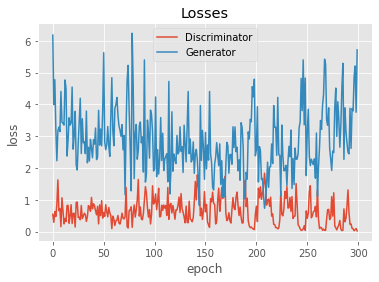

In [129]:
# show the discrimator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

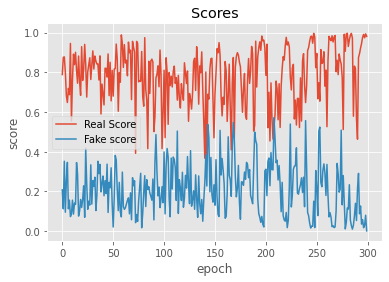

In [130]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");

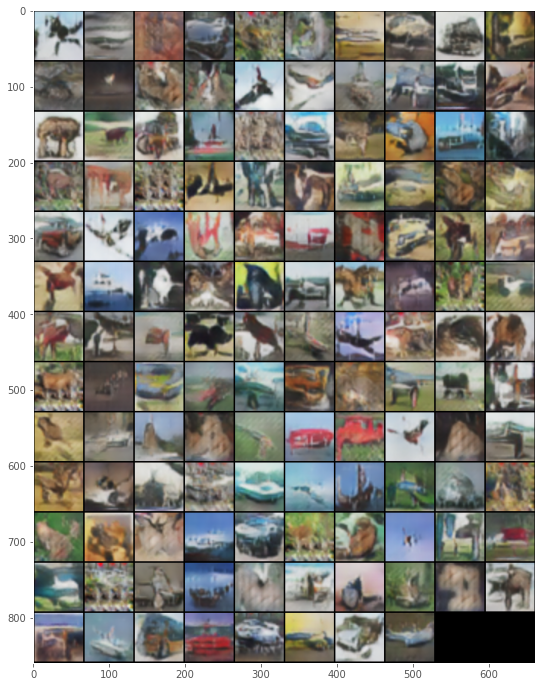

In [142]:
# show output after epochs training
plt.figure(figsize=(12, 12))
plt.grid(False)
plt.imshow(np.asarray(Image.open(os.path.join(sample_dir, "fake_images-0300.png"))))